# **Directories and Libraries Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from pathlib import Path
from transformers import pipeline
import torch
import gc
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define main directory:
main_directory = Path('/content/drive/MyDrive/The Library/Data Science/Causal Inference - 097400/Fiinal Project')
# main_directory = Path('/content/drive/MyDrive/Fiinal Project') # klil - delete later!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Define Data directory:
data_directory = main_directory / 'Data'
output_directory = main_directory / 'Output Files'

# **Preparing the Data**

## Filter Comments (Leave Posts Only)

In [ ]:
# Define file paths
file_path = data_directory  / 'reddit_opinion_PSE_ISR.csv' #reddit data
output_directory = main_directory / 'Output Files'
output_posts_only = output_directory / '1.posts_only.csv'

# Create the output directory if it doesn't exist
output_directory.mkdir(parents=True, exist_ok=True)

# Load the CSV file
data = pd.read_csv(file_path)

# List of comment-related columns to be dropped
comment_columns = [
    'comment_id', 'score', 'self_text', 'created_time', 'author_name', 'controversiality',
    'ups', 'downs', 'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
    'user_awarder_karma', 'user_link_karma', 'user_comment_karma', 'user_total_karma'
]

# Drop the comment-related columns
data_posts_only = data.drop(columns=comment_columns)

# Remove duplicates based on post_id
data_posts_only.drop_duplicates(subset='post_id', inplace=True)

# Save the cleaned data to a new CSV file
data_posts_only.to_csv(output_posts_only, index=False)

print(f"Filtered posts saved to {output_posts_only}")


Filtered posts saved to /content/drive/MyDrive/The Library/Data Science/Causal Inference - 097400/Fiinal Project/Output Files/1.posts_only.csv


## Remove data prior to October 7th

> Add blockquote



In [ ]:
# Define file paths
input_file_path = output_posts_only
output_october7_path = output_directory / '2.posts_after_oct_7_2023.csv'

# Load the CSV file
data = pd.read_csv(input_file_path)

# Convert the 'post_created_time' to datetime format if it isn't already
data['post_created_time'] = pd.to_datetime(data['post_created_time'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2023-10-07')

# Filter the data to include only posts on or after October 7, 2023
filtered_data = data[data['post_created_time'] >= cutoff_date]

# Save the filtered data to a new CSV file
filtered_data.to_csv(output_october7_path, index=False)

print(f"Posts on or after October 7, 2023, saved to {output_october7_path}")


## Tag Posts Political Stance
It is recommended to change "Runtime type" to GPU

In [ ]:
tagg post political stance:
# Step 1: Preprocess and Clean Data
def preprocess_data(file_path, output_clean_path):
    # Load the CSV file
    data = pd.read_csv(file_path, usecols=['post_id', 'post_self_text', 'post_title'])

    # Combine 'post_self_text' and 'post_title' into a single text column
    data['merged_text_and_title'] = data['post_title'].fillna('') + ': ' + data['post_self_text'].fillna('')

    # Drop the redundant columns
    data = data[['post_id', 'merged_text_and_title']]

    # Save the cleaned data to a new CSV file
    data.to_csv(output_clean_path, index=False)

    return output_clean_path

# Step 2: Classify Posts in Chunks with Batch Processing and Add Confidence Score and All Labels/Scores
def classify_in_chunks(cleaned_file_path, political_stance_directory, classifier, labels, chunksize=100, batch_size=8, chunks_per_file=1):
    # Initialize a counter for file naming
    file_counter = 0
    chunk_counter = 0

    # Create a loop to process the file in chunks
    for chunk in pd.read_csv(cleaned_file_path, chunksize=chunksize):

        # Extract the texts for batch processing
        texts = chunk['merged_text_and_title'].tolist()

        # Classify each post's text in batches and get both the labels and scores
        results = classifier(texts, candidate_labels=labels, batch_size=batch_size)

        # Extract the top label, its confidence score, and all labels with their scores
        chunk['post_political_stance'] = [result['labels'][0] for result in results]
        chunk['confidence_score'] = [result['scores'][0] for result in results]  # Get confidence score
        chunk['all_labels'] = [result['labels'] for result in results]  # Get all labels
        chunk['all_scores'] = [result['scores'] for result in results]  # Get all scores

        # Generate a new file every few chunks
        if chunk_counter % chunks_per_file == 0:
            file_counter += 1
            output_path = f'{political_stance_directory}/classified_chunk_{file_counter}.csv'

        # Append the current chunk to the current output file
        chunk.to_csv(output_path, mode='a', index=False, header=not pd.io.common.file_exists(output_path))

        # Increment the chunk counter
        chunk_counter += 1

    # Clear GPU memory after each chunk to avoid memory overflow
    torch.cuda.empty_cache()
    gc.collect()

# Clear GPU memory before starting
torch.cuda.empty_cache()
gc.collect()

# Initialize the zero-shot classification model with GPU
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli", device=0)

# Define the labels for classification
labels = ["Pro-Israel", "Pro-Palestine", "Neutral"]

# Define file paths
input_file_path = output_october7_path
cleaned_file_path = output_directory / '3.cleaned_files.csv'
political_stance_directory = main_directory / 'Political Stance'

# Create the output directory if it doesn't exist
political_stance_directory.mkdir(parents=True, exist_ok=True)

# Step 1: Preprocess and clean the data
preprocessed_file = preprocess_data(input_file_path, cleaned_file_path)

# Step 2: Classify posts in chunks with batch processing and add confidence score and all labels/scores
classify_in_chunks(preprocessed_file, political_stance_directory, classifier, labels, chunksize=100, batch_size=8, chunks_per_file=1)

## Merge Tagged Data with Cleaned Data

In [ ]:
# Step 1: Concatenate all classified chunks into a single DataFrame
def concatenate_classified_chunks(output_directory):
    # Find all CSV files in the output directory
    all_files = [os.path.join(output_directory, f) for f in os.listdir(output_directory) if f.endswith('.csv')]

    # Load all chunk files and concatenate into a single DataFrame
    all_chunks = [pd.read_csv(f) for f in all_files]
    classified_data = pd.concat(all_chunks, ignore_index=True)

    print(f"Classified data contains {classified_data.shape[0]} samples.")
    return classified_data

# Step 2: Merge the classified data with the filtered posts data (including confidence score, all labels, and all scores)
def merge_classified_with_filtered(classified_data, filtered_file_path, output_merged_path):
    # Load the filtered "only posts after October 7" dataset
    filtered_data = pd.read_csv(filtered_file_path)

    # Merge on 'post_id' to add classification results, including post_political_stance, confidence_score, all_labels, and all_scores
    merged_data = pd.merge(filtered_data,
                           classified_data[['post_id', 'post_political_stance', 'confidence_score', 'all_labels', 'all_scores']],
                           on='post_id',
                           how='left')

    # Save the final merged data
    merged_data.to_csv(output_merged_path, index=False)
    print(f"Final merged data saved to {output_merged_path}. It contains {merged_data.shape[0]} samples.")
    return merged_data

# Define file paths
PS_directory = main_directory / 'Political Stance'
filtered_file_path = output_october7_path
output_merged_path = output_directory / '4.posts_with_classification.csv'

# Step 1: Concatenate the classified chunk files
classified_data = concatenate_classified_chunks(6.output_fatalities_per_day.csv)

# Step 2: Merge the classified data with the filtered posts dataset (including confidence and other outputs)
merged_data = merge_classified_with_filtered(classified_data, filtered_file_path, output_merged_path)


# **Generate More Features**

## Add "Post Complexity" feature
Based on nubmer of letters in the post+title

In [ ]:
# Define file paths
output_complexity_path = output_directory / '5.posts_with_complexity.csv'

# Load dataset
data = pd.read_csv(output_merged_path)

# Create a new column for the number of letters in the post and title combined
data['num_letters_post_and_title'] = data['post_self_text'].fillna('') + ' ' + data['post_title'].fillna('')

# Calculate the length of the combined string
data['num_letters_post_and_title'] = data['num_letters_post_and_title'].apply(len)

# Save the final data with the new column
data.to_csv(output_complexity_path, index=False)

print(f"Final data with number of letters saved to {output_complexity_path}")


Final data with number of letters saved to /content/drive/MyDrive/The Library/Data Science/Causal Inference - 097400/Fiinal Project/Output Files/5.posts_with_complexity.csv


## Create "Geopolitical developments" feature


In [ ]:
#Processing Geopolitical Events Data

# Define the file path for the geopolitical event data
event_data_path = data_directory  / '2023-10-01-2024-08-28-Middle_East-Israel-Palestine.csv' #geopolitical data

# Step 1: Load the event data
event_data = pd.read_csv(event_data_path)

# Step 2: Convert 'event_date' to datetime format (adjust format if necessary)
event_data['event_date'] = pd.to_datetime(event_data['event_date'], format='%d %B %Y')

# Step 3: Aggregate the number of fatalities per day, taking the maximum per date
fatalities_per_day = event_data.groupby('event_date')['fatalities'].max().reset_index()

# Step 4: Display the first few rows of the processed data to check the output
print(fatalities_per_day.head())

# Step 4: Save the result to a CSV file
output_file_path = output_directory / '/6.output_fatalities_per_day.csv'
fatalities_per_day.to_csv(output_file_path, index=False)
print(f"Aggregated fatalities per day saved to {output_file_path}")


  event_date  fatalities
0 2023-10-01           0
1 2023-10-02           0
2 2023-10-03           0
3 2023-10-04           0
4 2023-10-05           2
Aggregated fatalities per day saved to /6.output_fatalities_per_day.csv


In [ ]:
# Add "Fatalities" Feature to the Data

# Define file paths
posts_data_path = output_directory / '5.posts_with_complexity.csv'
fatalities_data_path = output_directory / '6.output_fatalities_per_day.csv'
output_file_path = output_directory / '7.posts_with_fatalities.csv'

# Step 1: Load both datasets
posts_data = pd.read_csv(posts_data_path)
fatalities_per_day = pd.read_csv(fatalities_data_path)

# Step 2: Convert 'post_created_time' and 'event_date' to datetime, and only keep the date part
posts_data['post_created_time'] = pd.to_datetime(posts_data['post_created_time'])
fatalities_per_day['event_date'] = pd.to_datetime(fatalities_per_day['event_date']).dt.date

# Create a temporary column for the date only (without time) for the merge
posts_data['post_created_date'] = posts_data['post_created_time'].dt.date

# Step 3: Merge the datasets based on the date columns
# Perform a left join to keep all posts data, even if there are no corresponding fatalities
merged_data = pd.merge(posts_data, fatalities_per_day, left_on='post_created_date', right_on='event_date', how='left')

# Step 4: Drop rows where 'fatalities' is NaN (if there are no corresponding fatalities data for that date)
merged_data = merged_data.dropna(subset=['fatalities'])

# Step 5: Drop the 'event_date', 'post_created_date' columns from the merged data (optional, if no longer needed)
merged_data = merged_data.drop(columns=['event_date', 'post_created_date'])

# Step 6: Save the final dataset with the added 'fatalities' feature
merged_data.to_csv(output_file_path, index=False)

print(f"Final posts data with fatalities saved to {output_file_path}")







Final posts data with fatalities saved to /content/drive/MyDrive/The Library/Data Science/Causal Inference - 097400/Fiinal Project/Output Files/7.posts_with_fatalities.csv


## Add "Post Polarization" Feature

In [ ]:
# Function to calculate Polarity Score
def calculate_polarity_score(likes, dislikes):
    total_votes = likes + dislikes
    if total_votes == 0:
        return np.nan  # Handle cases with no votes
    normalized_score = (likes - dislikes) / total_votes
    tau = 1000
    scaling_factor = 1 - np.exp(-total_votes / tau)
    polarity_score = normalized_score * scaling_factor

    return polarity_score

# Load your dataset
file_path = output_directory / '7.posts_with_fatalities.csv'

data = pd.read_csv(file_path)

# Ensure likes and post_upvote_ratio are not zero or NaN
data = data[(data['post_thumbs_ups'] > 0) & (data['post_upvote_ratio'] > 0)]

# Step 1: Calculate dislikes (post_downvotes)
data['post_downvotes'] = data['post_thumbs_ups'] * (1 - data['post_upvote_ratio']) / data['post_upvote_ratio']

# Step 2: Calculate Polarity Score
data['polarity_score'] = data.apply(lambda row: calculate_polarity_score(row['post_thumbs_ups'], row['post_downvotes']), axis=1)

# Drop rows where Polarity Score couldn't be calculated (optional)
data.dropna(subset=['polarity_score'], inplace=True)

# Save the updated data with Polarity Score
output_path = output_directory / '8.posts_with_polarity.csv'
data.to_csv(output_path, index=False)

# Check the results
data[['post_thumbs_ups', 'post_downvotes', 'polarity_score']].head()

post_thumbs_ups  post_downvotes  polarity_score
0                9        7.363636        0.001623
1                9        7.363636        0.001623
2             1679       69.958333        0.759961
3             1679       69.958333        0.759961
4               67       30.101449        0.035164

## Remove Neutral Political Stance and Low Confident Posts

In [ ]:
# Load your dataset
file_path = output_directory / '8.posts_with_polarity.csv'
data = pd.read_csv(file_path)

# Remove rows where 'post_political_stance' is 'NEUTRAL'
new_data = data[data['post_political_stance'] != 'Neutral']

# Save the datalowconfidence data
data_low_confidence = new_data[new_data['confidence_score'] < 0.6]
output_path = output_directory / '10.datalowconfidence.csv'
data_low_confidence.to_csv(output_path, index=False)

# Remove rows where 'confidence_score' < 0.6
new_data = new_data[new_data['confidence_score'] >= 0.6]

# Apply the mapping to the 'post_political_stance' column
political_stance_mapping = {
    'Pro-Palestine': 0,
    'Pro-Israel': 1
}

new_data['post_political_stance'] = new_data['post_political_stance'].replace(political_stance_mapping)

# Save the updated data with Polarity Score
output_path = output_directory / '9.data_wo_neutral_stence.csv'
new_data.to_csv(output_path, index=False)

<ipython-input-56-84f50e9e55f7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['post_political_stance'] = new_data['post_political_stance'].replace(political_stance_mapping)


# **Data Visualization**

## Political Stance Histogram

Including subdevision by confidentiality


Pro-Israel samples:


<ipython-input-57-2b167ea31816>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_counts.index, y=confidence_counts.values, palette='Blues')


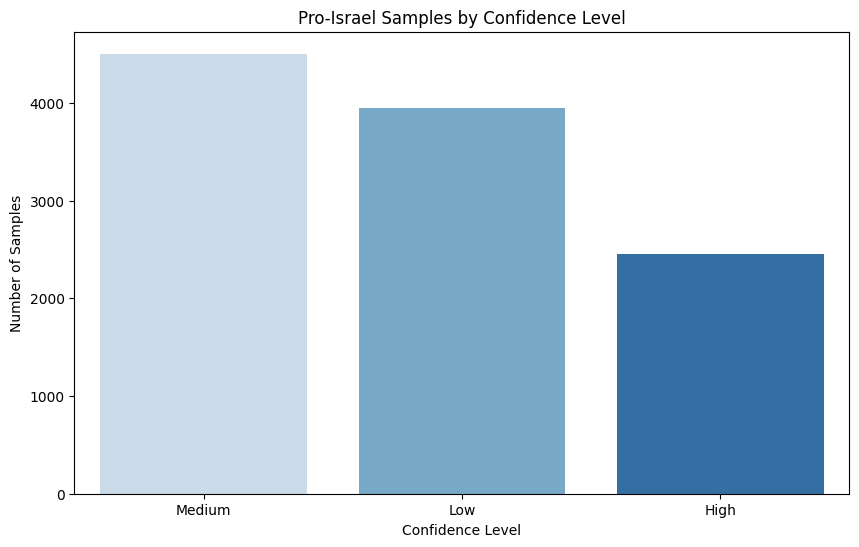

Pro-Palestine samples:


<ipython-input-57-2b167ea31816>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_counts.index, y=confidence_counts.values, palette='Blues')


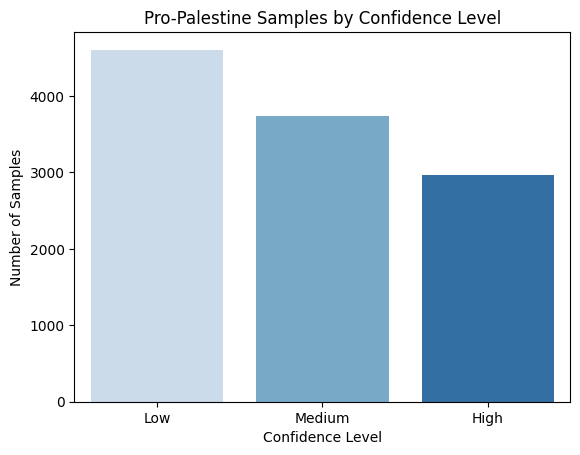

Neutral samples:


<ipython-input-57-2b167ea31816>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_counts.index, y=confidence_counts.values, palette='Blues')


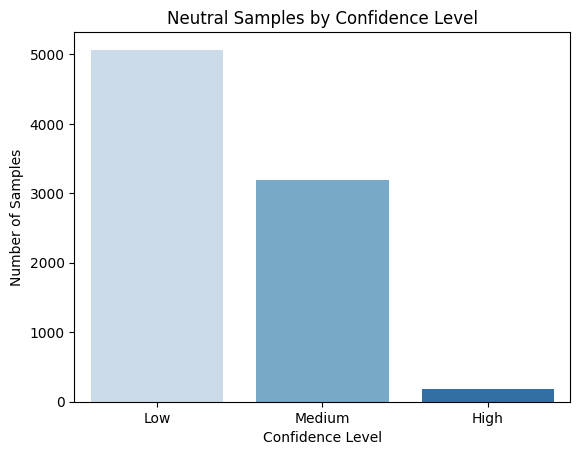

In [ ]:

# Load your data
file_path = output_directory / '7.posts_with_fatalities.csv'
data = pd.read_csv(file_path)

# Step 1: Create bins for confidence scores
def categorize_confidence(score):
    if score < 0.5:
        return 'Low'
    elif 0.5 <= score < 0.75:
        return 'Medium'
    else:
        return 'High'

data['confidence_category'] = data['confidence_score'].apply(categorize_confidence)

# Step 2: Filter the data into categories of political stance
pro_israel = data[data['post_political_stance'] == 'Pro-Israel']
pro_palestine = data[data['post_political_stance'] == 'Pro-Palestine']
neutral = data[data['post_political_stance'] == 'Neutral']

# Step 3: Create sub-diagrams for each category based on confidence level
def plot_confidence_distribution(category_data, category_name):
    # Count samples in each confidence category
    confidence_counts = category_data['confidence_category'].value_counts()

    # Plot
    sns.barplot(x=confidence_counts.index, y=confidence_counts.values, palette='Blues')
    plt.title(f"{category_name} Samples by Confidence Level")
    plt.xlabel("Confidence Level")
    plt.ylabel("Number of Samples")
    plt.show()

# Step 4: Plot for each category
plt.figure(figsize=(10, 6))

print("Pro-Israel samples:")
plot_confidence_distribution(pro_israel, "Pro-Israel")

print("Pro-Palestine samples:")
plot_confidence_distribution(pro_palestine, "Pro-Palestine")

print("Neutral samples:")
plot_confidence_distribution(neutral, "Neutral")


## Correlation Heatmap

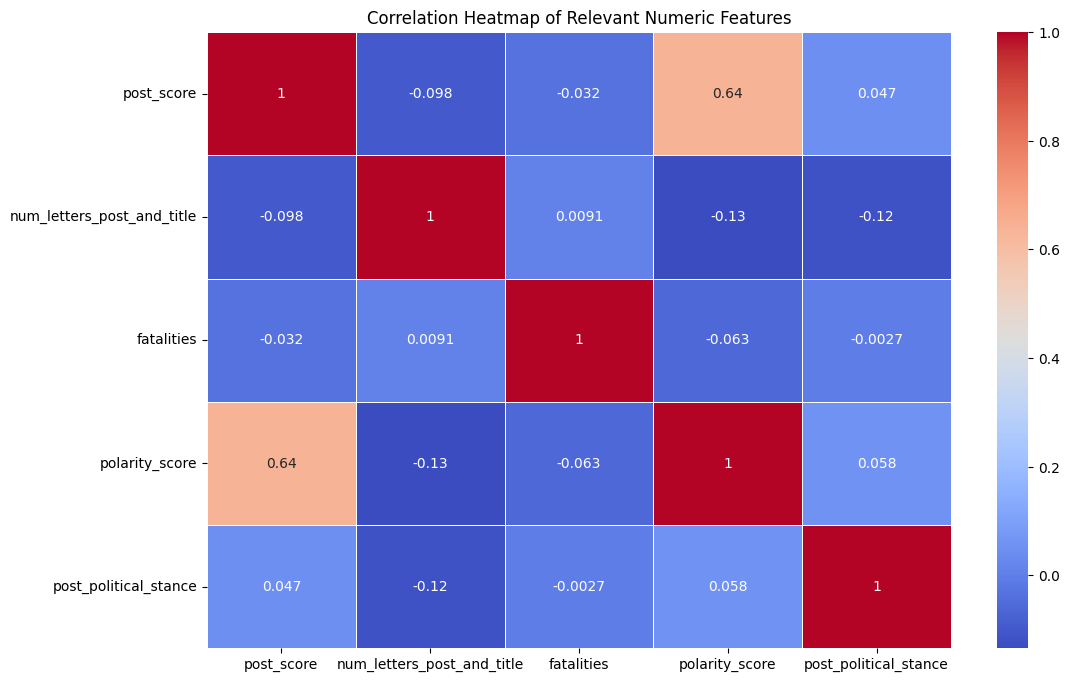

In [ ]:
# Load the dataset
file_path = output_directory / '9.data_wo_neutral_stence.csv'
data = pd.read_csv(file_path)

relevant_features = [
    'post_score',
    'num_letters_post_and_title',
    'fatalities',
    'polarity_score',
    'post_political_stance'  # Include political stance as a feature
]

# Calculate the correlation matrix
correlation_matrix = data[relevant_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Relevant Numeric Features")
plt.show()

## More

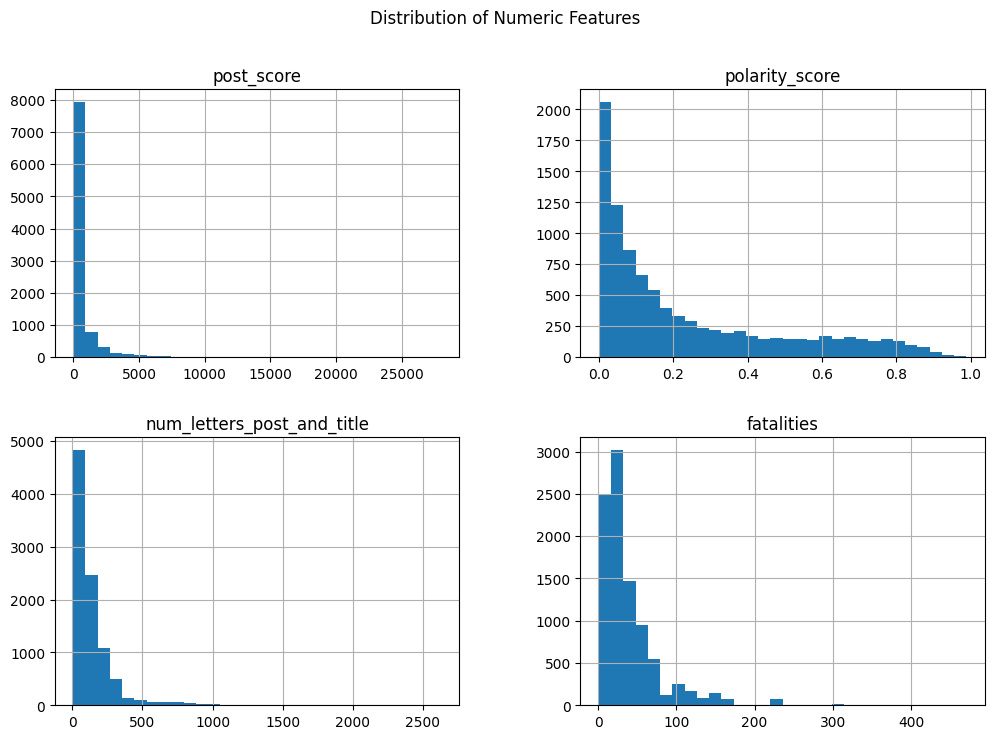

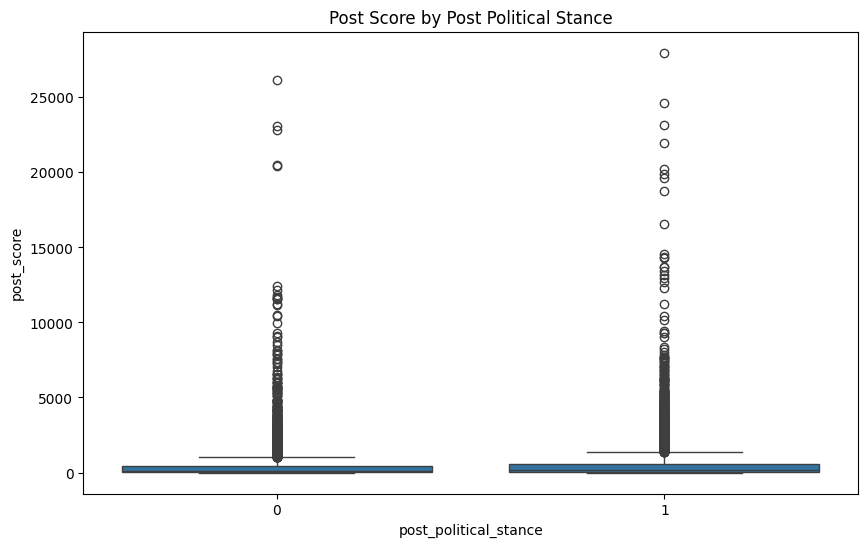

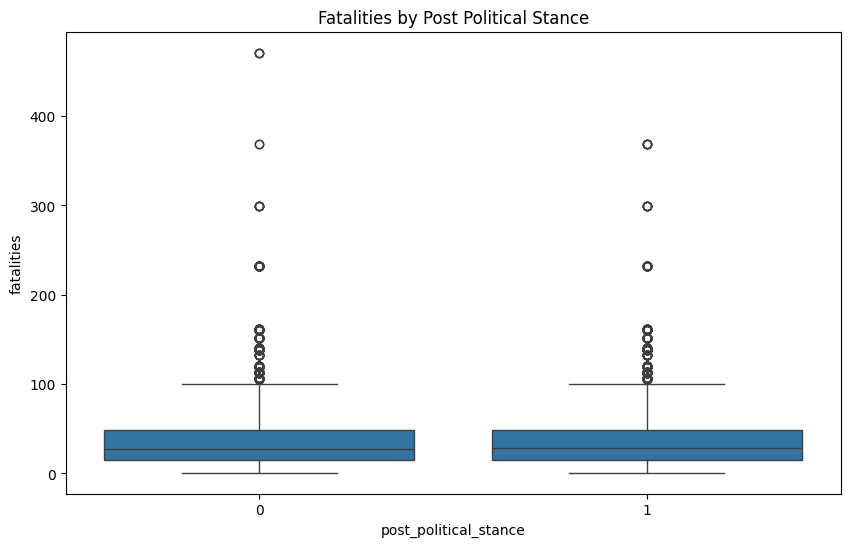

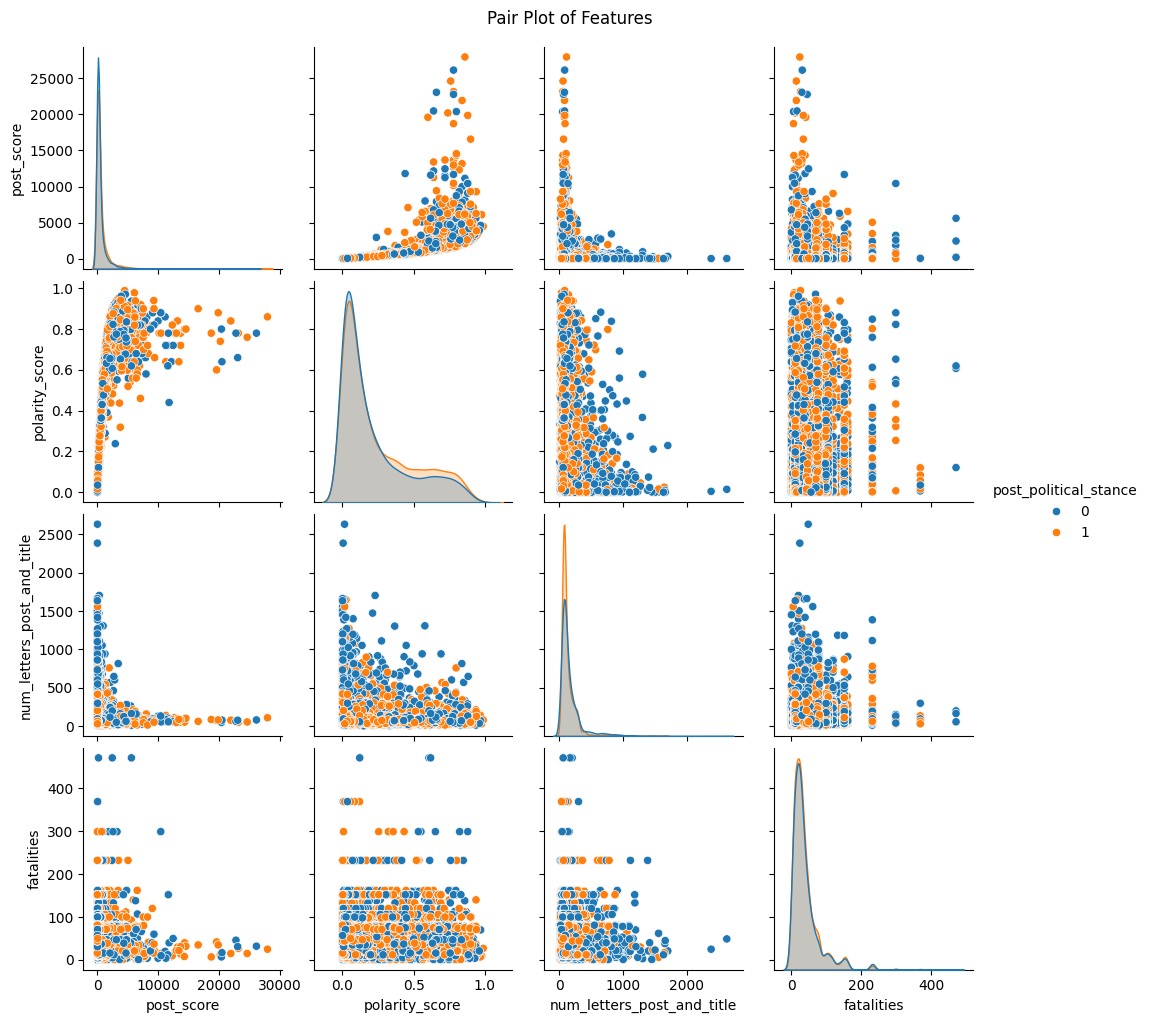

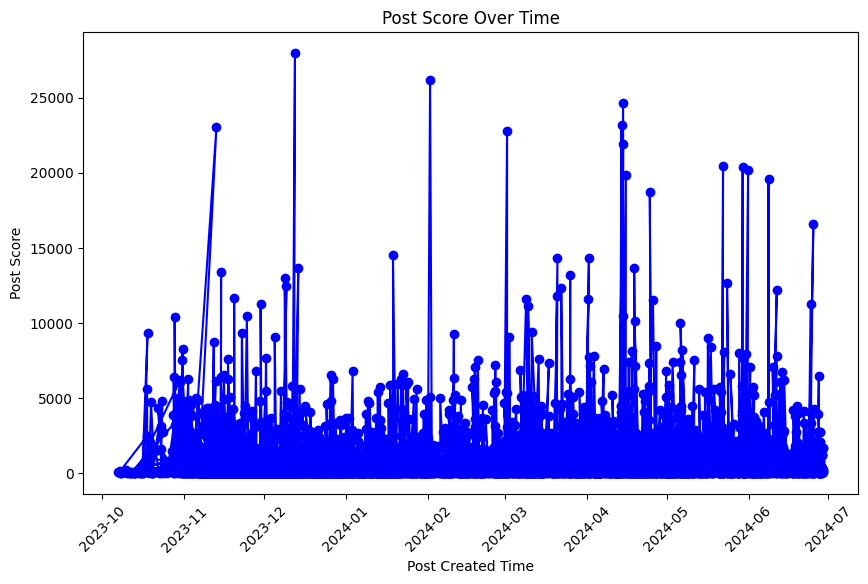

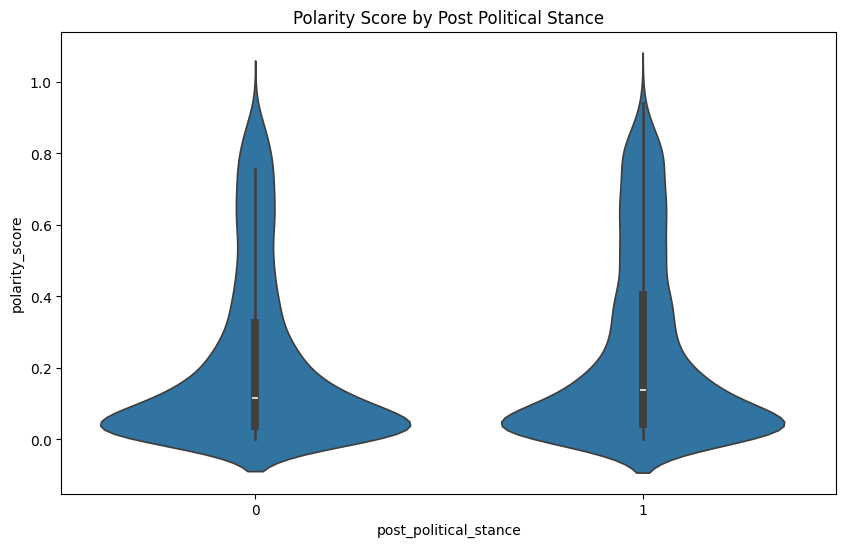

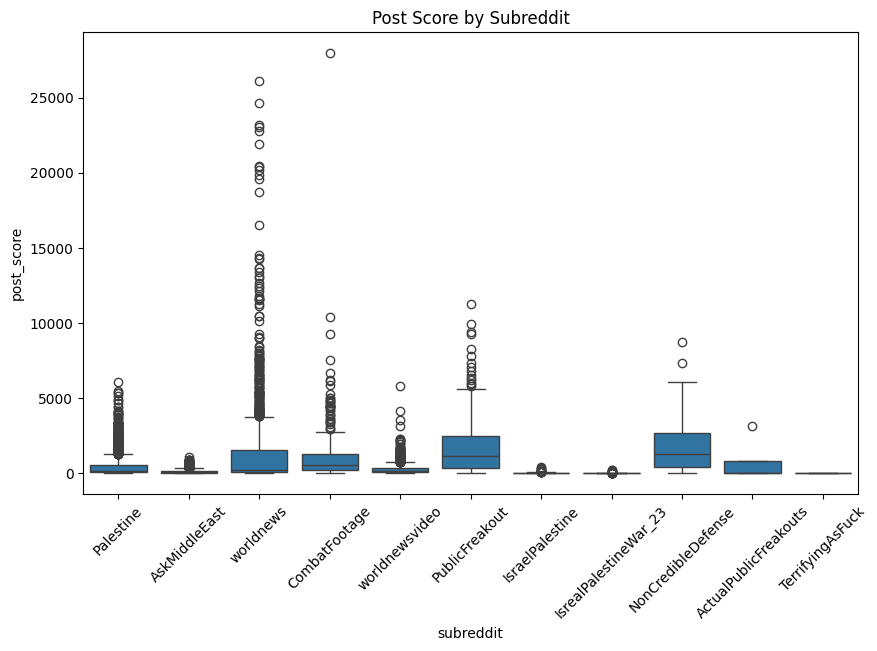

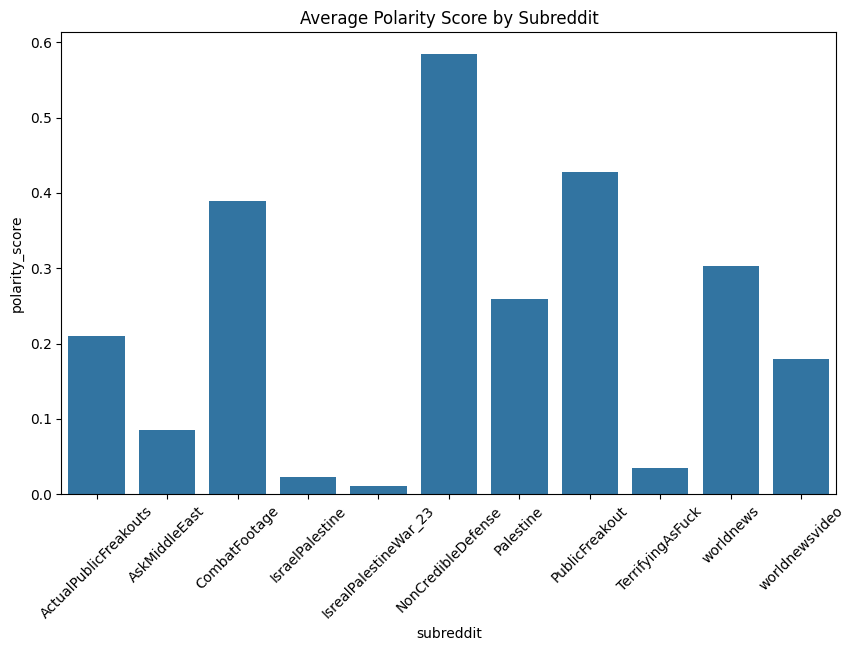

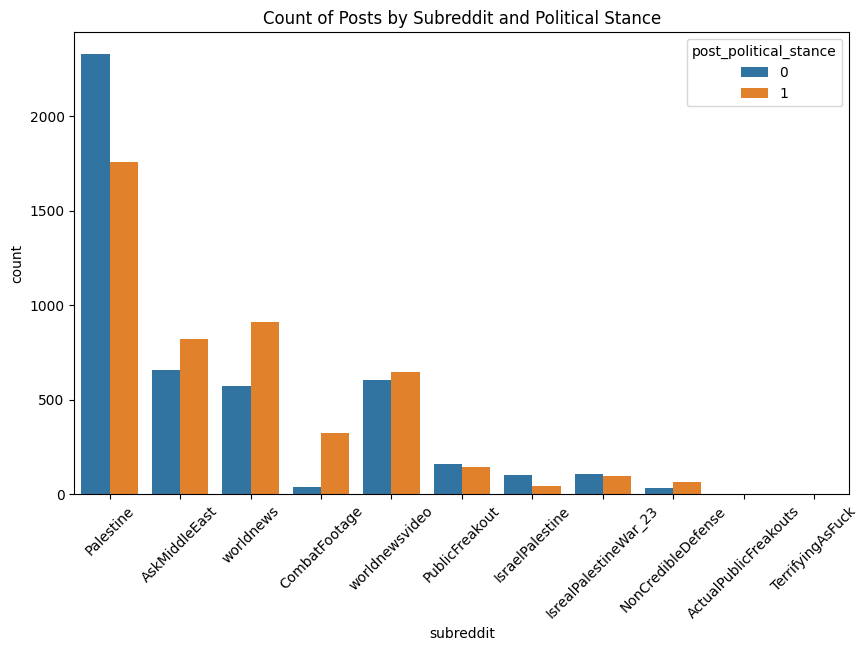

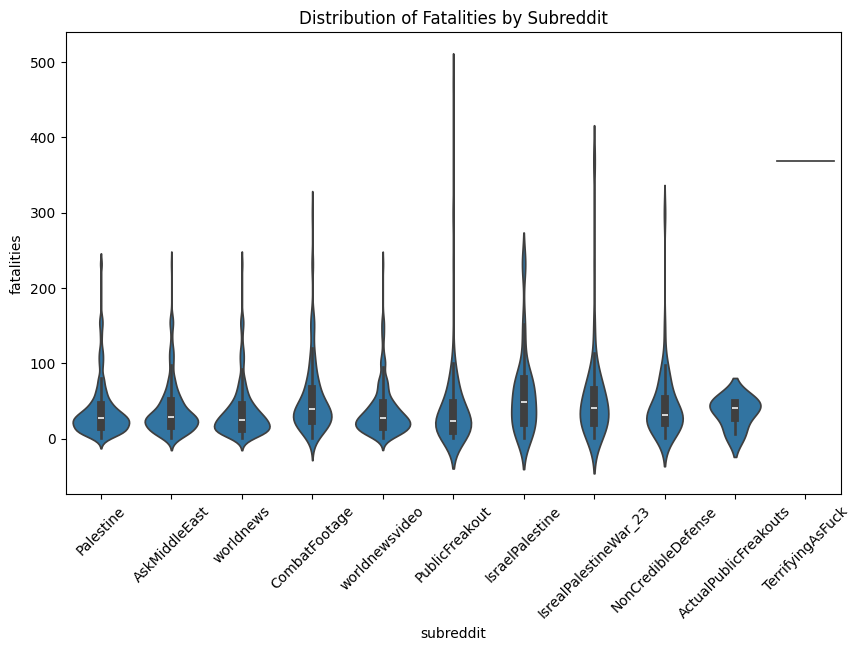

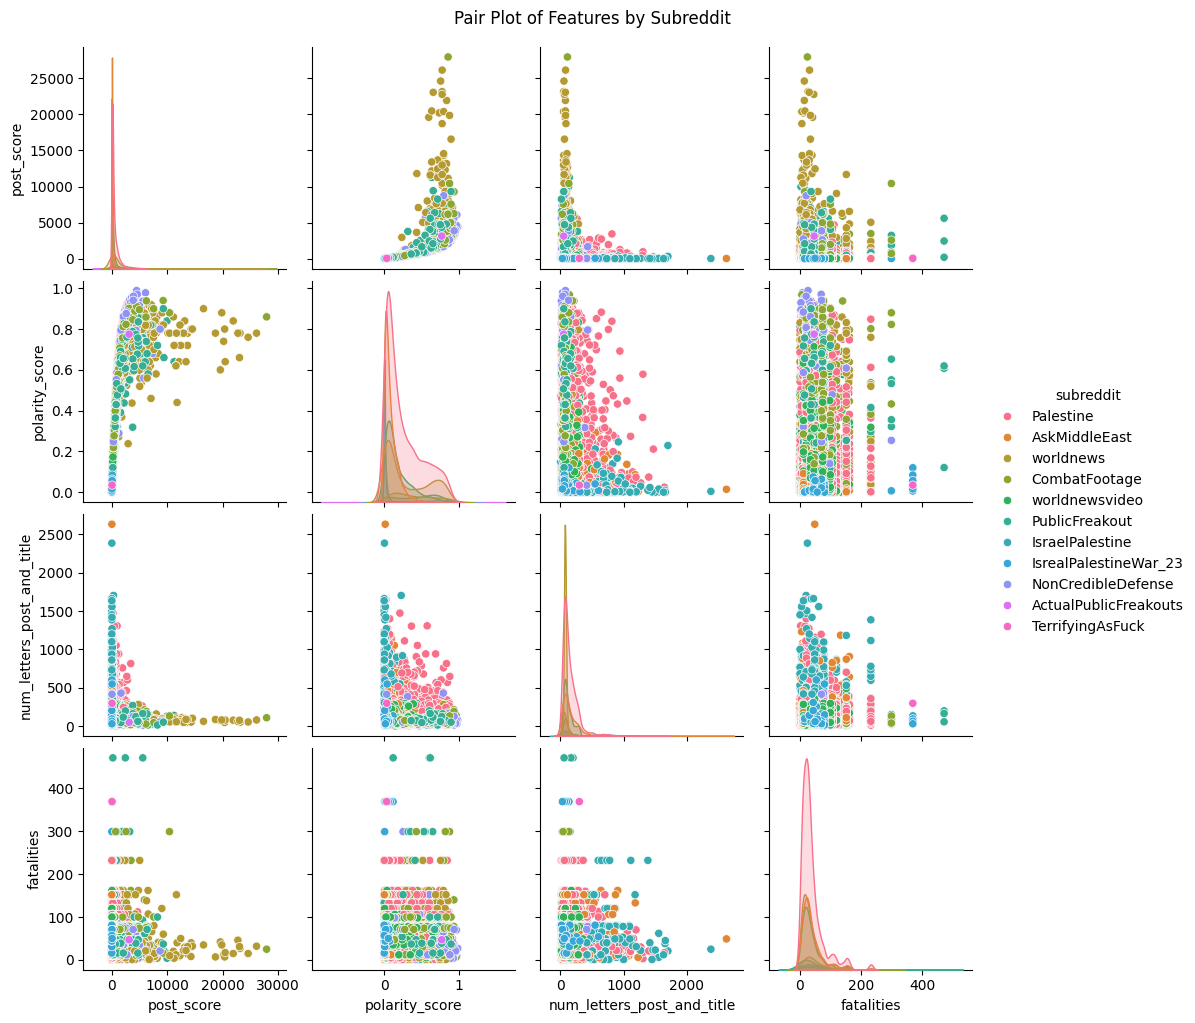

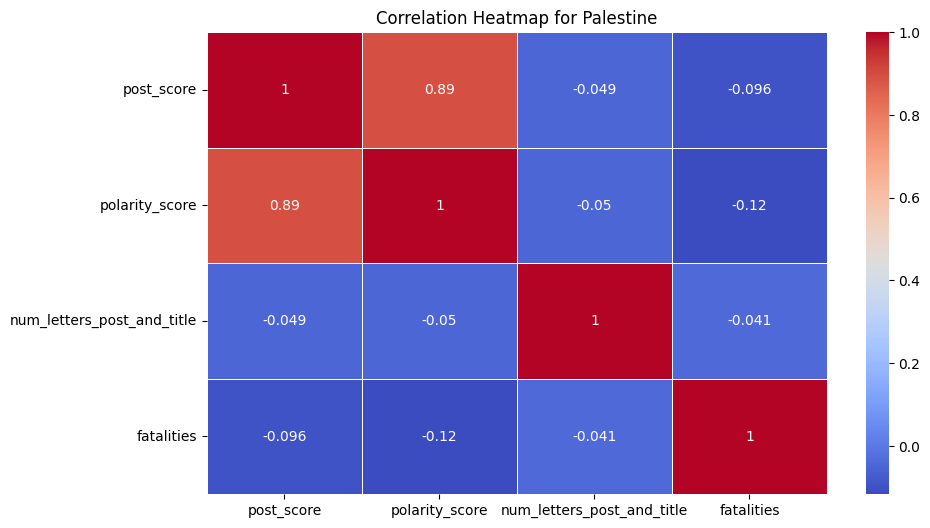

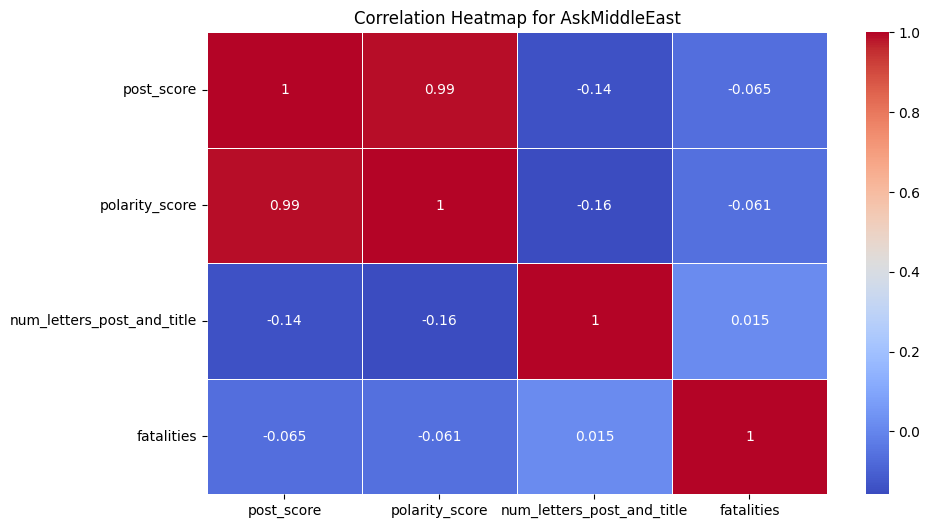

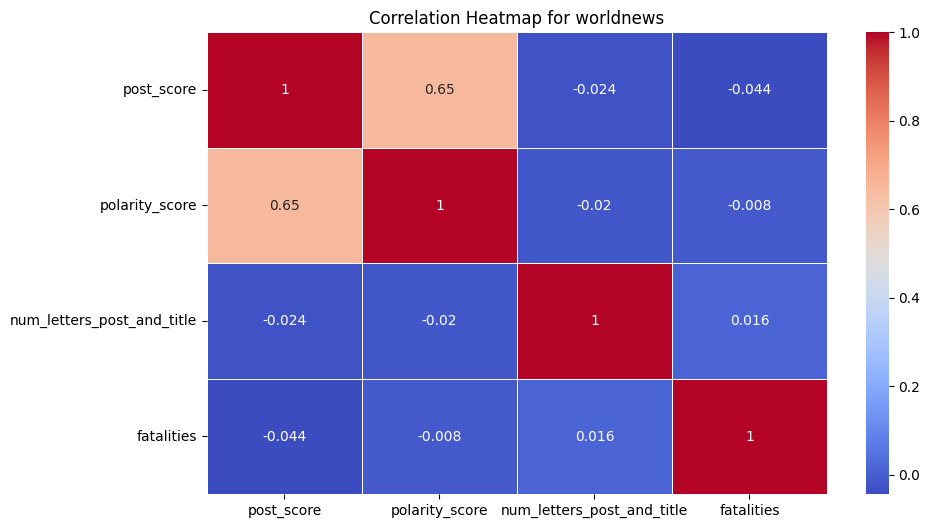

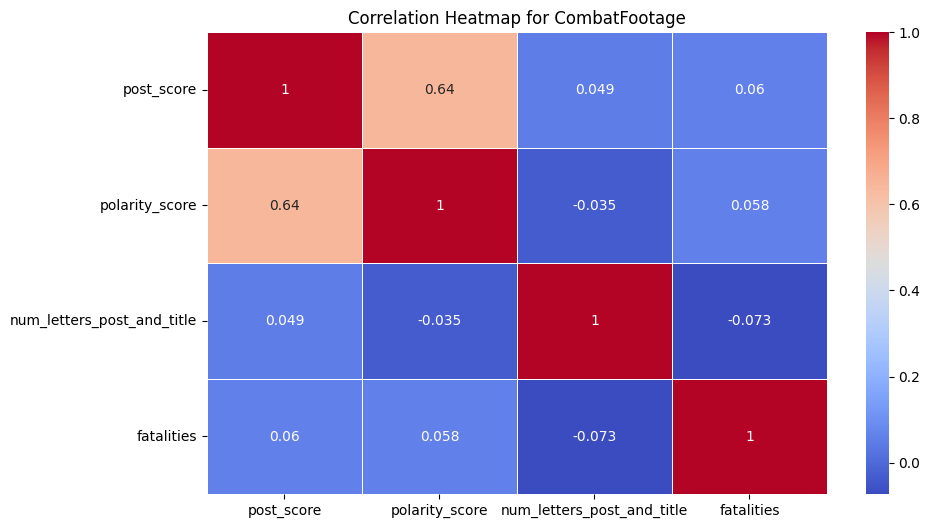

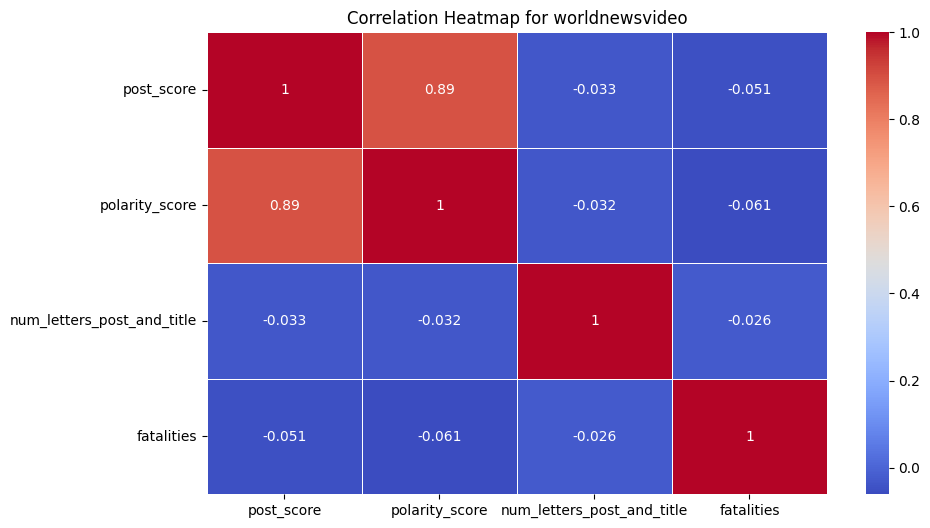

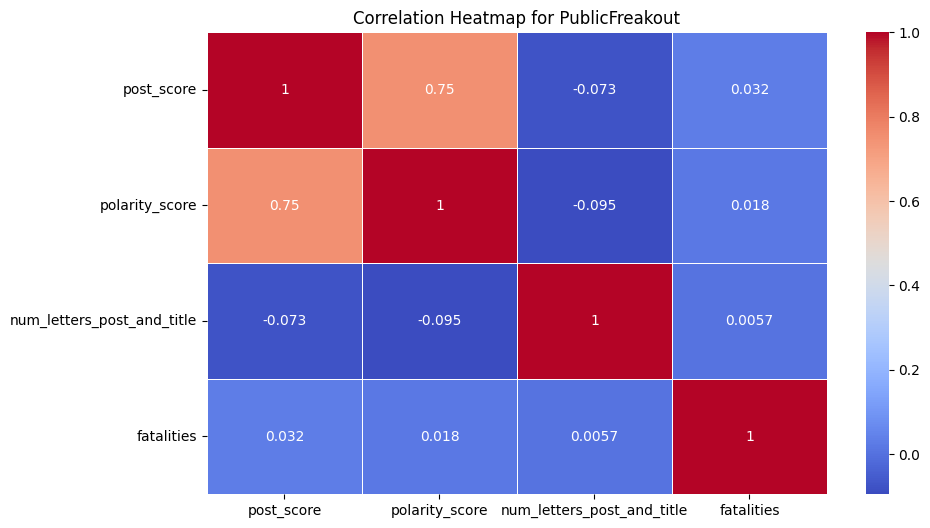

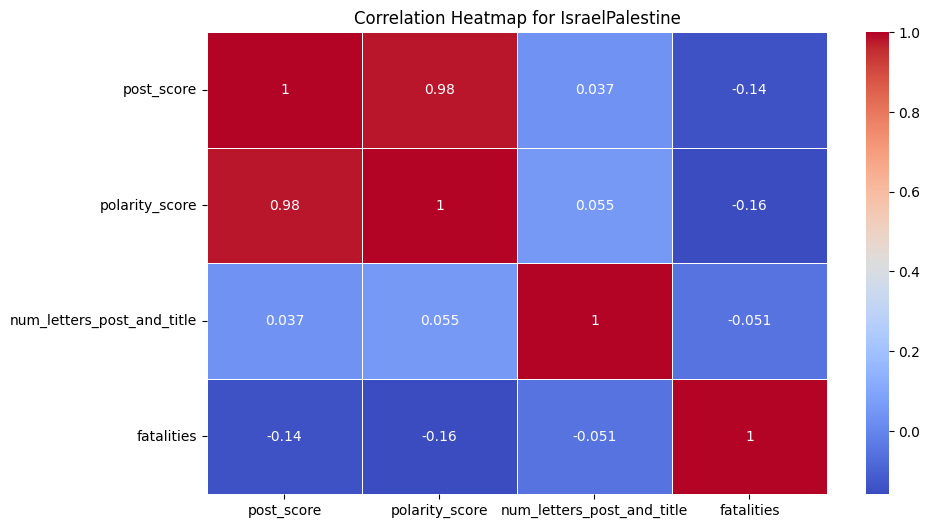

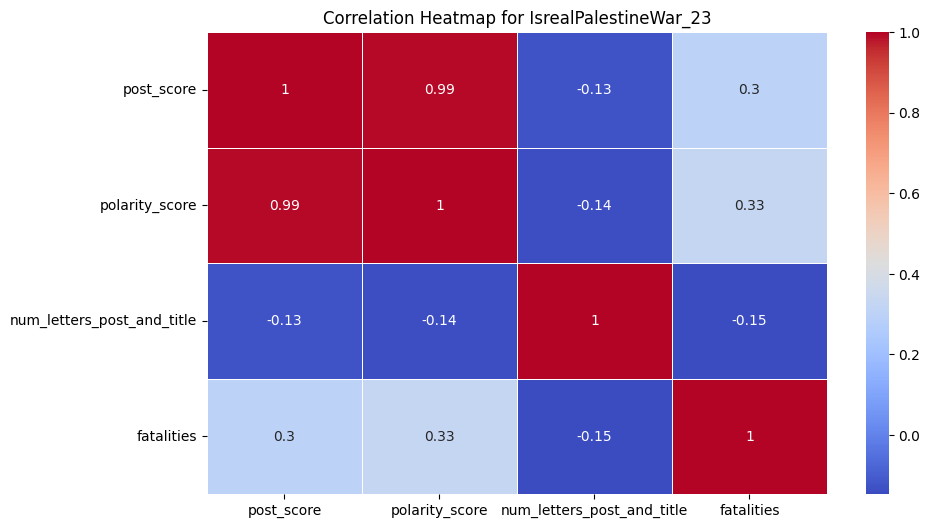

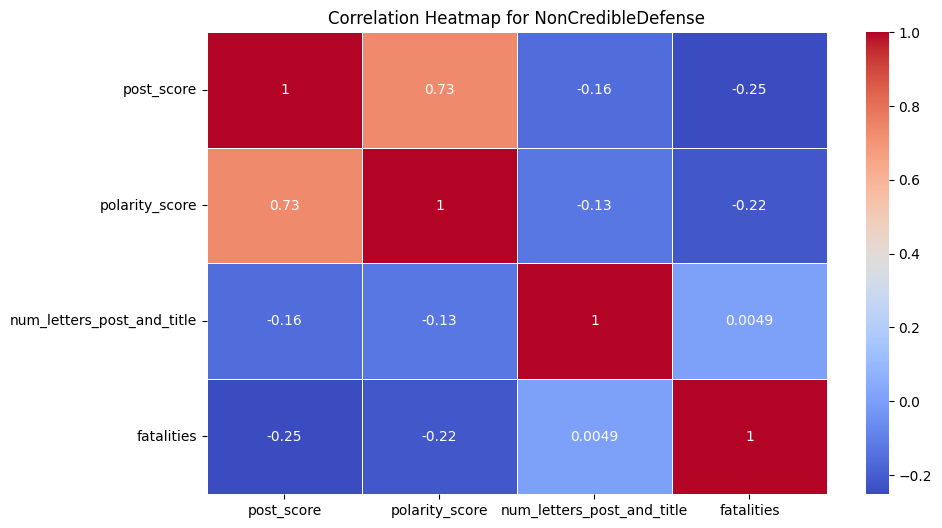

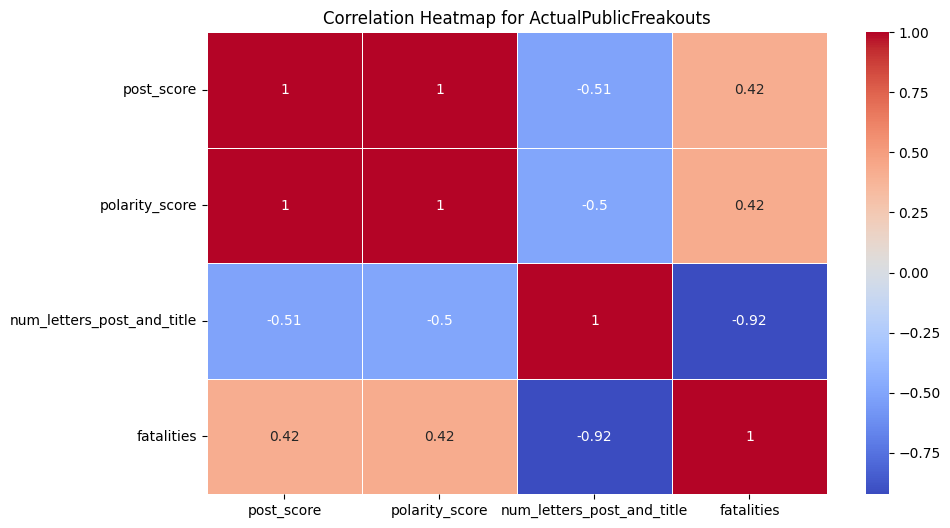

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


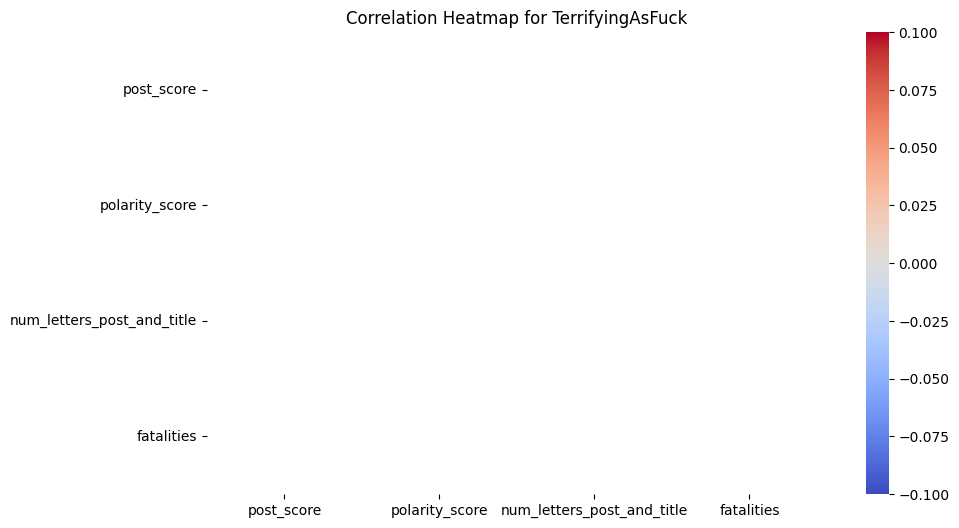

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv(output_directory / '9.data_wo_neutral_stence.csv')

# Convert post_created_time to datetime if not already
data['post_created_time'] = pd.to_datetime(data['post_created_time'])

# 1. Distribution Plots (Histograms) for Numeric Features
data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Numeric Features')
plt.show()

# 2. Box Plot for post_score by post_political_stance
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='post_score', data=data)
plt.title('Post Score by Post Political Stance')
plt.show()

# Boxplot for fatalities by post_political_stance
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='fatalities', data=data)
plt.title('Fatalities by Post Political Stance')
plt.show()

# 3. Pair Plot to Explore Pairwise Relationships
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'post_political_stance']], hue='post_political_stance')
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

# 4. Time Series Plot for Post Created Time vs. Post Score
plt.figure(figsize=(10, 6))
plt.plot(data['post_created_time'], data['post_score'], marker='o', linestyle='-', color='b')
plt.title('Post Score Over Time')
plt.xlabel('Post Created Time')
plt.ylabel('Post Score')
plt.xticks(rotation=45)
plt.show()

# 5. Violin Plot for Polarity Score by Political Stance
plt.figure(figsize=(10, 6))
sns.violinplot(x='post_political_stance', y='polarity_score', data=data)
plt.title('Polarity Score by Post Political Stance')
plt.show()

# 6. Box Plot to Compare Post Scores Across Subreddits
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='post_score', data=data)
plt.title('Post Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 7. Bar Plot for Average Polarity Score by Subreddit
plt.figure(figsize=(10, 6))
avg_polarity_by_subreddit = data.groupby('subreddit')['polarity_score'].mean().reset_index()
sns.barplot(x='subreddit', y='polarity_score', data=avg_polarity_by_subreddit)
plt.title('Average Polarity Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 8. Count Plot of Posts by Subreddit and Political Stance
plt.figure(figsize=(10, 6))
sns.countplot(x='subreddit', hue='post_political_stance', data=data)
plt.title('Count of Posts by Subreddit and Political Stance')
plt.xticks(rotation=45)
plt.show()

# 9. Violin Plot to Show the Distribution of Fatalities by Subreddit
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='fatalities', data=data)
plt.title('Distribution of Fatalities by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 10. Pair Plot Colored by Subreddit
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'subreddit']], hue='subreddit')
plt.suptitle('Pair Plot of Features by Subreddit', y=1.02)
plt.show()

# 11. Heatmap of Correlations for Each Subreddit
subreddits = data['subreddit'].unique()
for subreddit in subreddits:
    plt.figure(figsize=(10, 6))
    subreddit_data = data[data['subreddit'] == subreddit]
    correlation_matrix = subreddit_data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f"Correlation Heatmap for {subreddit}")
    plt.show()


## Visualization for filtered data

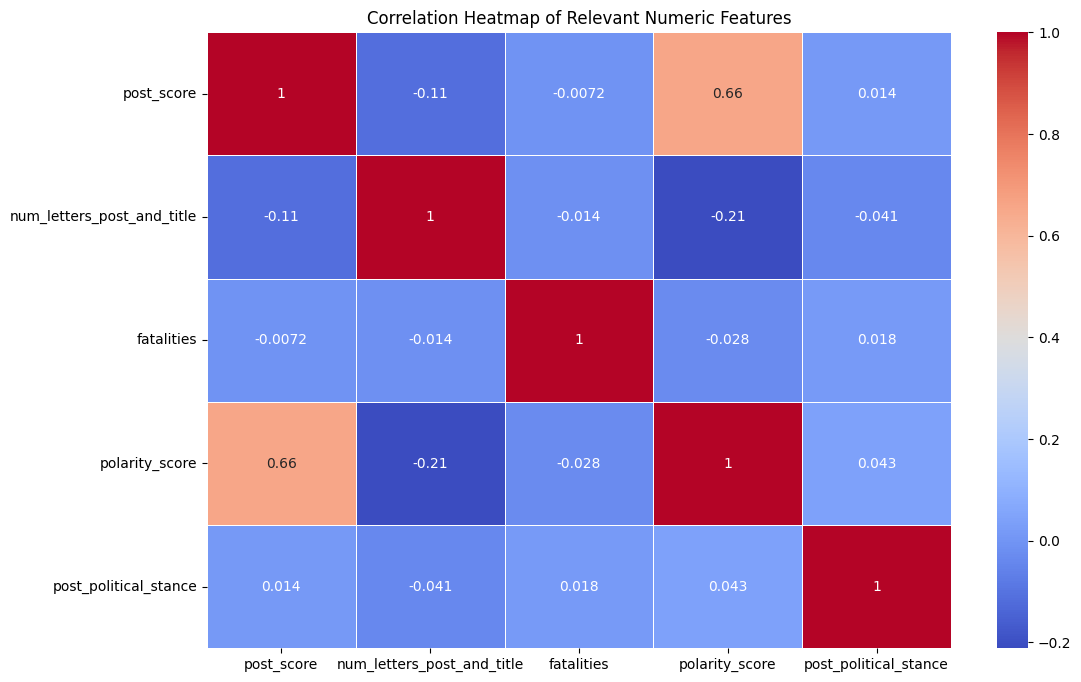

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = output_directory / '10.datalowconfidence.csv'
data = pd.read_csv(file_path)

# Apply the mapping to the 'post_political_stance' column
political_stance_mapping = {
    'Pro-Palestine': 0,
    'Pro-Israel': 1
}

# Replace the values in the data using the mapping
data['post_political_stance'] = data['post_political_stance'].replace(political_stance_mapping)

# Define the relevant features
relevant_features = [
    'post_score',
    'num_letters_post_and_title',
    'fatalities',
    'polarity_score',
    'post_political_stance'  # Include political stance as a feature
]

# Calculate the correlation matrix
correlation_matrix = data[relevant_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Relevant Numeric Features")
plt.show()


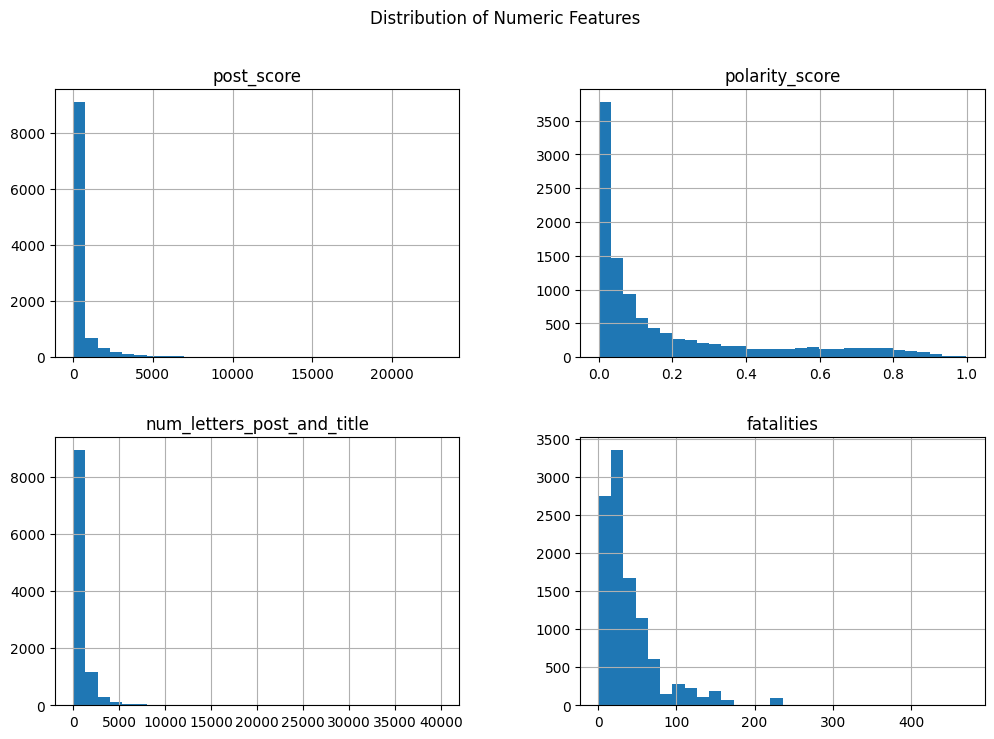

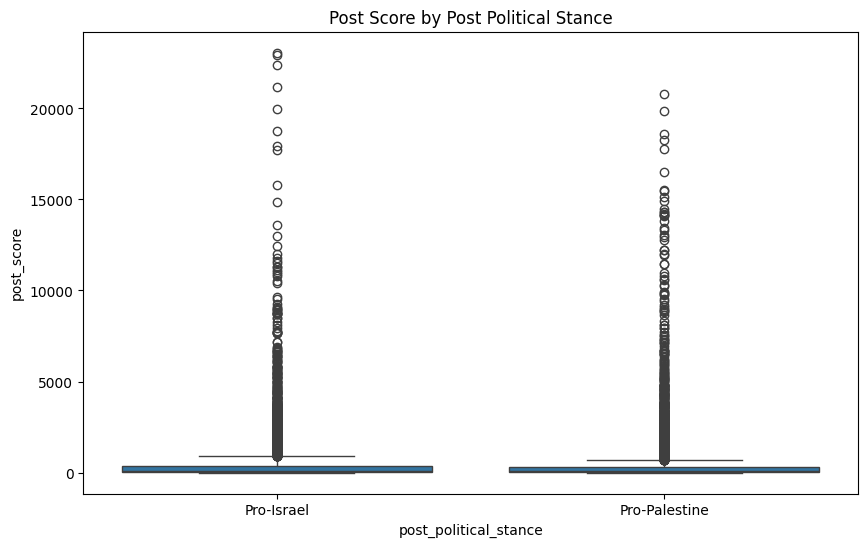

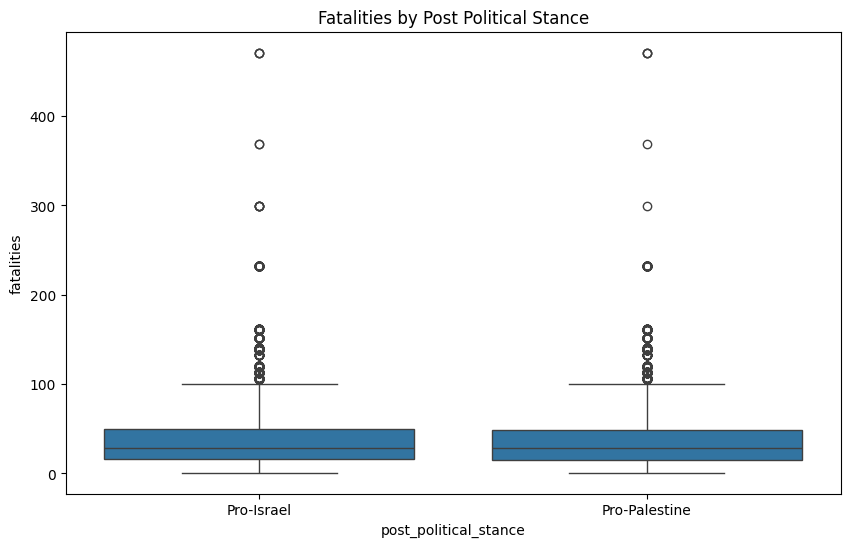

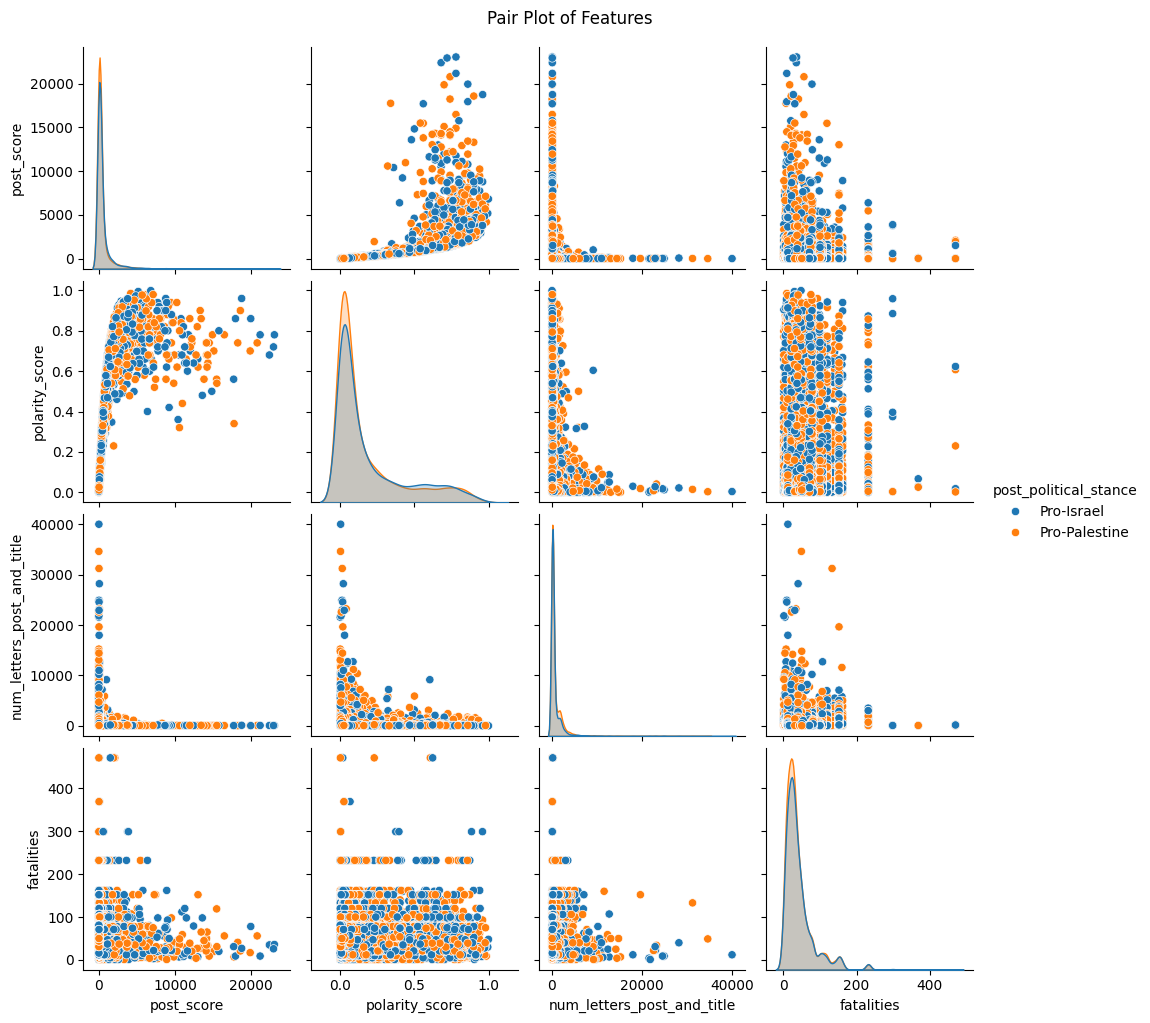

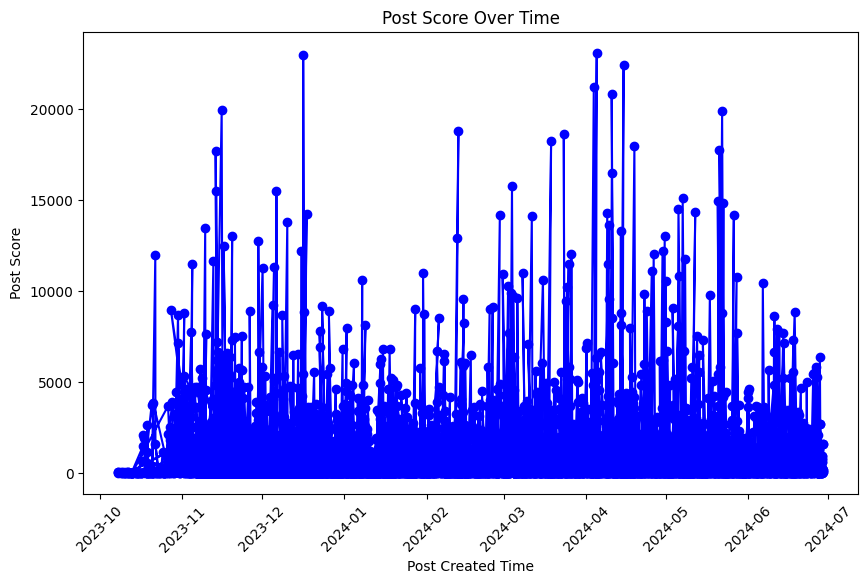

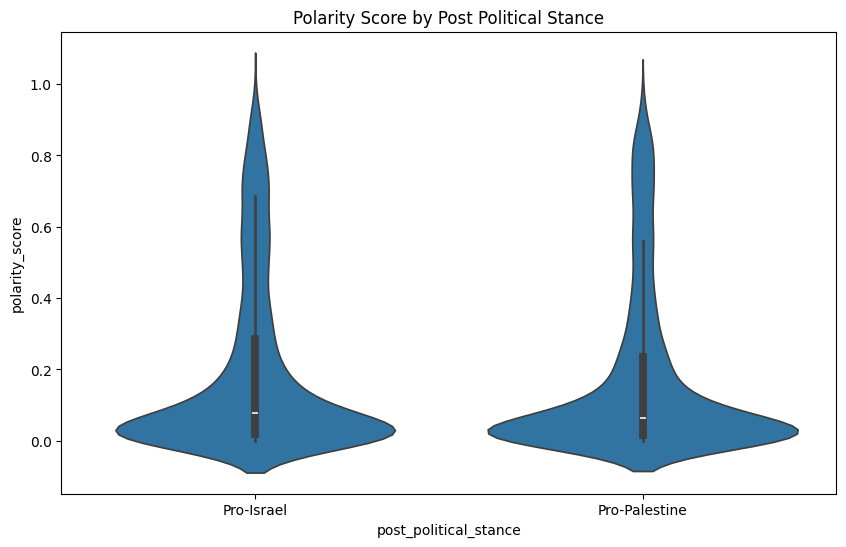

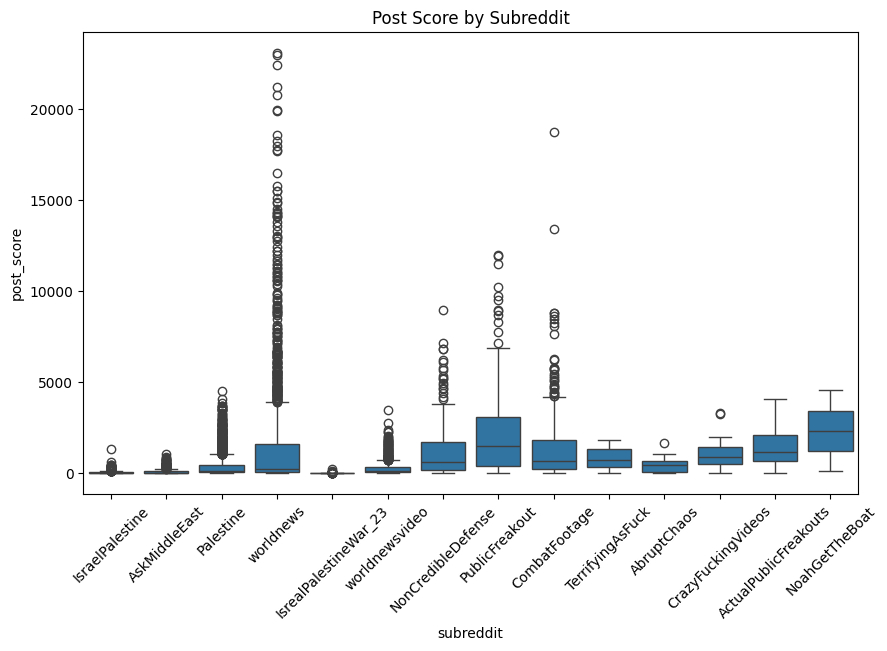

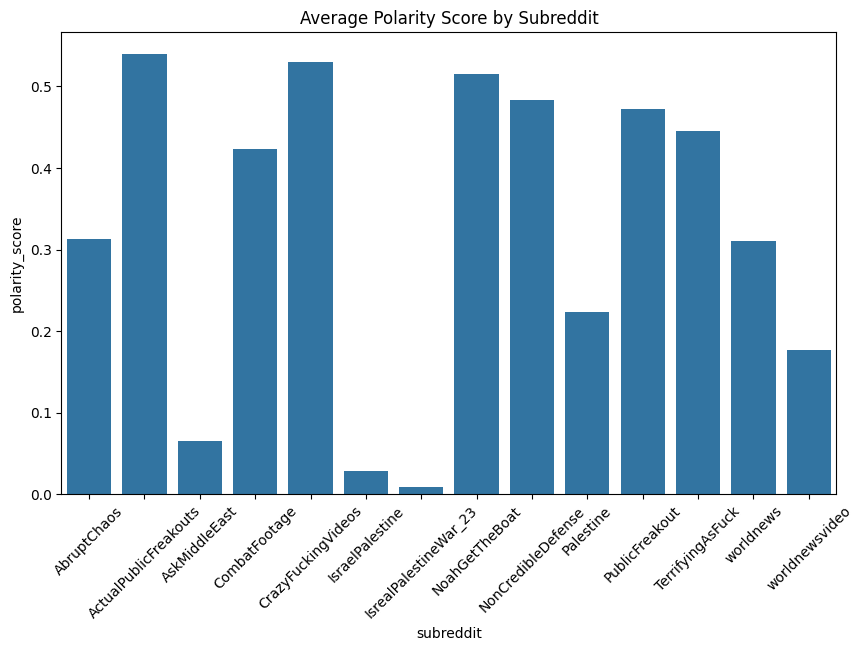

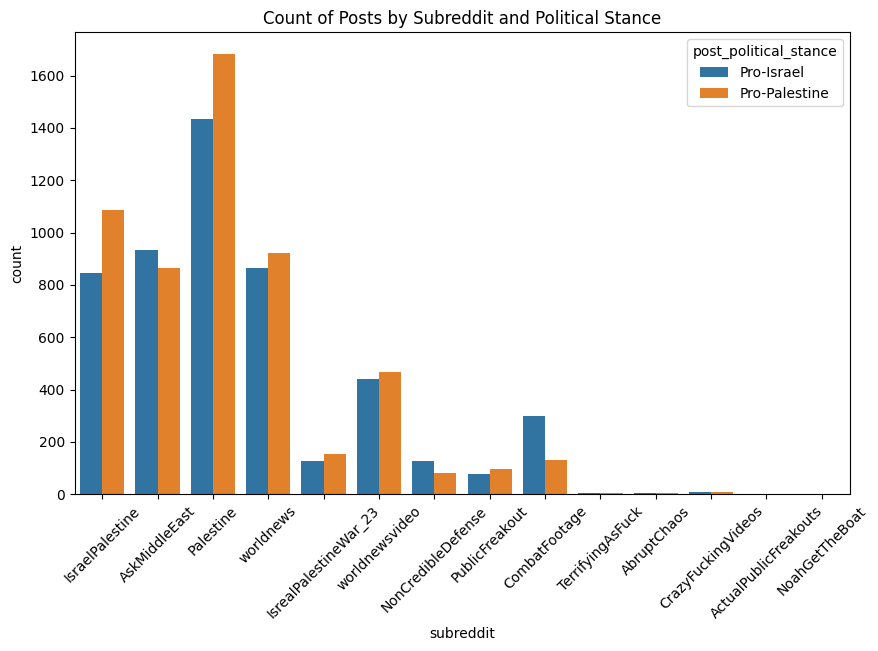

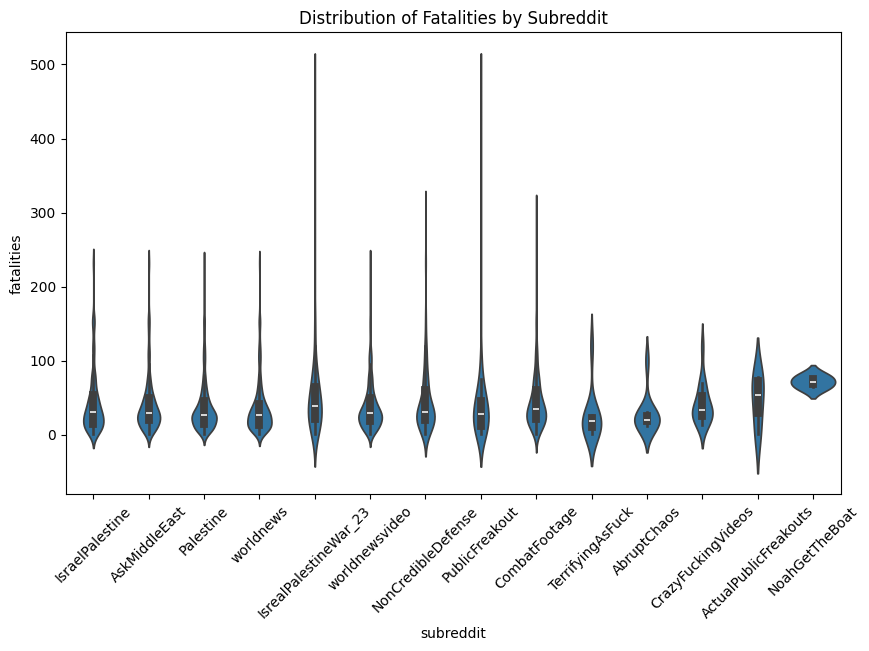

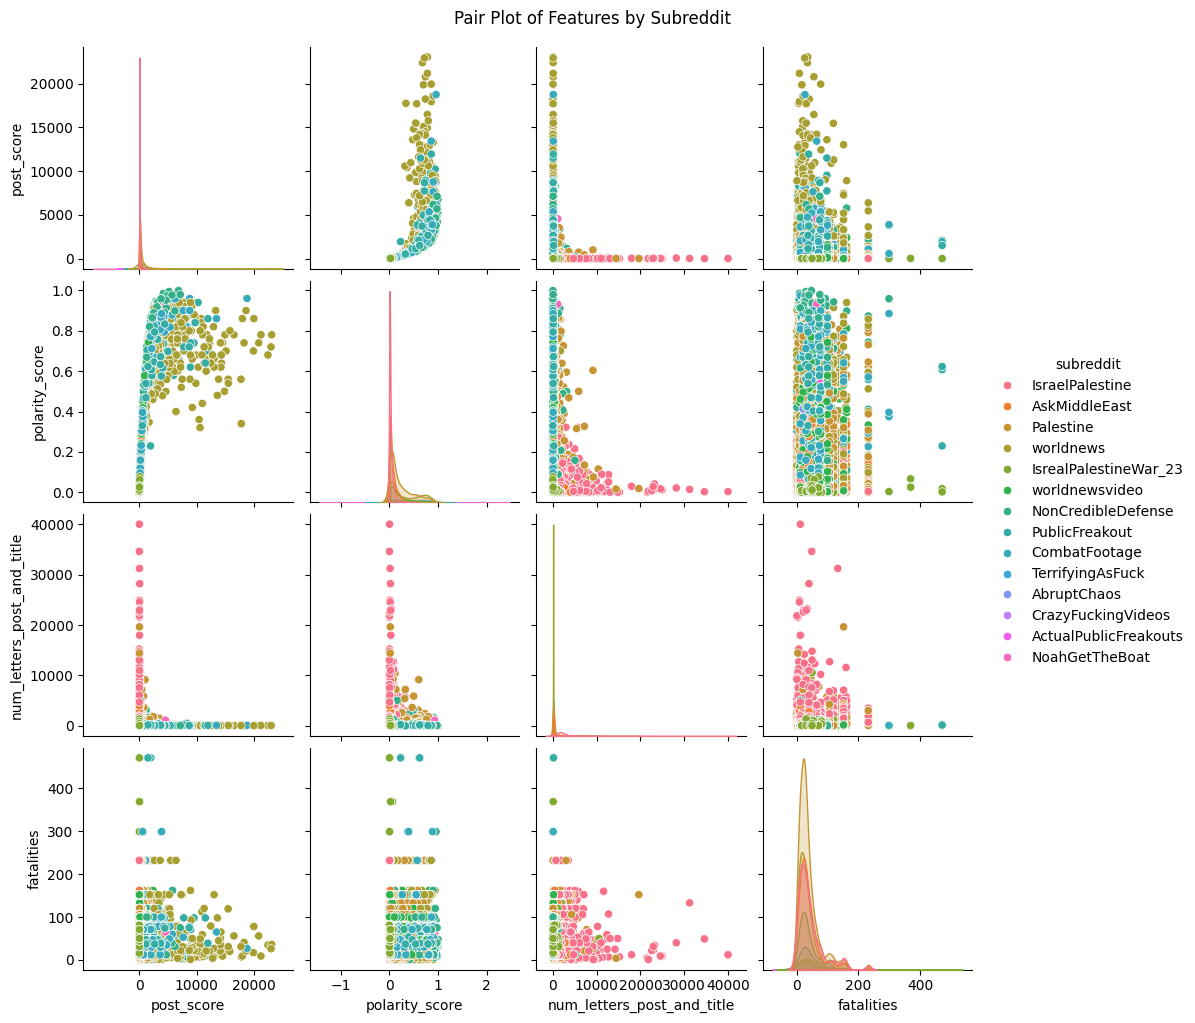

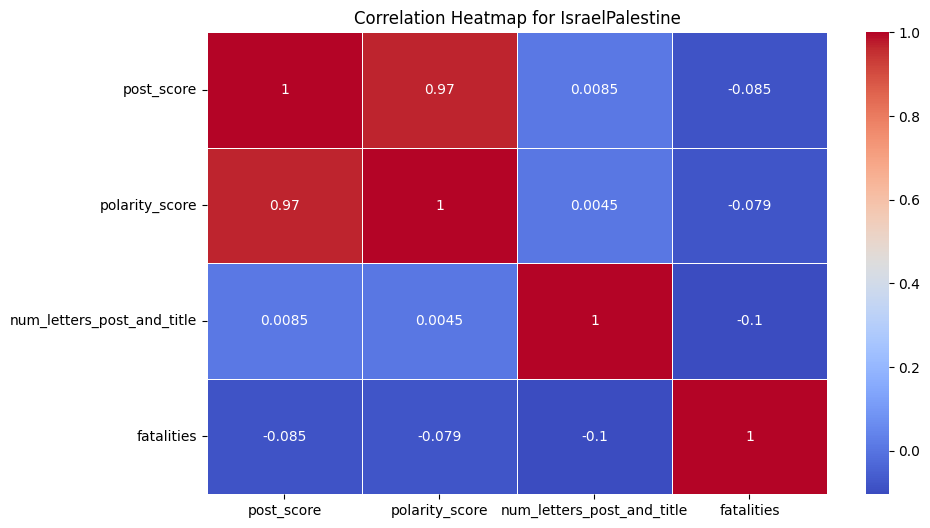

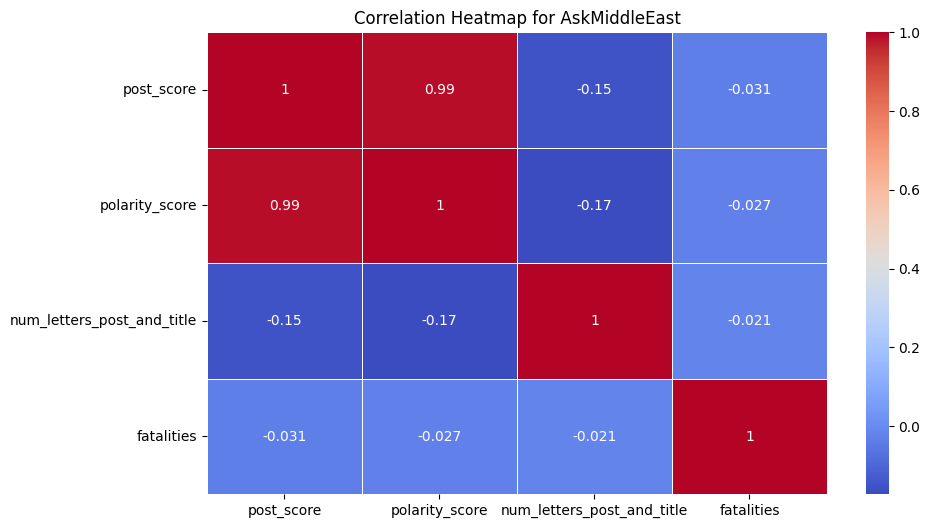

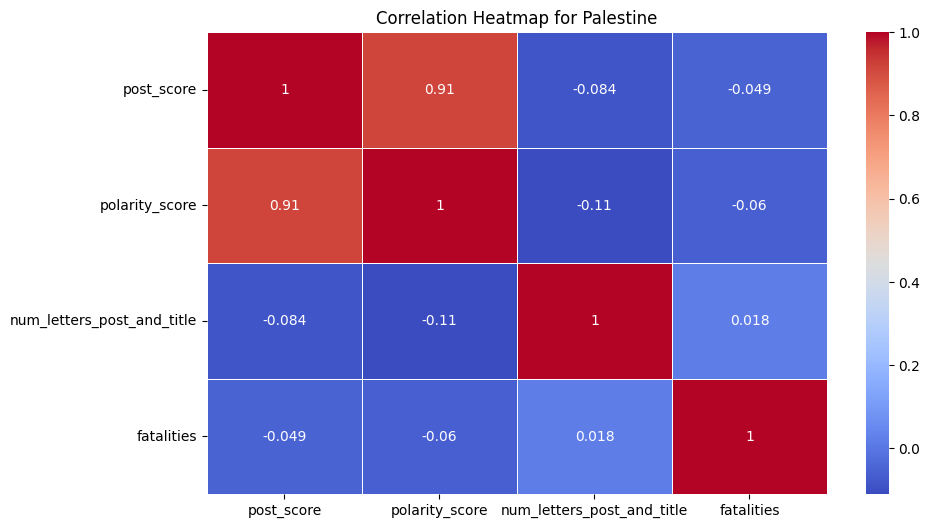

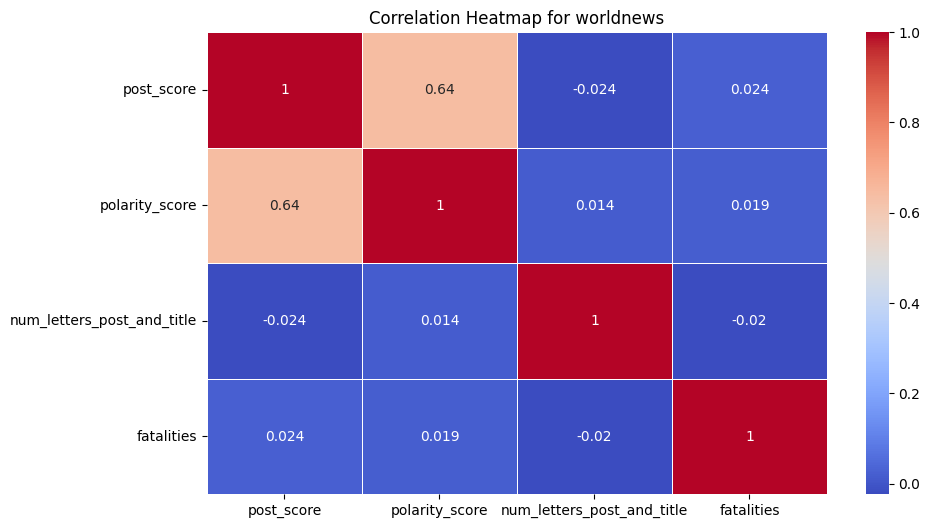

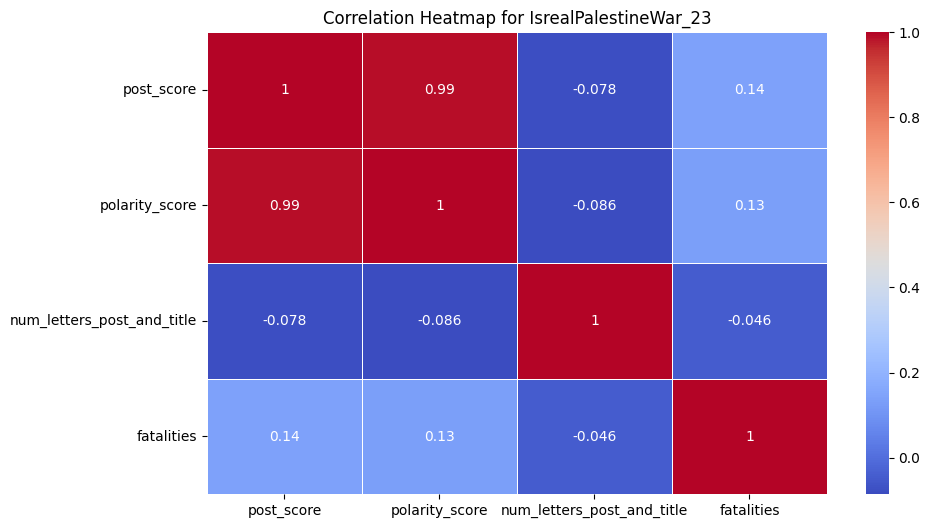

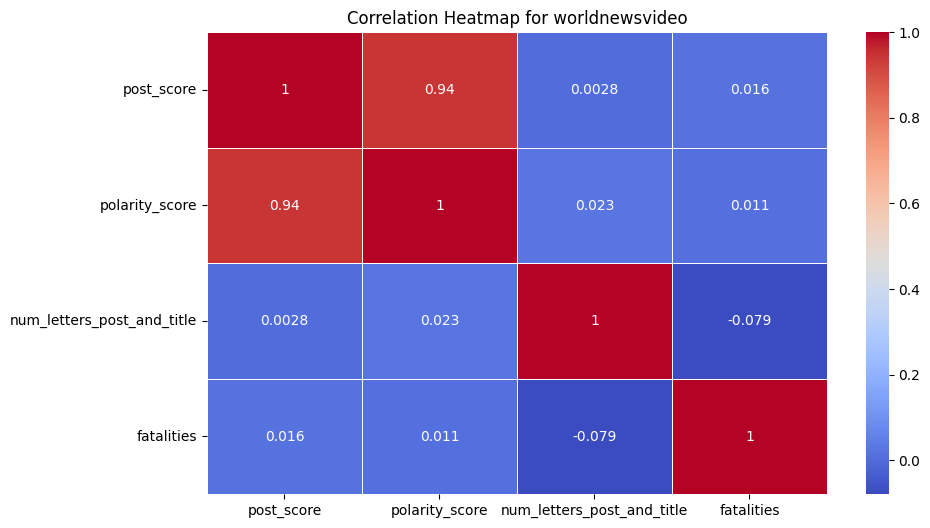

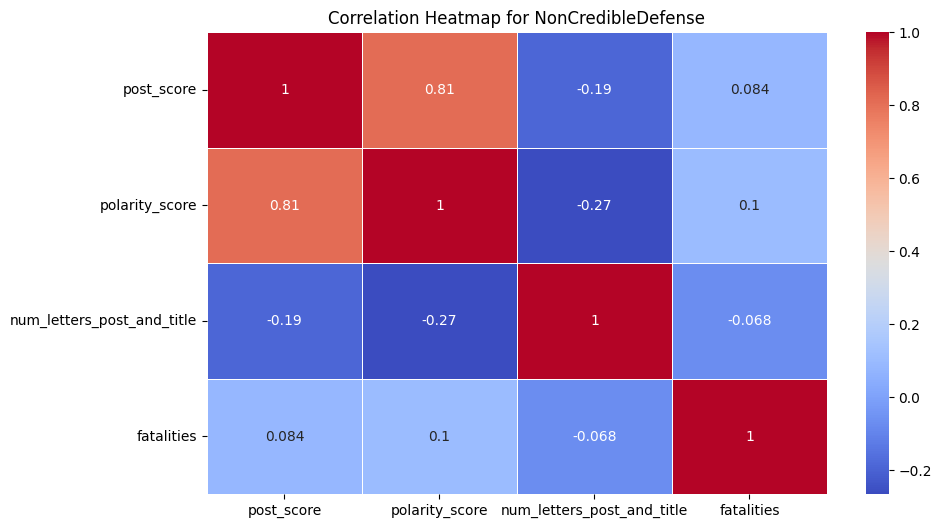

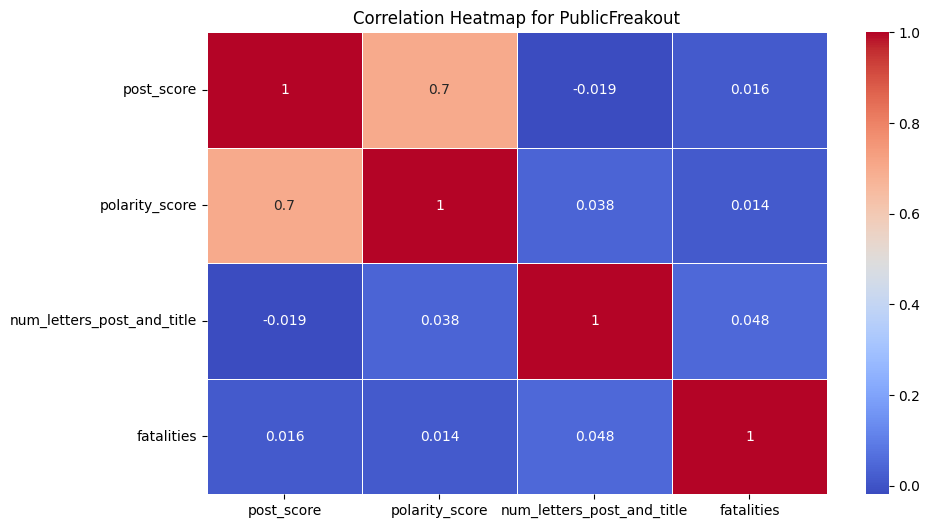

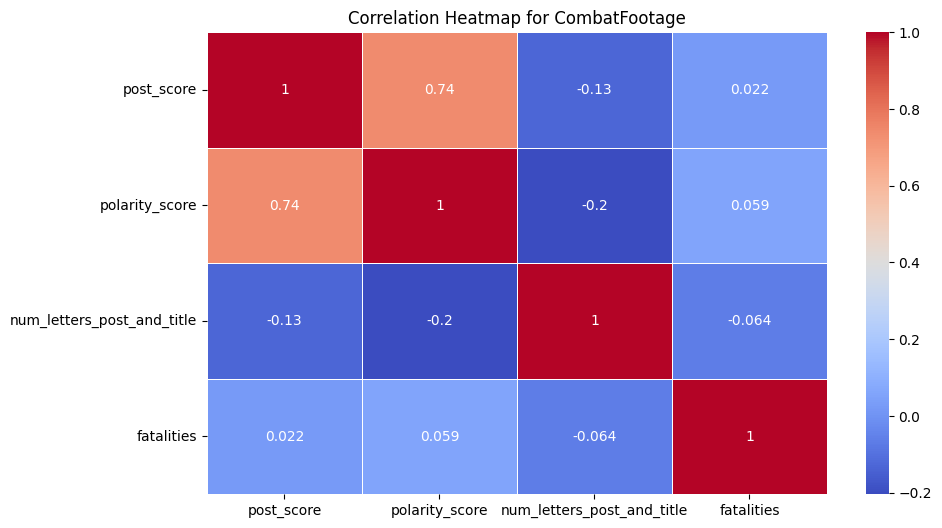

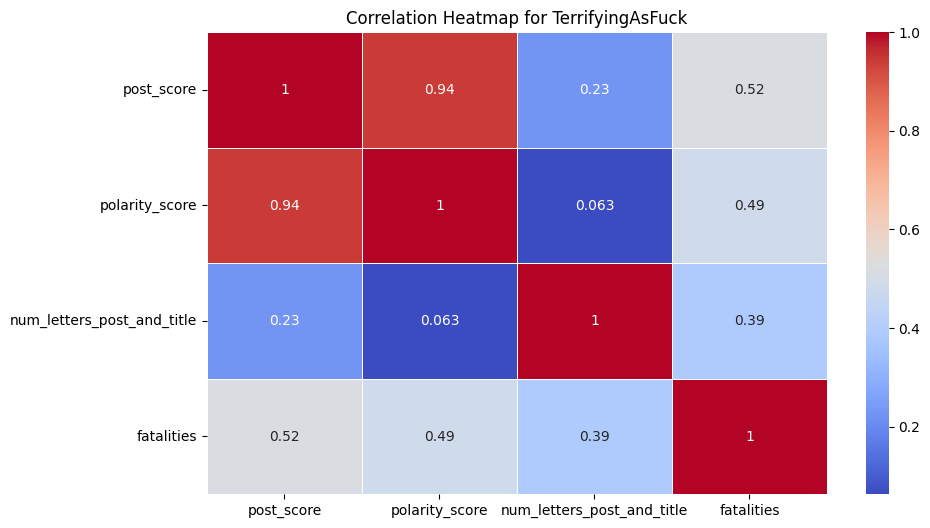

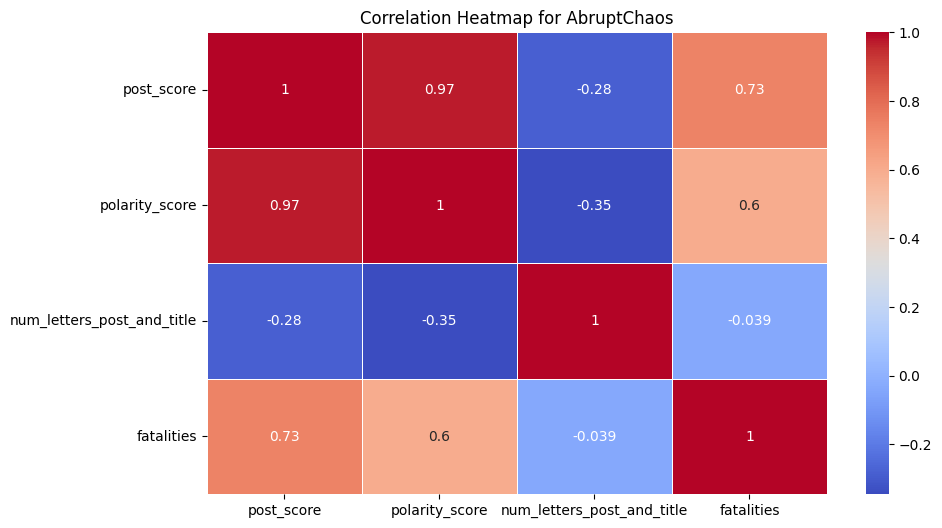

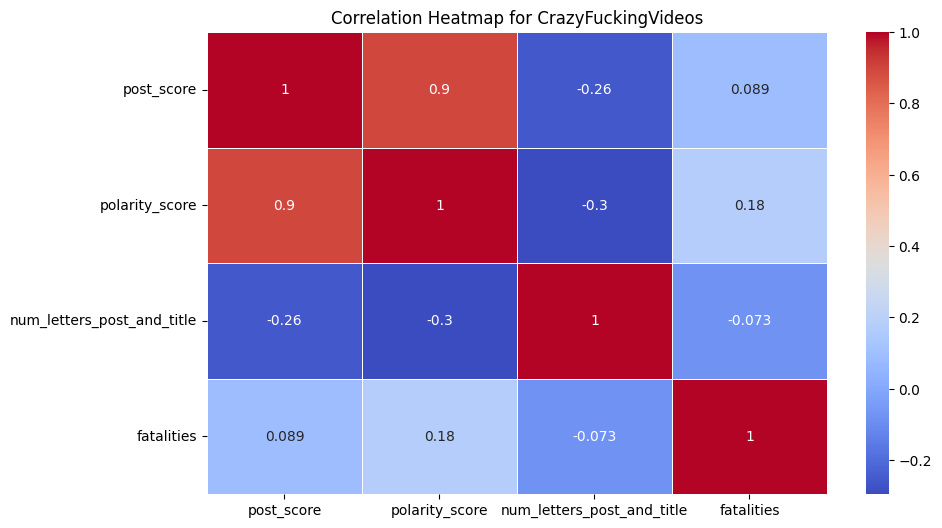

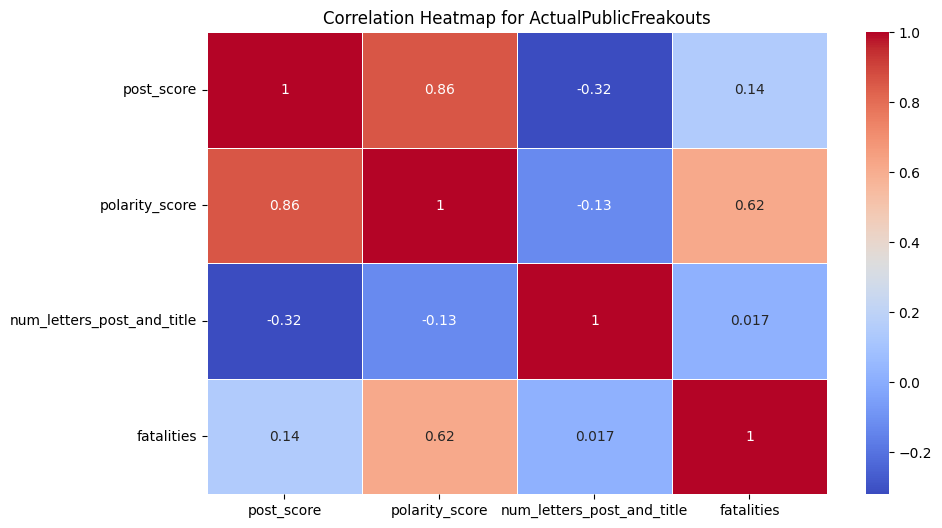

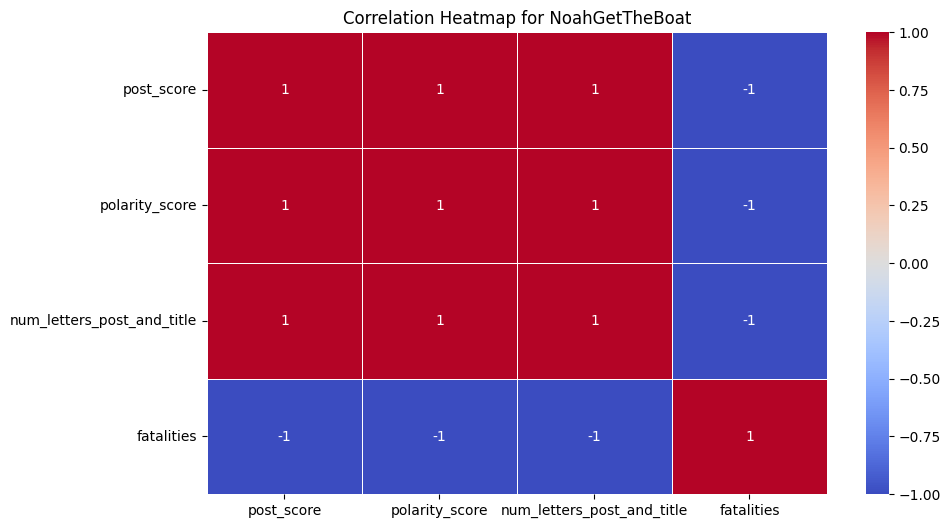

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv(output_directory / '10.datalowconfidence.csv')

# Convert post_created_time to datetime if not already
data['post_created_time'] = pd.to_datetime(data['post_created_time'])

# 1. Distribution Plots (Histograms) for Numeric Features
data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Numeric Features')
plt.show()

# 2. Box Plot for post_score by post_political_stance
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='post_score', data=data)
plt.title('Post Score by Post Political Stance')
plt.show()

# Boxplot for fatalities by post_political_stance
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='fatalities', data=data)
plt.title('Fatalities by Post Political Stance')
plt.show()

# 3. Pair Plot to Explore Pairwise Relationships
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'post_political_stance']], hue='post_political_stance')
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

# 4. Time Series Plot for Post Created Time vs. Post Score
plt.figure(figsize=(10, 6))
plt.plot(data['post_created_time'], data['post_score'], marker='o', linestyle='-', color='b')
plt.title('Post Score Over Time')
plt.xlabel('Post Created Time')
plt.ylabel('Post Score')
plt.xticks(rotation=45)
plt.show()

# 5. Violin Plot for Polarity Score by Political Stance
plt.figure(figsize=(10, 6))
sns.violinplot(x='post_political_stance', y='polarity_score', data=data)
plt.title('Polarity Score by Post Political Stance')
plt.show()

# 6. Box Plot to Compare Post Scores Across Subreddits
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='post_score', data=data)
plt.title('Post Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 7. Bar Plot for Average Polarity Score by Subreddit
plt.figure(figsize=(10, 6))
avg_polarity_by_subreddit = data.groupby('subreddit')['polarity_score'].mean().reset_index()
sns.barplot(x='subreddit', y='polarity_score', data=avg_polarity_by_subreddit)
plt.title('Average Polarity Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 8. Count Plot of Posts by Subreddit and Political Stance
plt.figure(figsize=(10, 6))
sns.countplot(x='subreddit', hue='post_political_stance', data=data)
plt.title('Count of Posts by Subreddit and Political Stance')
plt.xticks(rotation=45)
plt.show()

# 9. Violin Plot to Show the Distribution of Fatalities by Subreddit
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='fatalities', data=data)
plt.title('Distribution of Fatalities by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 10. Pair Plot Colored by Subreddit
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'subreddit']], hue='subreddit')
plt.suptitle('Pair Plot of Features by Subreddit', y=1.02)
plt.show()

# 11. Heatmap of Correlations for Each Subreddit
subreddits = data['subreddit'].unique()
for subreddit in subreddits:
    plt.figure(figsize=(10, 6))
    subreddit_data = data[data['subreddit'] == subreddit]
    correlation_matrix = subreddit_data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f"Correlation Heatmap for {subreddit}")
    plt.show()


# **Pre-Processing**

In [ ]:
import pandas as pd

# Load the dataset from the CSV file into a pandas DataFrame
raw_data = pd.read_csv(output_directory / '9.data_wo_neutral_stence.csv')

# Create a copy of the dataset for preprocessing
preprocessing_data = raw_data.copy()

# Remove the specified columns in one step
columns_to_remove = [
    'post_id', 'post_self_text', 'post_title', 'confidence_score',
    'all_labels', 'all_scores'
]
preprocessing_data.drop(columns=columns_to_remove, inplace=True)

# Convert 'post_created_time' to datetime and sort by subreddit and post_created_time
preprocessing_data['post_created_time'] = pd.to_datetime(preprocessing_data['post_created_time'])

# Step 1: Define a function to categorize each column into quantile-based bins (roughly equal-sized groups)
def categorize_column_quantiles(column, num_bins=3):
    # Use pandas qcut to categorize into equal-sized bins (quantiles)
    return pd.qcut(column, q=num_bins, labels=False, duplicates='drop')

# Step 2: Categorize the 'fatalities' and 'num_letters_post_and_title' columns into quantiles
preprocessing_data['fatalities'] = categorize_column_quantiles(preprocessing_data['fatalities'], num_bins=6)  # 6 bins for fatalities
preprocessing_data['num_letters_post_and_title'] = categorize_column_quantiles(preprocessing_data['num_letters_post_and_title'], num_bins=7)  # 7 bins for length

# Step 3: Categorize 'subreddit' by assigning a unique integer category for each unique name
preprocessing_data['subreddit'] = preprocessing_data['subreddit'].astype('category')

# Create and print the mapping between original subreddit names and their assigned numeric codes
subreddit_mapping = dict(enumerate(preprocessing_data['subreddit'].cat.categories))
print("Subreddit Mapping:")
for code, subreddit in subreddit_mapping.items():
    print(f"{code}: {subreddit}")

# Convert 'subreddit' to integer codes
preprocessing_data['subreddit'] = preprocessing_data['subreddit'].cat.codes

# Step 4: Categorize 'post_score' into quantiles with equal-sized bins
preprocessing_data['post_score'] = categorize_column_quantiles(preprocessing_data['post_score'], num_bins=5)  # 5 bins for post_score

# Step 5: Save the updated dataset with categorized columns
output_path = output_directory / '11.preprocessed_data_with_labels.csv'
preprocessing_data.to_csv(output_path, index=False)

# Display the first few rows of the updated data
print(preprocessing_data.head())


Subreddit Mapping:
0: ActualPublicFreakouts
1: AskMiddleEast
2: CombatFootage
3: IsraelPalestine
4: IsrealPalestineWar_23
5: NonCredibleDefense
6: Palestine
7: PublicFreakout
8: TerrifyingAsFuck
9: worldnews
10: worldnewsvideo
   subreddit  post_score  post_upvote_ratio  post_thumbs_ups  \
0          6           4               0.96             1679   
1          6           4               0.96             1679   
2          1           2               0.94              193   
3          1           2               0.94              193   
4          1           3               0.92              345   

   post_total_awards_received   post_created_time  post_political_stance  \
0                           0 2024-06-28 21:07:58                      1   
1                           0 2024-06-28 21:07:58                      1   
2                           0 2024-06-28 08:40:57                      1   
3                           0 2024-06-28 08:40:57                      1   
4       

## Visualization

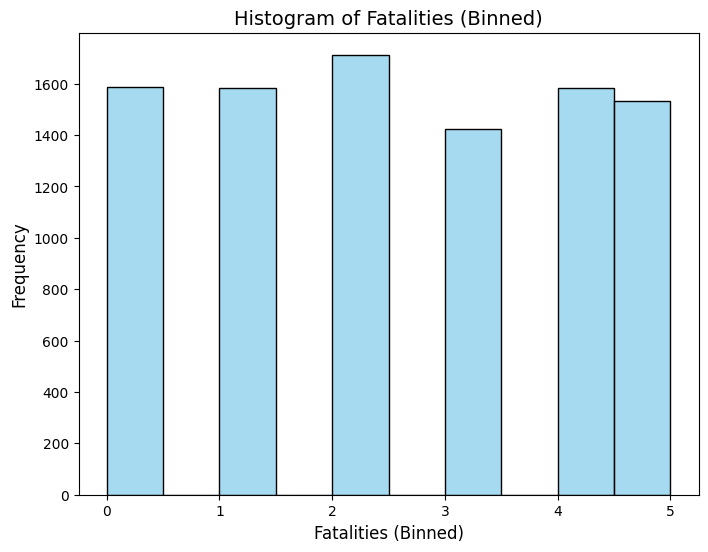

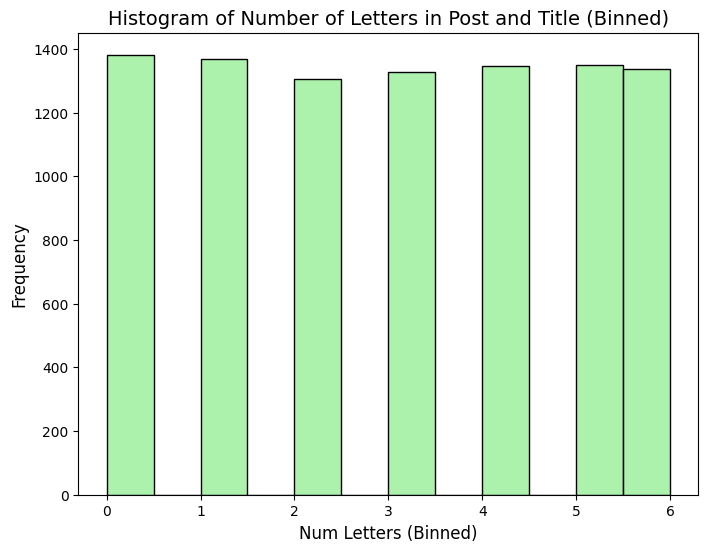

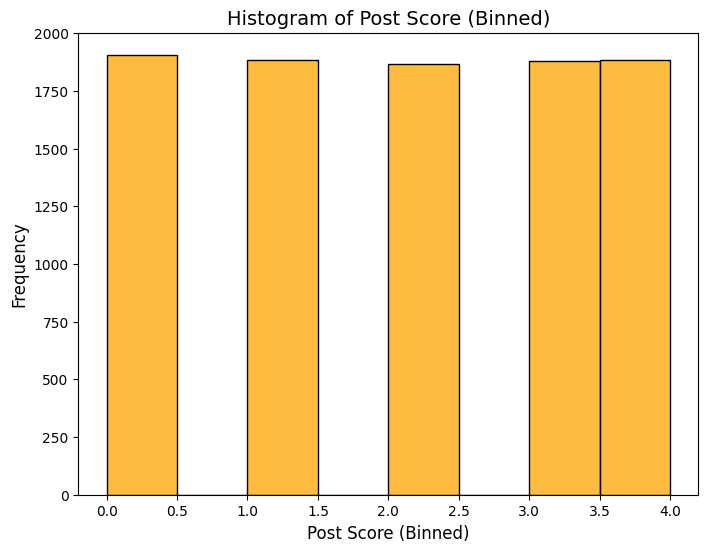

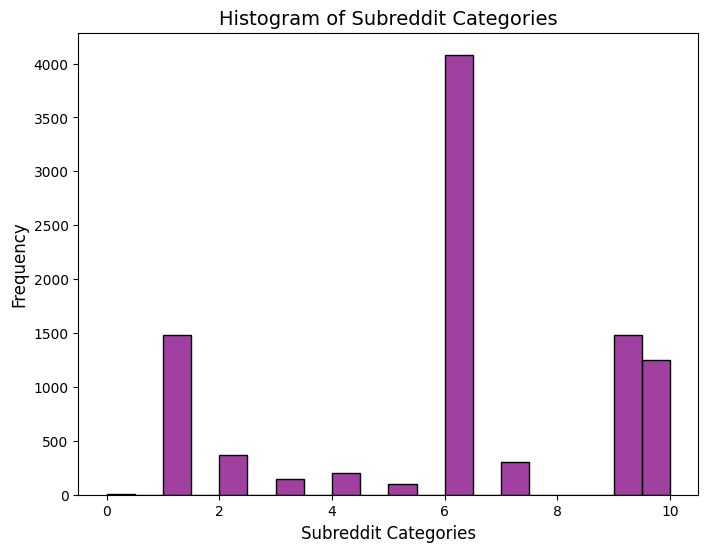

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
preprocessing_data = pd.read_csv(output_directory / '11.preprocessed_data_with_labels.csv')

# Create histograms for the key features after binning with narrower columns

# Histogram for 'fatalities'
plt.figure(figsize=(8, 6))
sns.histplot(preprocessing_data['fatalities'], binwidth=0.5, kde=False, color='skyblue')
plt.title('Histogram of Fatalities (Binned)', fontsize=14)
plt.xlabel('Fatalities (Binned)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Histogram for 'num_letters_post_and_title'
plt.figure(figsize=(8, 6))
sns.histplot(preprocessing_data['num_letters_post_and_title'], binwidth=0.5, kde=False, color='lightgreen')
plt.title('Histogram of Number of Letters in Post and Title (Binned)', fontsize=14)
plt.xlabel('Num Letters (Binned)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Histogram for 'post_score'
plt.figure(figsize=(8, 6))
sns.histplot(preprocessing_data['post_score'], binwidth=0.5, kde=False, color='orange')
plt.title('Histogram of Post Score (Binned)', fontsize=14)
plt.xlabel('Post Score (Binned)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Histogram for 'subreddit'
plt.figure(figsize=(8, 6))
sns.histplot(preprocessing_data['subreddit'], binwidth=0.5, kde=False, color='purple')
plt.title('Histogram of Subreddit Categories', fontsize=14)
plt.xlabel('Subreddit Categories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


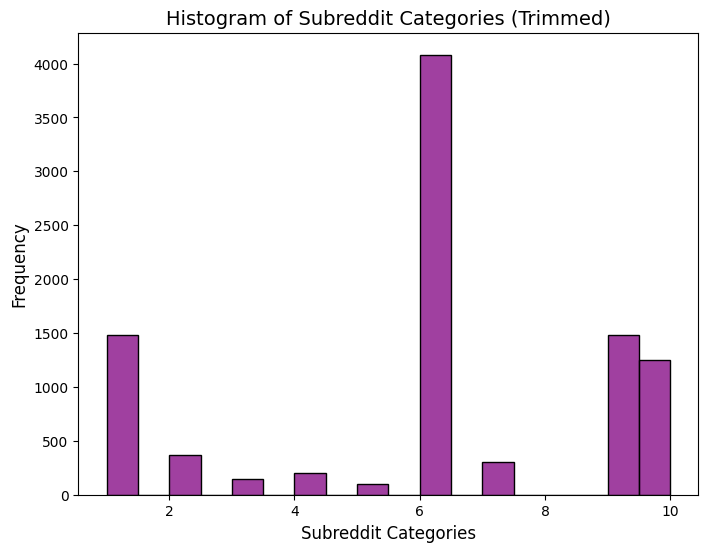

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the previously saved preprocessed dataset
preprocessing_data = pd.read_csv(output_directory / '11.preprocessed_data_with_labels.csv')

# Step 7: Trim the data by removing rows where 'subreddit' category is 0 or 8
trimmed_data = preprocessing_data[~preprocessing_data['subreddit'].isin([0, 8])]

# Step 8: Save the trimmed dataset
output_path_trimmed = output_directory / '11.preprocessed_data_with_labels.csv'
trimmed_data.to_csv(output_path_trimmed, index=False)

# Histogram for 'subreddit'
plt.figure(figsize=(8, 6))
sns.histplot(trimmed_data['subreddit'], binwidth=0.5, kde=False, color='purple')
plt.title('Histogram of Subreddit Categories (Trimmed)', fontsize=14)
plt.xlabel('Subreddit Categories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


# **Aggregation**

In [ ]:
import pandas as pd

# Load the preprocessed dataset (11.preprocessed_data_with_labels.csv)
file_path = output_directory / '11.preprocessed_data_with_labels.csv'
data_copy = pd.read_csv(file_path)

# Convert 'post_created_time' to datetime and sort by subreddit and post_created_time
data_copy['post_created_time'] = pd.to_datetime(data_copy['post_created_time'])
data_copy = data_copy.sort_values(by=['subreddit', 'post_created_time'])

# Create a group number every 5 posts within the same subreddit
data_copy['group_number'] = data_copy.groupby('subreddit').cumcount() // 5

# Group by subreddit and group_number, calculating mean for numeric columns
# and mode (most frequent date) for 'post_created_time'
aggregated_data = data_copy.groupby(['subreddit', 'group_number']).agg({
    'post_created_time': lambda x: x.mode()[0],  # Get the most frequent date
    'post_score': 'mean',  # Example of other numeric column aggregation
    'polarity_score': 'mean',
    'post_political_stance': 'mean',
    'num_letters_post_and_title': 'mean',
    'fatalities': 'mean'
}).reset_index()

# Step to adjust post_political_stance based on thresholds
upper_threshold = 0.7
lower_threshold = 0.3

# Set post_political_stance to 1 if it's above the upper threshold, 0 if it's below the lower threshold, and remove rows that are in between
aggregated_data = aggregated_data[
    (aggregated_data['post_political_stance'] > upper_threshold) |
    (aggregated_data['post_political_stance'] < lower_threshold)
]

# Assign 1 or 0 based on thresholds
aggregated_data['post_political_stance'] = aggregated_data['post_political_stance'].apply(
    lambda x: 1 if x > upper_threshold else 0 if x < lower_threshold else None
)

# Step 1: Define a function to categorize each column into quantile-based bins (roughly equal-sized groups)
def categorize_column_quantiles(column, num_bins):
    # Use pandas qcut to categorize into equal-sized bins (quantiles)
    return pd.qcut(column, q=num_bins, labels=False, duplicates='drop')

# Step 2: Apply the categorization to 'fatalities', 'num_letters_post_and_title', and 'post_score'
# Use the specified number of bins from the original script
aggregated_data['fatalities'] = categorize_column_quantiles(aggregated_data['fatalities'], num_bins=6)  # 6 bins for fatalities
aggregated_data['num_letters_post_and_title'] = categorize_column_quantiles(aggregated_data['num_letters_post_and_title'], num_bins=7)  # 7 bins for post length
aggregated_data['post_score'] = categorize_column_quantiles(aggregated_data['post_score'], num_bins=5)  # 5 bins for post score

# Save the filtered, adjusted, and categorized dataset to a new CSV file (12.aggregated.csv)
output_path = output_directory / '12.aggregated.csv'
aggregated_data.to_csv(output_path, index=False)

# View the first few rows of the new aggregated and categorized dataset
print(aggregated_data.head())


    subreddit  group_number   post_created_time  post_score  polarity_score  \
3           1             3 2023-11-07 10:28:54           0        0.041946   
5           1             5 2023-11-08 09:02:55           0        0.029007   
6           1             6 2023-11-08 17:41:50           0        0.104445   
8           1             8 2023-11-09 11:03:14           0        0.057599   
10          1            10 2023-11-10 14:45:04           1        0.138581   

    post_political_stance  num_letters_post_and_title  fatalities  
3                       1                           5           4  
5                       1                           6           4  
6                       0                           1           4  
8                       0                           4           5  
10                      0                           1           4  


## Data Visualization - after aggregation

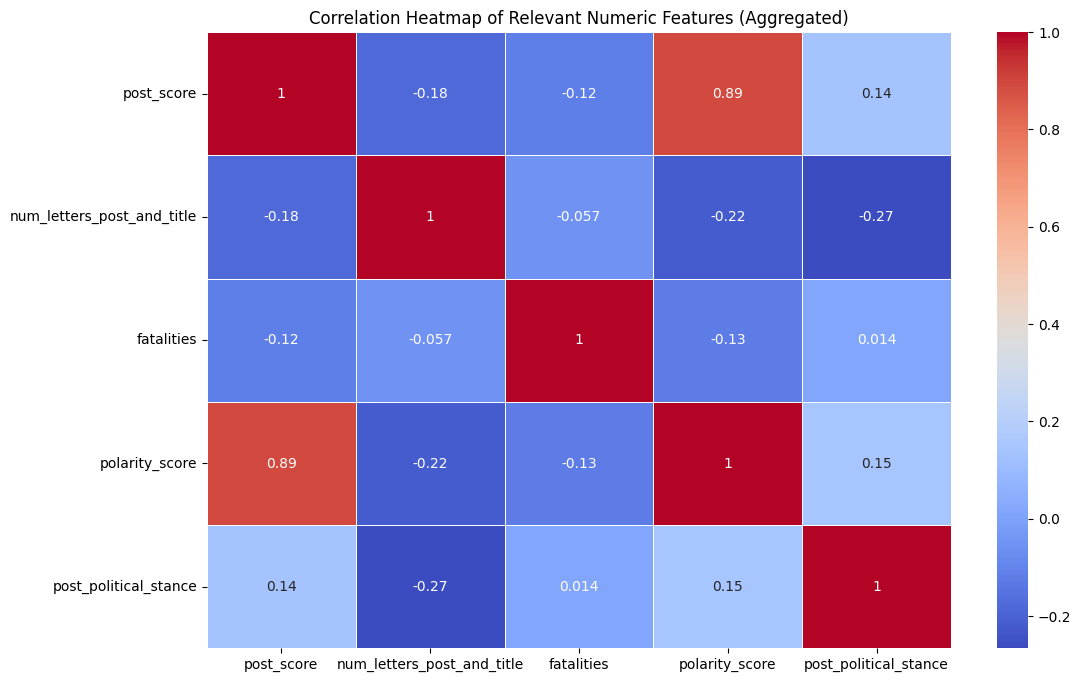

In [ ]:
# Load the dataset
file_path = output_directory / '12.aggregated.csv'
data = pd.read_csv(file_path)

relevant_features = [
    'post_score',
    'num_letters_post_and_title',
    'fatalities',
    'polarity_score',
    'post_political_stance'  # Include political stance as a feature
]

# Calculate the correlation matrix
correlation_matrix = data[relevant_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Relevant Numeric Features (Aggregated)")
plt.show()

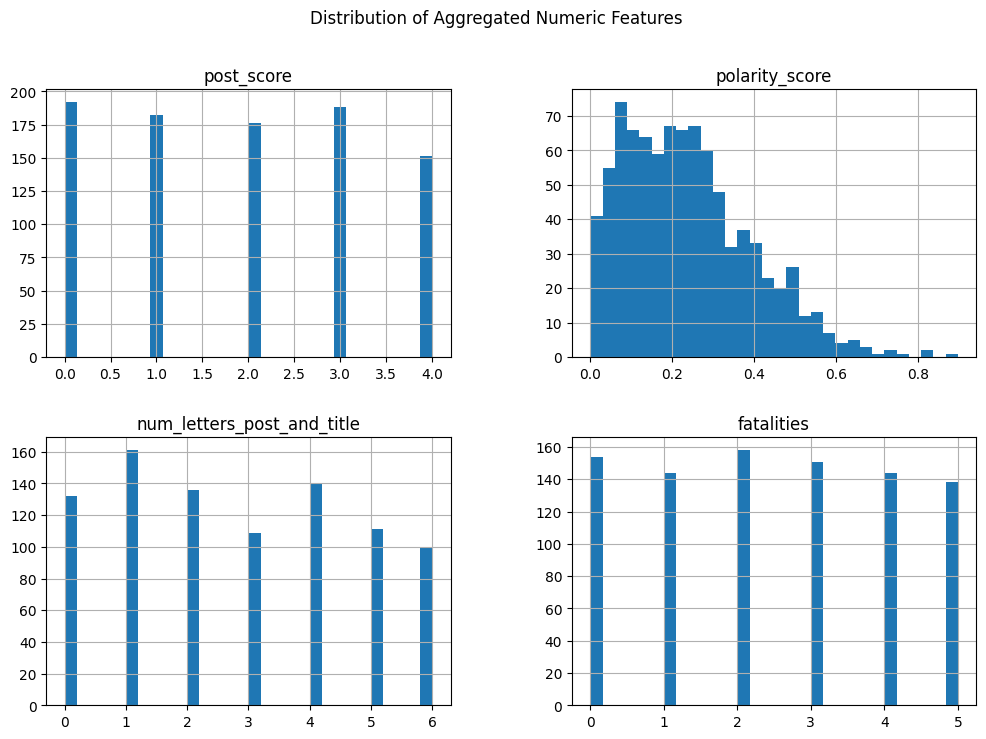

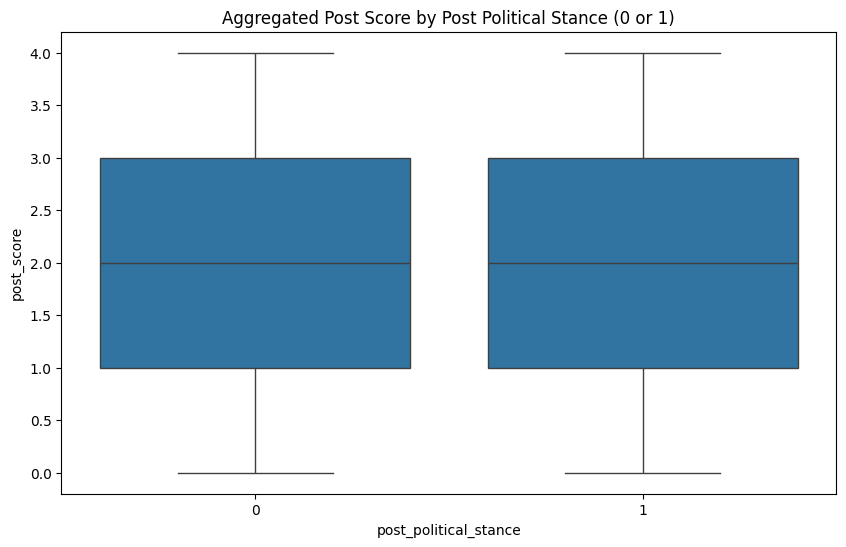

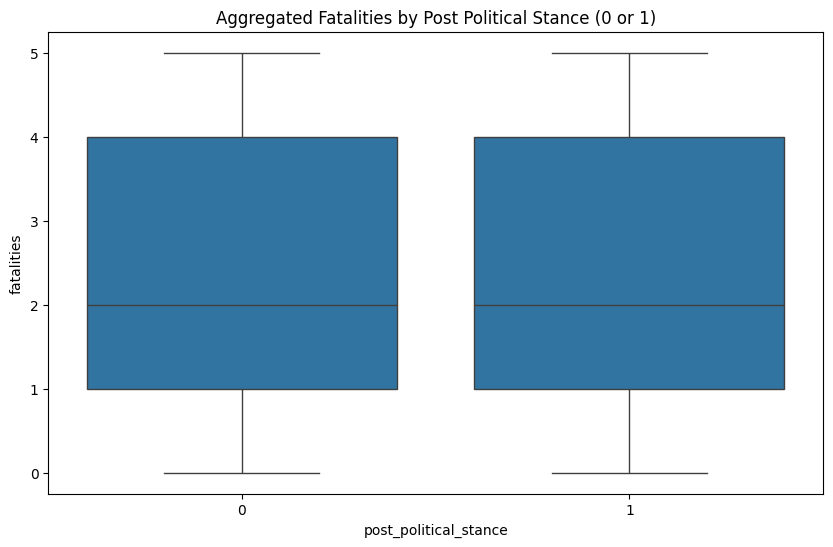

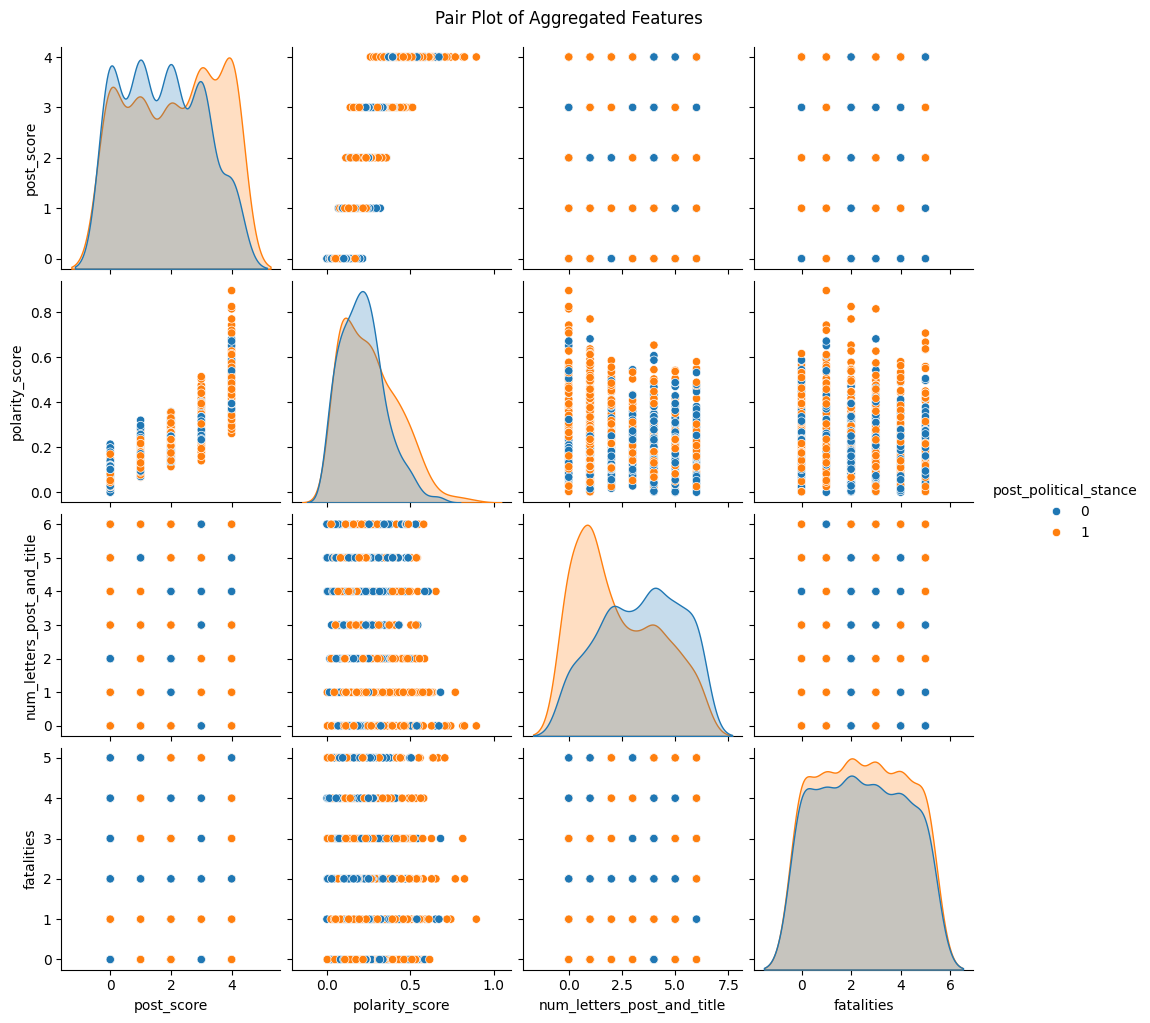

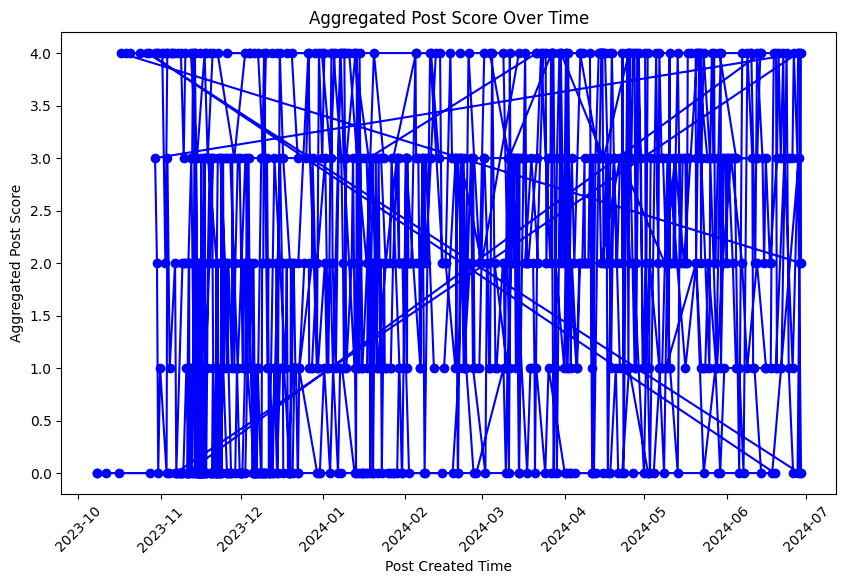

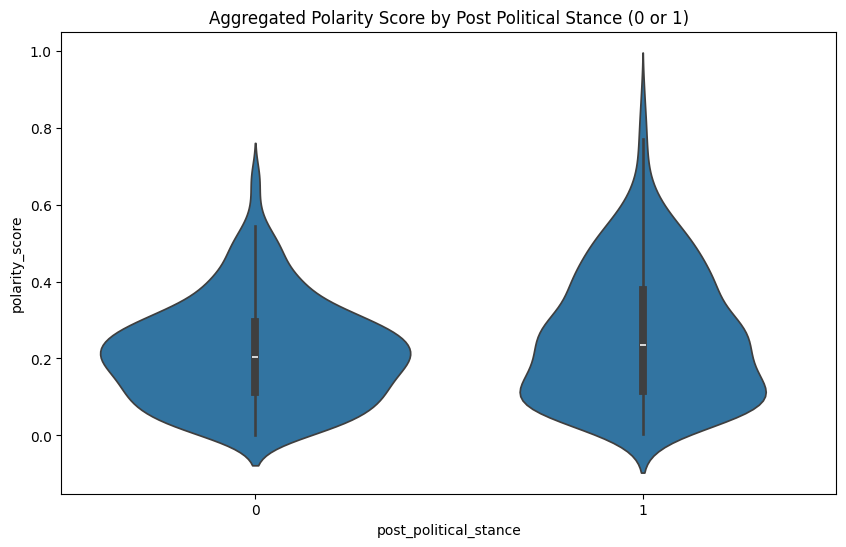

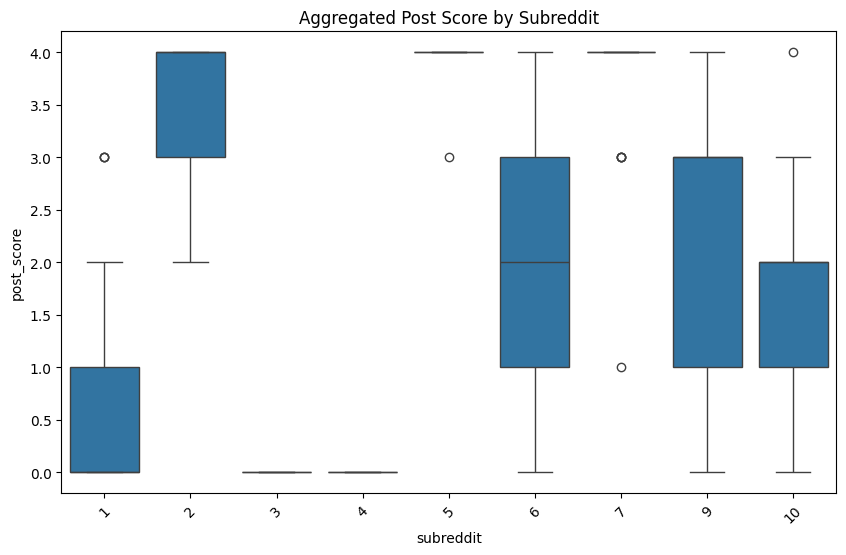

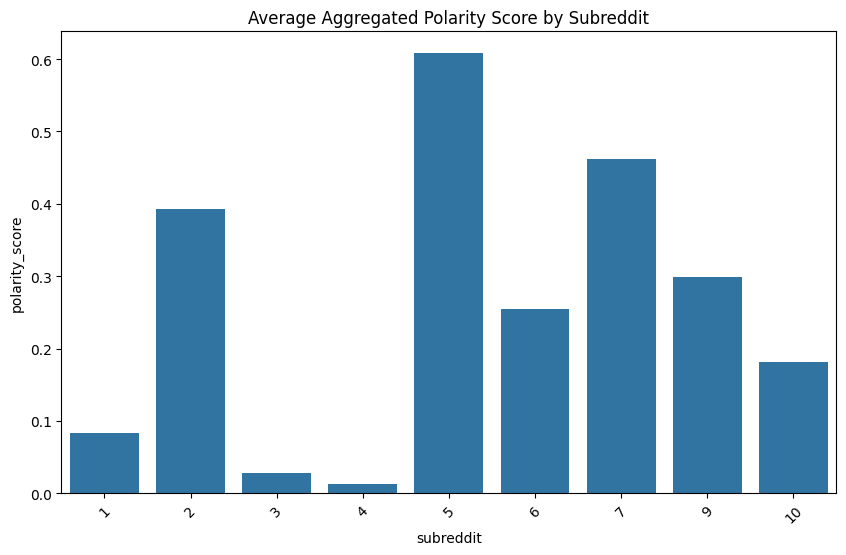

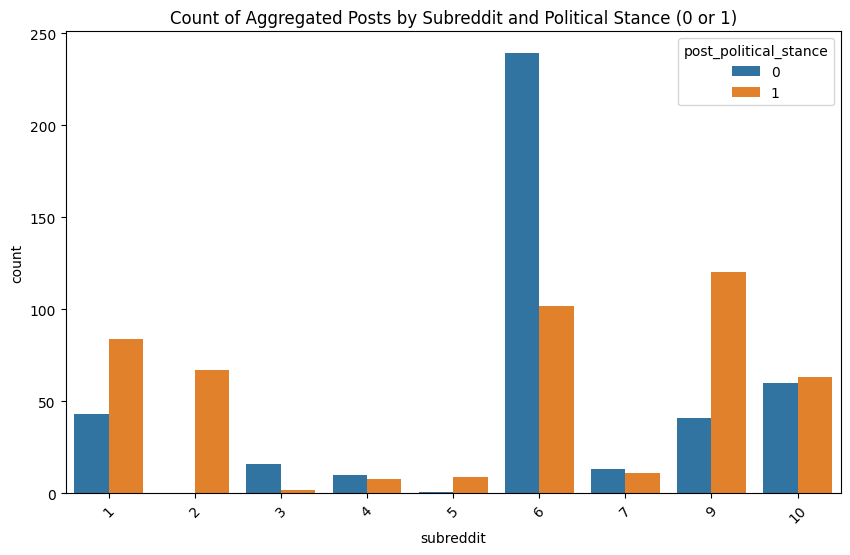

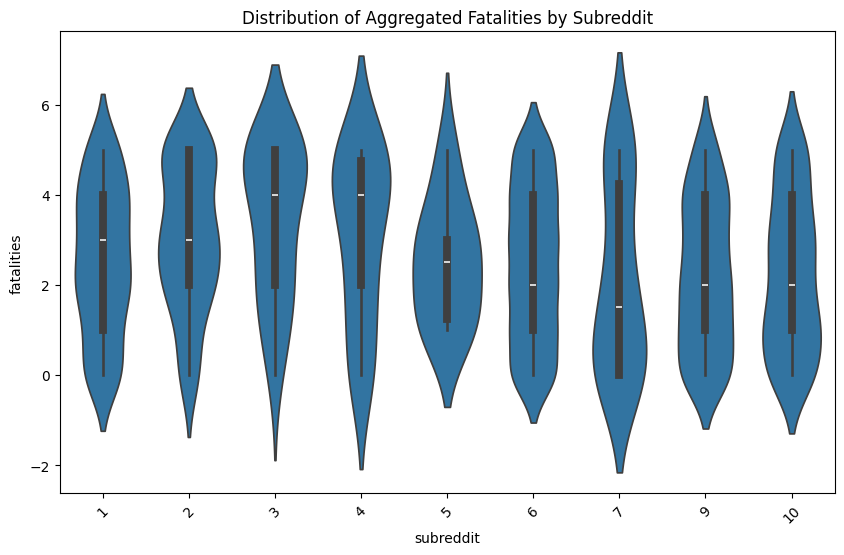

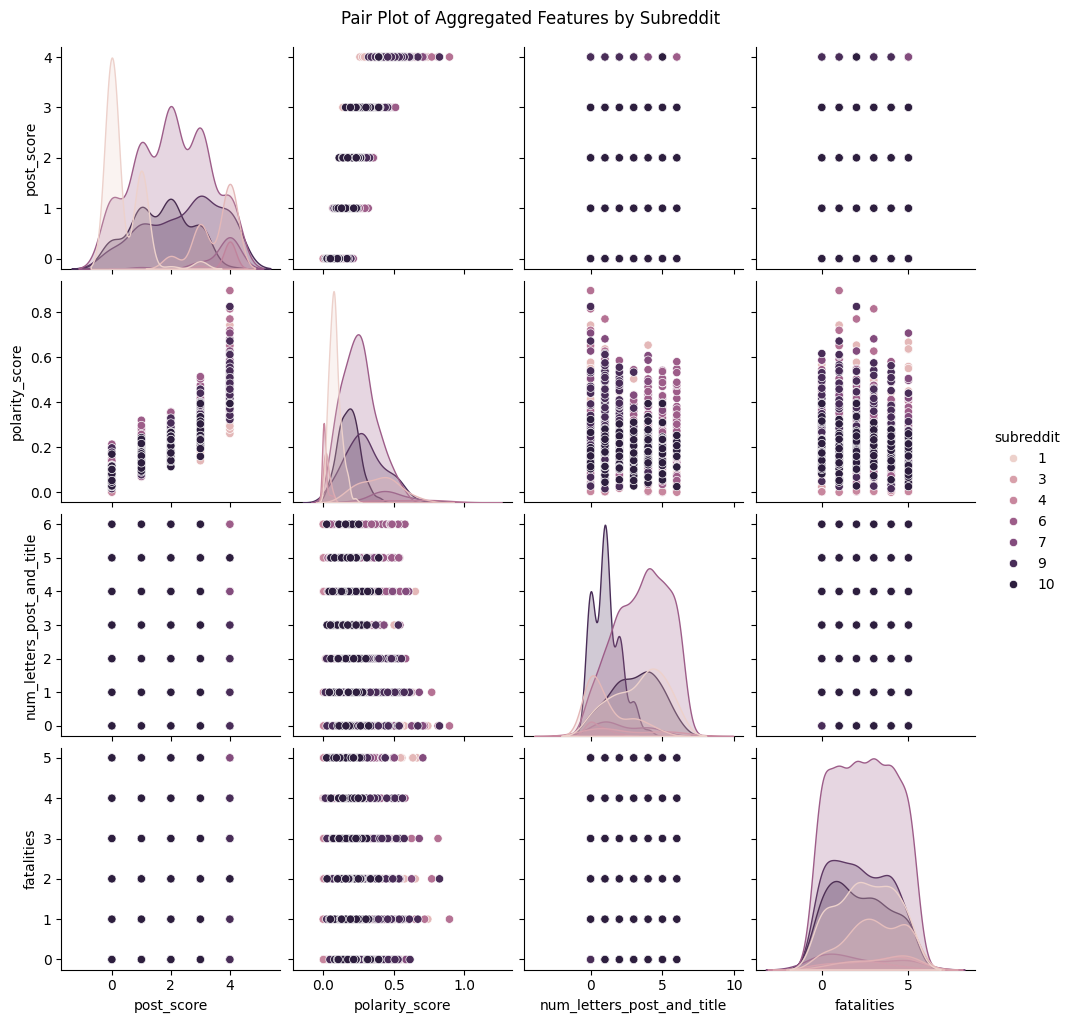

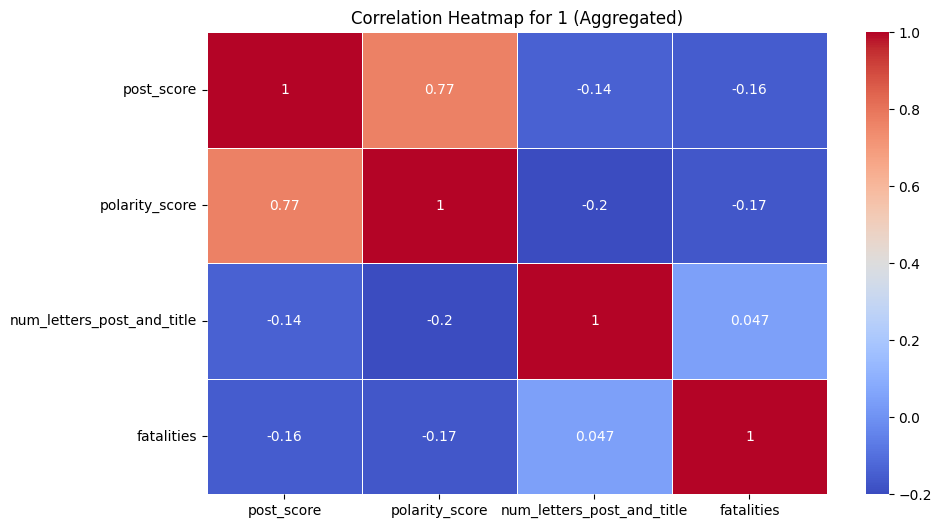

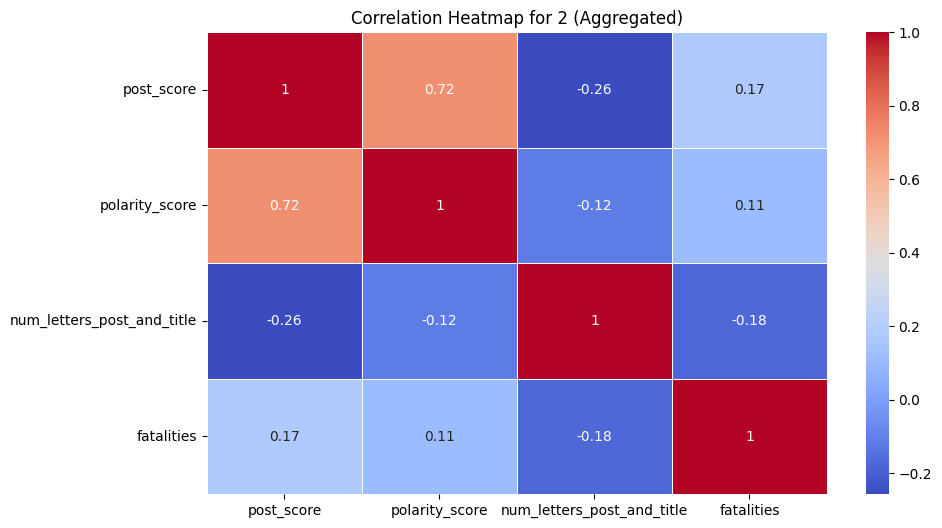

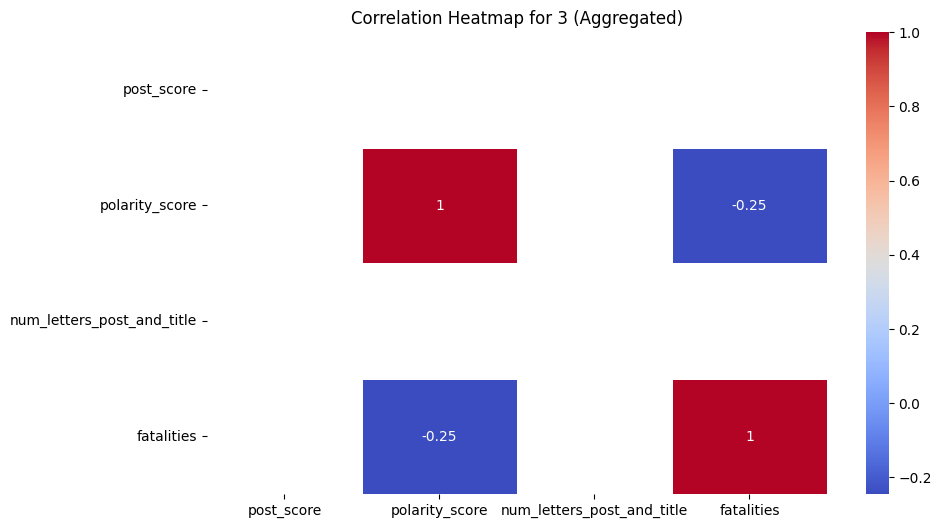

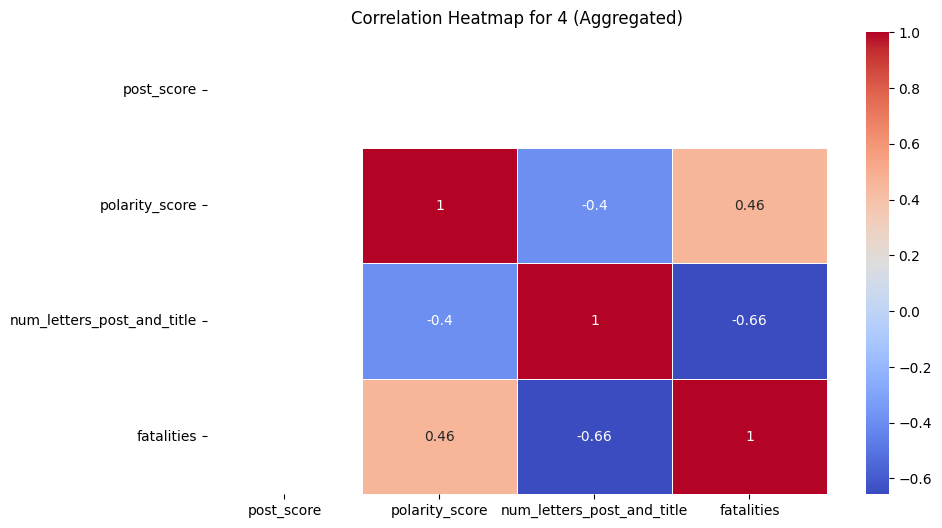

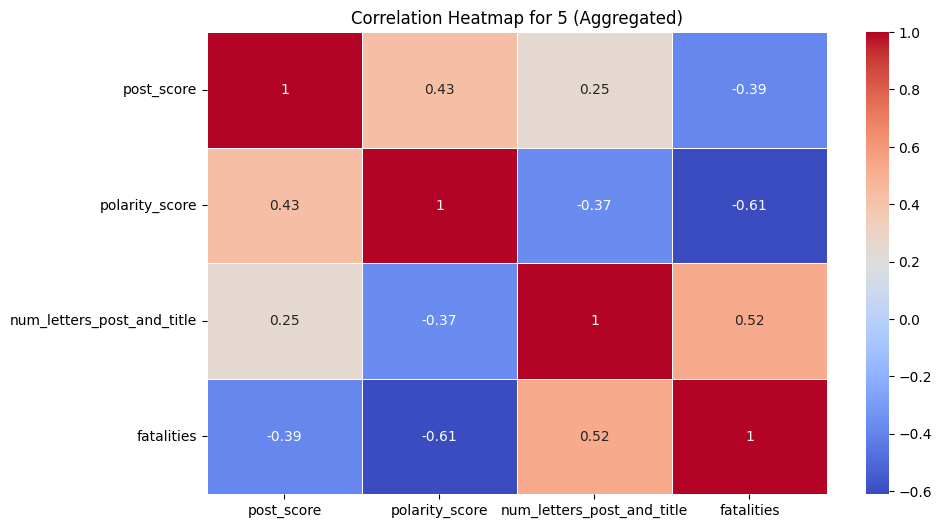

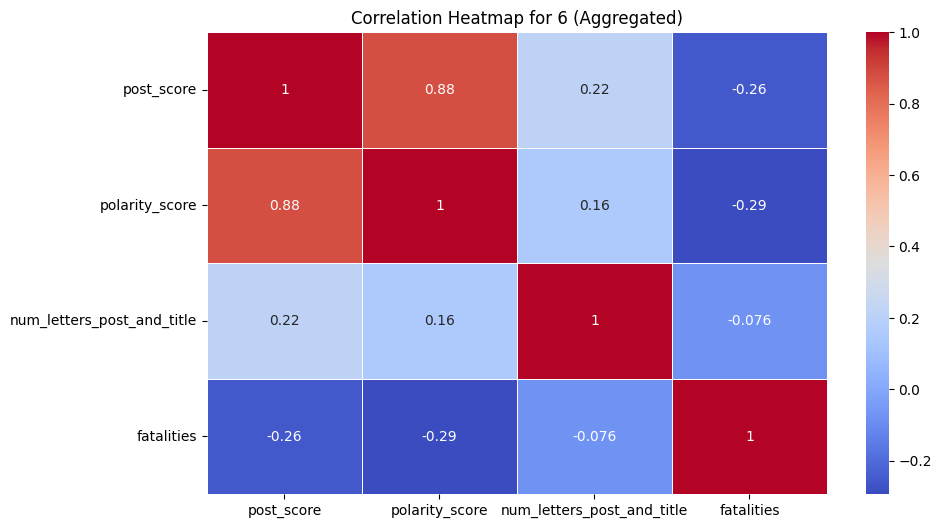

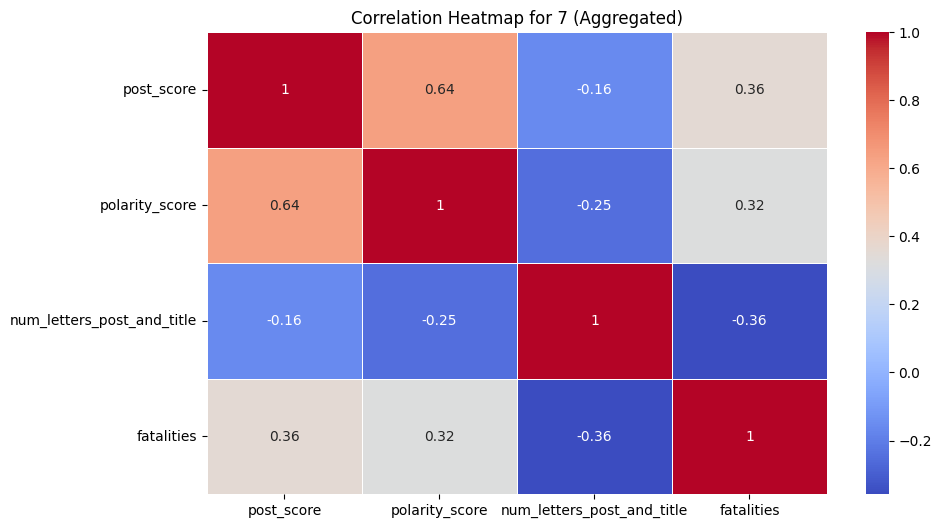

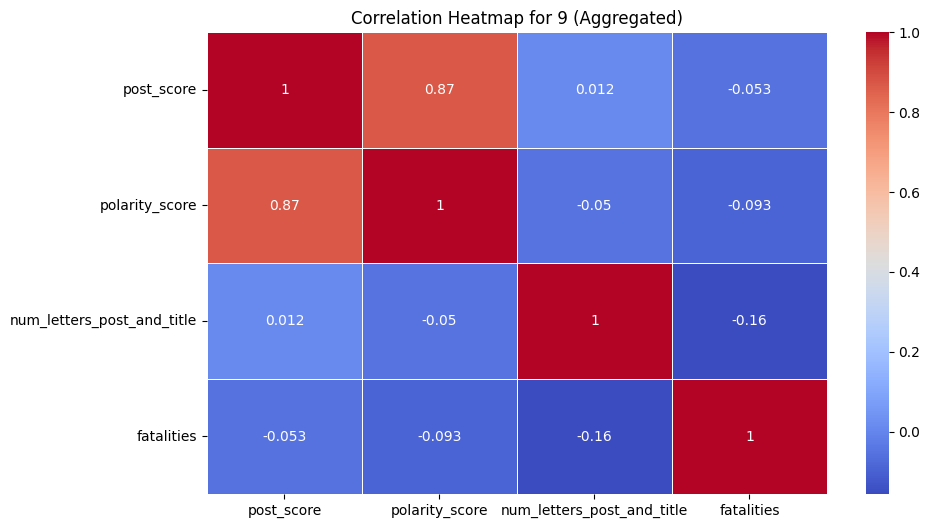

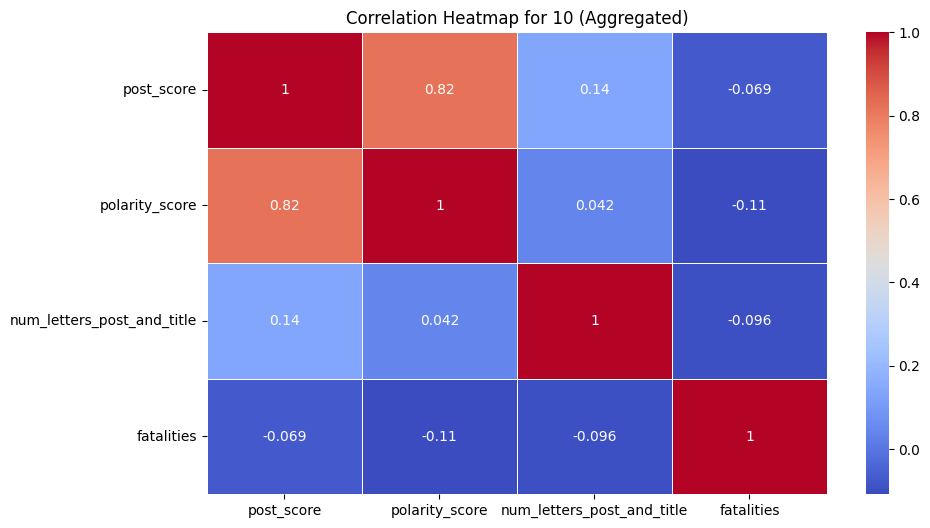

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv(output_directory / '12.aggregated.csv')

# Convert post_created_time to datetime if not already
data['post_created_time'] = pd.to_datetime(data['post_created_time'])

# 1. Distribution Plots (Histograms) for Aggregated Numeric Features
data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribution of Aggregated Numeric Features')
plt.show()

# 2. Box Plot for post_score by post_political_stance (binary stance: 0 or 1)
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='post_score', data=data)
plt.title('Aggregated Post Score by Post Political Stance (0 or 1)')
plt.show()

# Boxplot for fatalities by post_political_stance
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='fatalities', data=data)
plt.title('Aggregated Fatalities by Post Political Stance (0 or 1)')
plt.show()

# 3. Pair Plot to Explore Pairwise Relationships in Aggregated Data
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'post_political_stance']], hue='post_political_stance')
plt.suptitle('Pair Plot of Aggregated Features', y=1.02)
plt.show()

# 4. Time Series Plot for Post Created Time vs. Aggregated Post Score
plt.figure(figsize=(10, 6))
plt.plot(data['post_created_time'], data['post_score'], marker='o', linestyle='-', color='b')
plt.title('Aggregated Post Score Over Time')
plt.xlabel('Post Created Time')
plt.ylabel('Aggregated Post Score')
plt.xticks(rotation=45)
plt.show()

# 5. Violin Plot for Polarity Score by Political Stance in Aggregated Data (binary stance)
plt.figure(figsize=(10, 6))
sns.violinplot(x='post_political_stance', y='polarity_score', data=data)
plt.title('Aggregated Polarity Score by Post Political Stance (0 or 1)')
plt.show()

# 6. Box Plot to Compare Aggregated Post Scores Across Subreddits
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='post_score', data=data)
plt.title('Aggregated Post Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 7. Bar Plot for Average Aggregated Polarity Score by Subreddit
plt.figure(figsize=(10, 6))
avg_polarity_by_subreddit = data.groupby('subreddit')['polarity_score'].mean().reset_index()
sns.barplot(x='subreddit', y='polarity_score', data=avg_polarity_by_subreddit)
plt.title('Average Aggregated Polarity Score by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 8. Count Plot of Aggregated Posts by Subreddit and Political Stance (binary stance)
plt.figure(figsize=(10, 6))
sns.countplot(x='subreddit', hue='post_political_stance', data=data)
plt.title('Count of Aggregated Posts by Subreddit and Political Stance (0 or 1)')
plt.xticks(rotation=45)
plt.show()

# 9. Violin Plot to Show the Distribution of Aggregated Fatalities by Subreddit
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='fatalities', data=data)
plt.title('Distribution of Aggregated Fatalities by Subreddit')
plt.xticks(rotation=45)
plt.show()

# 10. Pair Plot Colored by Subreddit for Aggregated Data
sns.pairplot(data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities', 'subreddit']], hue='subreddit')
plt.suptitle('Pair Plot of Aggregated Features by Subreddit', y=1.02)
plt.show()

# 11. Heatmap of Correlations for Each Subreddit in Aggregated Data
subreddits = data['subreddit'].unique()
for subreddit in subreddits:
    plt.figure(figsize=(10, 6))
    subreddit_data = data[data['subreddit'] == subreddit]
    correlation_matrix = subreddit_data[['post_score', 'polarity_score', 'num_letters_post_and_title', 'fatalities']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f"Correlation Heatmap for {subreddit} (Aggregated)")
    plt.show()


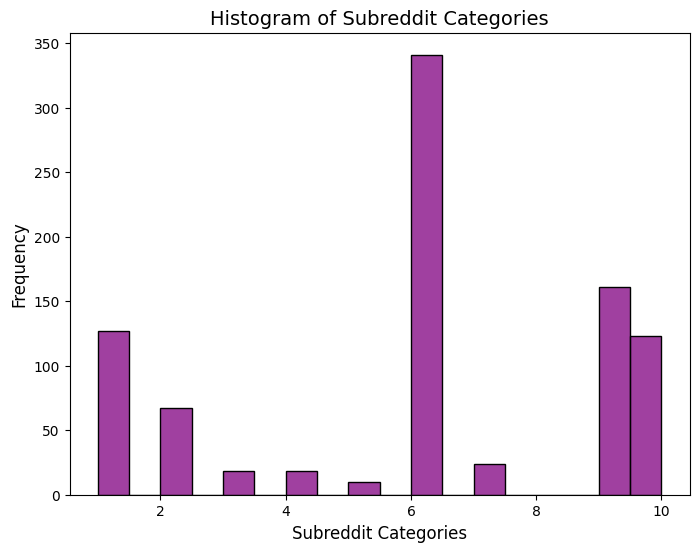

In [ ]:
import pandas as pd

# Load the previously saved dataset
aggregated_data = pd.read_csv(output_directory / '12.aggregated.csv')

# Step 7: Trim the data by removing rows where 'subreddit' category is 0 or 8
trimmed_data = aggregated_data[~aggregated_data['subreddit'].isin([0, 8])]

# Step 8: Save the trimmed dataset
output_path_trimmed = output_directory / '12.5aggregated_trimmed.csv'
trimmed_data.to_csv(output_path_trimmed, index=False)

# Histogram for 'subreddit'
plt.figure(figsize=(8, 6))
sns.histplot(trimmed_data['subreddit'], binwidth=0.5, kde=False, color='purple')
plt.title('Histogram of Subreddit Categories', fontsize=14)
plt.xlabel('Subreddit Categories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


# **Causal Analysis - Before Aggregation**

## *Propensity Score*


In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load the dataset (preprocessed, not aggregated)
file_path = output_directory / '11.preprocessed_data_with_labels.csv'
data = pd.read_csv(file_path)

# Step 1: Ensure the treatment is already binary in 'post_political_stance'
# No need to binarize again as 'post_political_stance' is already 0 or 1

# Step 2: Define the covariates (X)
covariates = ['subreddit', 'post_score', 'fatalities', 'num_letters_post_and_title']
X = pd.get_dummies(data[covariates], drop_first=True)

# Step 3: Define the treatment (y) as binary ('post_political_stance')
y = data['post_political_stance']

# Step 4: Fit a logistic regression model (binary logistic regression)
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(X, y)

# Step 5: Calculate the propensity scores (predicted probabilities)
data['propensity_score'] = logistic_reg.predict_proba(X)[:, 1]  # Propensity score for being in treatment 1

# Step 6: Trimming - Remove observations with extreme propensity scores
lower_trim = 0.2  # Set lower bound for trimming
upper_trim = 0.8  # Set upper bound for trimming

# Keep only data within the trimming thresholds
trimmed_data = data[(data['propensity_score'] >= lower_trim) & (data['propensity_score'] <= upper_trim)]

# Step 7: Save the trimmed dataset with propensity scores
output_path_trimmed = output_directory / '11.1preprocessed_data_with_propensity.csv'
trimmed_data.to_csv(output_path_trimmed, index=False)

# Display the first few rows of the trimmed data to verify
print(trimmed_data[['post_political_stance', 'propensity_score']].head())


   post_political_stance  propensity_score
0                      1          0.572807
1                      1          0.572807
2                      1          0.585941
3                      1          0.585941
4                      1          0.530943


### Visualization

<ipython-input-81-4ce20e8e20e2>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data.loc[data['post_political_stance'] == i, 'propensity_score'], shade=True, label=f'Treatment {i}')
<ipython-input-81-4ce20e8e20e2>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data.loc[data['post_political_stance'] == i, 'propensity_score'], shade=True, label=f'Treatment {i}')


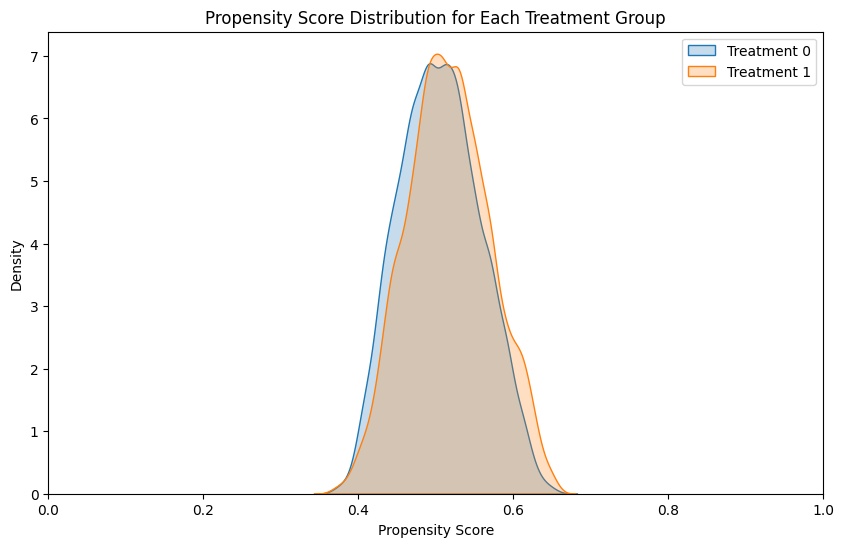

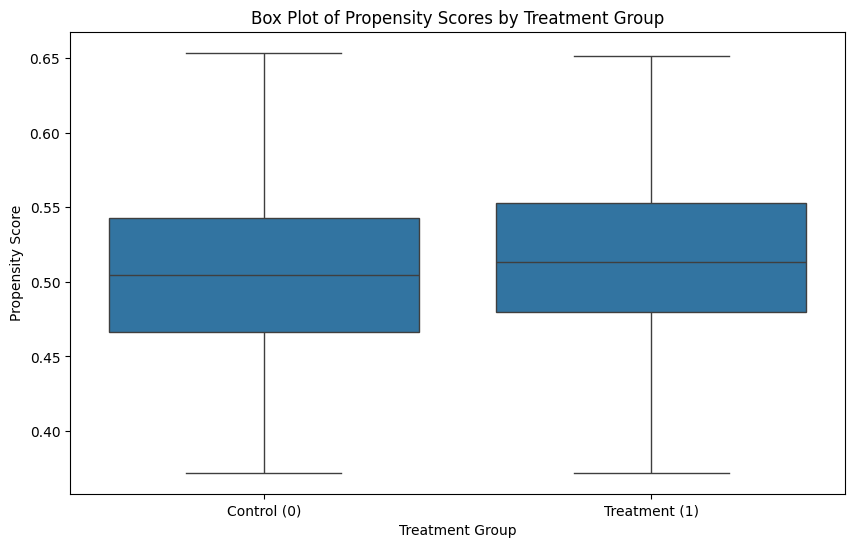

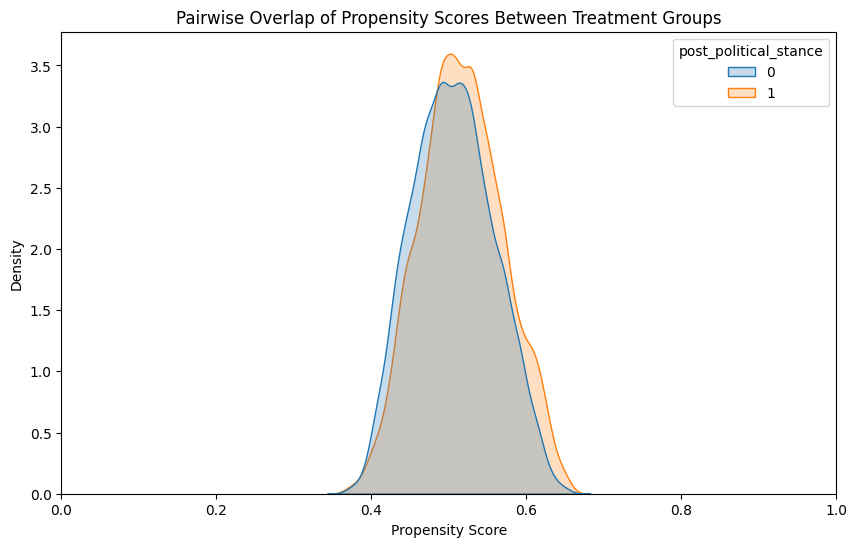

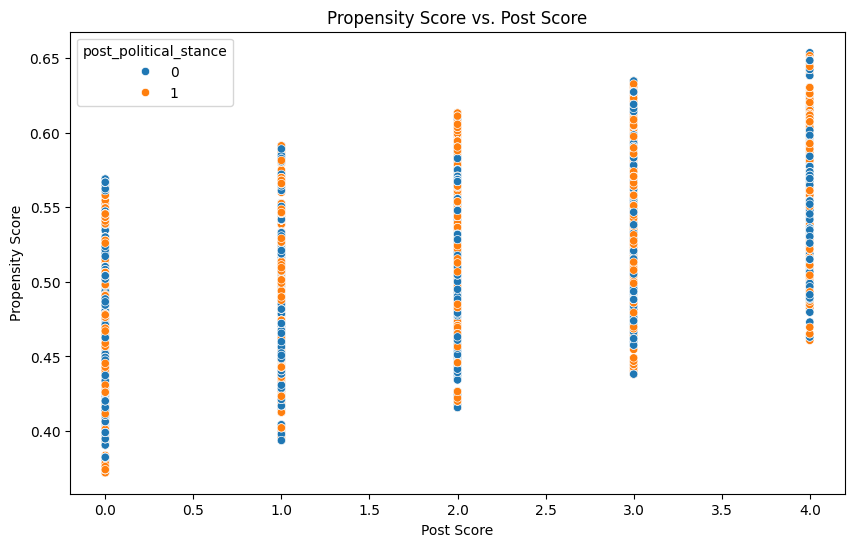

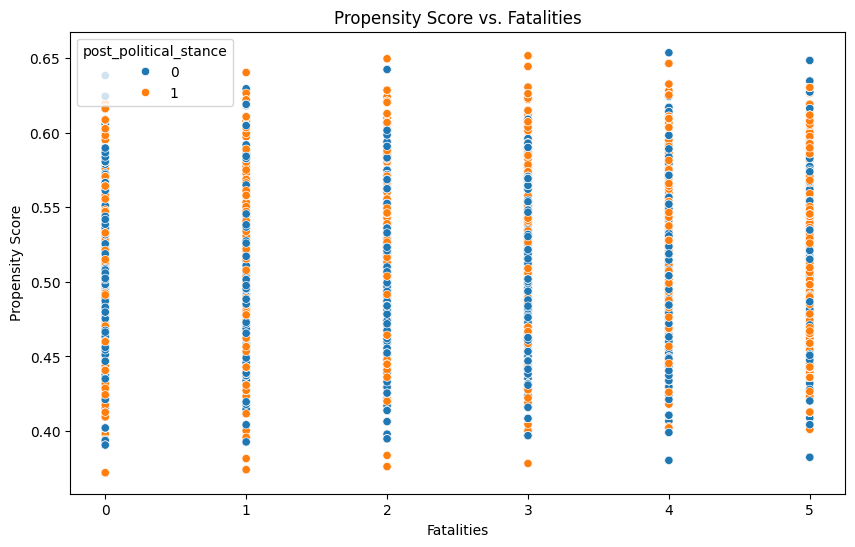

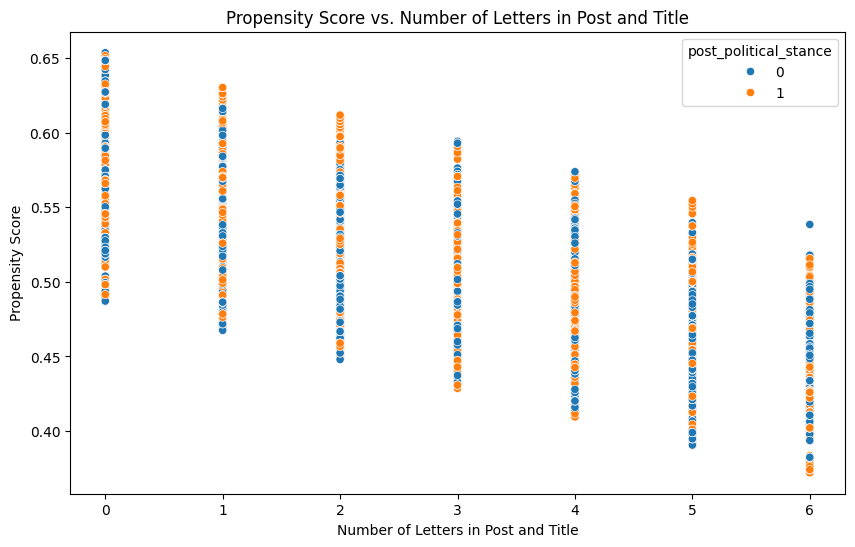

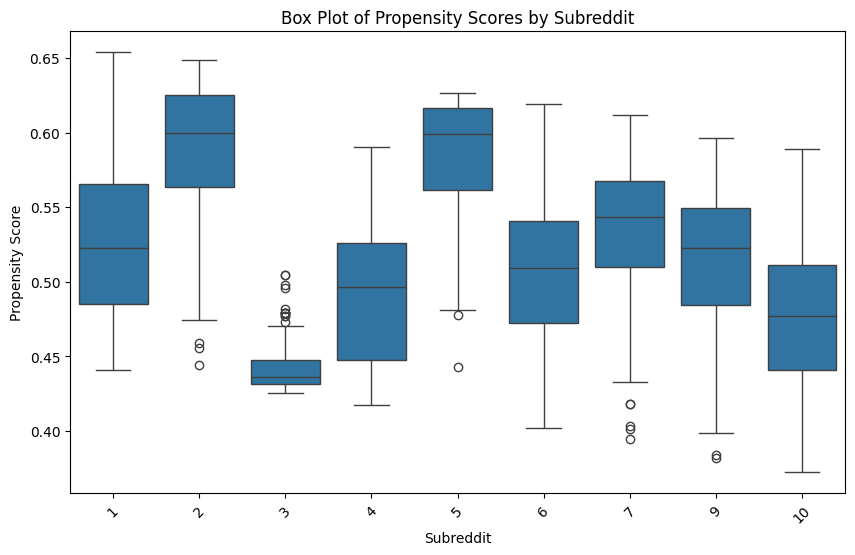

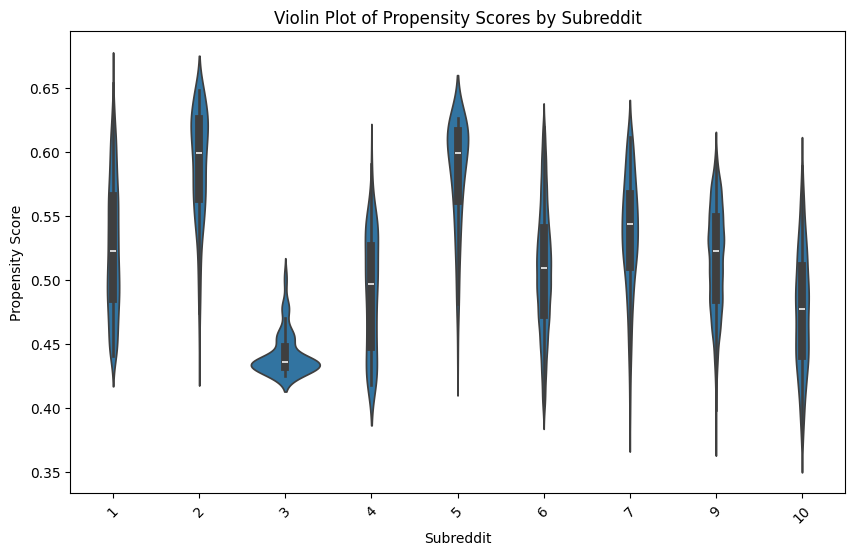

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset with propensity scores
file_path = output_directory / '11.1preprocessed_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Step 1: Kernel Density Plot for each treatment group (binary treatment: 0 and 1)
plt.figure(figsize=(10, 6))

# Loop through each treatment category (0, 1) to plot the propensity score distribution
for i in [0, 1]:  # Binary treatment: 0 for control, 1 for treated
    sns.kdeplot(data.loc[data['post_political_stance'] == i, 'propensity_score'], shade=True, label=f'Treatment {i}')

plt.title('Propensity Score Distribution for Each Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.xlim(0, 1)  # Set the x-axis limits to match the valid range of propensity scores (0 to 1)
plt.legend()
plt.show()

# Step 2: Box Plot to visualize propensity score distribution across treatment groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='propensity_score', data=data)
plt.title('Box Plot of Propensity Scores by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Propensity Score')
plt.xticks([0, 1], ['Control (0)', 'Treatment (1)'])  # Rename treatment groups for clarity
plt.show()

# Step 3: Pairwise KDE Plot for propensity scores between treatment groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='propensity_score', hue='post_political_stance', fill=True)
plt.title('Pairwise Overlap of Propensity Scores Between Treatment Groups')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.xlim(0, 1)  # Keep x-axis within valid propensity score range
plt.show()

# Step 4: Scatter Plot of Propensity Score vs. Covariates (Post Score)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='post_score', y='propensity_score', hue='post_political_stance', data=data)
plt.title('Propensity Score vs. Post Score')
plt.xlabel('Post Score')
plt.ylabel('Propensity Score')
plt.show()

# Step 5: Scatter Plot of Propensity Score vs. Covariates (Fatalities)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fatalities', y='propensity_score', hue='post_political_stance', data=data)
plt.title('Propensity Score vs. Fatalities')
plt.xlabel('Fatalities')
plt.ylabel('Propensity Score')
plt.show()

# Step 6: Scatter Plot of Propensity Score vs. Covariates (Number of Letters in Post and Title)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_letters_post_and_title', y='propensity_score', hue='post_political_stance', data=data)
plt.title('Propensity Score vs. Number of Letters in Post and Title')
plt.xlabel('Number of Letters in Post and Title')
plt.ylabel('Propensity Score')
plt.show()

# Step 7: Box Plot of Propensity Score by Subreddit
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='propensity_score', data=data)
plt.title('Box Plot of Propensity Scores by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Propensity Score')
plt.xticks(rotation=45)
plt.show()

# Step 8: Violin Plot of Propensity Score by Subreddit
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='propensity_score', data=data)
plt.title('Violin Plot of Propensity Scores by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Propensity Score')
plt.xticks(rotation=45)
plt.show()


## *IPW Calculation*

Average Treatment Effect (ATE) using IPW: 0.0014151355963653023

Conditional Average Treatment Effect (IPW) by Subreddit:
   Subreddit      CATE
0          6  0.010758
1          1 -0.011308
2          9  0.004726
3          2 -0.087124
4         10 -0.025906
5          7 -0.055571
6          3  0.000728
7          4  0.003749
8          5 -0.107938


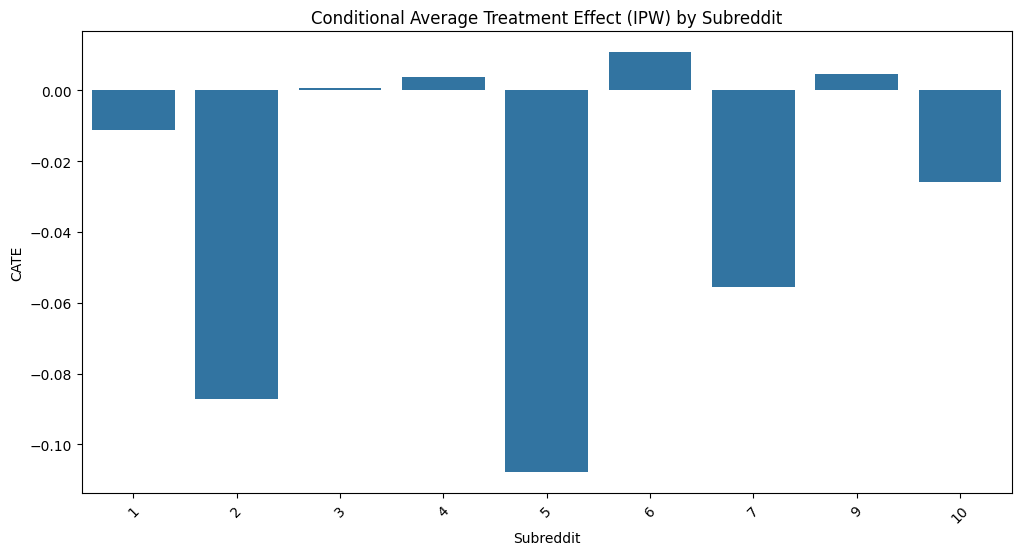

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with propensity scores
file_path = output_directory / '11.1preprocessed_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Step 1: Calculate inverse probability weights based on the propensity score
data['weight'] = data.apply(
    lambda row: 1 / row['propensity_score'] if row['post_political_stance'] == 1 else 1 / (1 - row['propensity_score']),
    axis=1
)

# Step 2: Calculate the weighted average outcome (polarity_score) for treated and control groups
# Treated group: post_political_stance == 1
treated = data[data['post_political_stance'] == 1]
control = data[data['post_political_stance'] == 0]

# Weighted average polarity score for treated group (political stance = 1)
weighted_outcome_treated = (treated['polarity_score'] * treated['weight']).sum() / treated['weight'].sum()

# Weighted average polarity score for control group (political stance = 0)
weighted_outcome_control = (control['polarity_score'] * control['weight']).sum() / control['weight'].sum()

# Step 3: Calculate the ATE (difference in weighted outcomes)
ate = weighted_outcome_treated - weighted_outcome_control

# Output the ATE result
print(f"Average Treatment Effect (ATE) using IPW: {ate}")

# Step 4: CATE Calculation Relative to Subreddit
subreddit_list = data['subreddit'].unique()
cate_results = []

for subreddit in subreddit_list:
    # Filter data for the specific subreddit
    data_subreddit = data[data['subreddit'] == subreddit]

    # Calculate the weighted average outcome for treated and control groups within this subreddit
    treated_subreddit = data_subreddit[data_subreddit['post_political_stance'] == 1]
    control_subreddit = data_subreddit[data_subreddit['post_political_stance'] == 0]

    if treated_subreddit.empty or control_subreddit.empty:
        # Skip subreddit if either treated or control group is empty
        continue

    weighted_outcome_treated_subreddit = (treated_subreddit['polarity_score'] * treated_subreddit['weight']).sum() / treated_subreddit['weight'].sum()
    weighted_outcome_control_subreddit = (control_subreddit['polarity_score'] * control_subreddit['weight']).sum() / control_subreddit['weight'].sum()

    # Calculate CATE for this subreddit
    cate = weighted_outcome_treated_subreddit - weighted_outcome_control_subreddit
    cate_results.append([subreddit, cate])

# Step 5: Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Subreddit', 'CATE'])

# Output the CATE results
print("\nConditional Average Treatment Effect (IPW) by Subreddit:")
print(cate_df)

# Step 6: Plot CATE results
plt.figure(figsize=(12, 6))
sns.barplot(x='Subreddit', y='CATE', data=cate_df)
plt.title('Conditional Average Treatment Effect (IPW) by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('CATE')
plt.xticks(rotation=45)
plt.show()


## *Learners*


Using xgboost:

Using lasso:

Using ridge:

ATE Results:
     Model  S-Learner ATE  T-Learner ATE  X-Learner ATE
0  xgboost      -0.000104            0.0      -0.002265
1    lasso       0.000000            0.0       0.062392
2    ridge       0.001620            0.0       0.001834

CATE Results (relative to subreddit):
      Model  Subreddit  S-Learner CATE  T-Learner CATE  X-Learner CATE
0   xgboost          6       -0.002015             0.0       -0.003054
1   xgboost          1        0.005807             0.0        0.004697
2   xgboost          9        0.023643             0.0        0.024039
3   xgboost          2       -0.027391             0.0       -0.056156
4   xgboost         10        0.004512             0.0        0.004971
5   xgboost          7       -0.067374             0.0       -0.063642
6   xgboost          3        0.002315             0.0       -0.005148
7   xgboost          4       -0.000390             0.0        0.000749
8   xgboost          5       -0.043669  

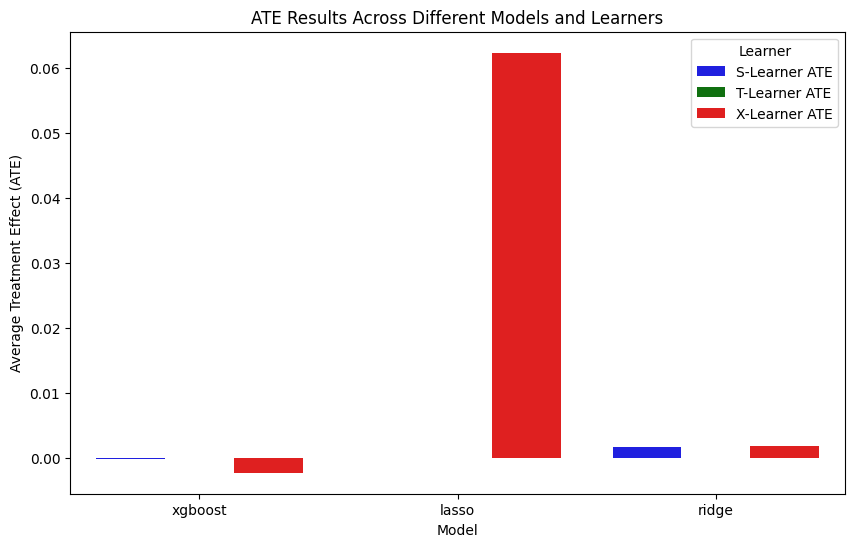

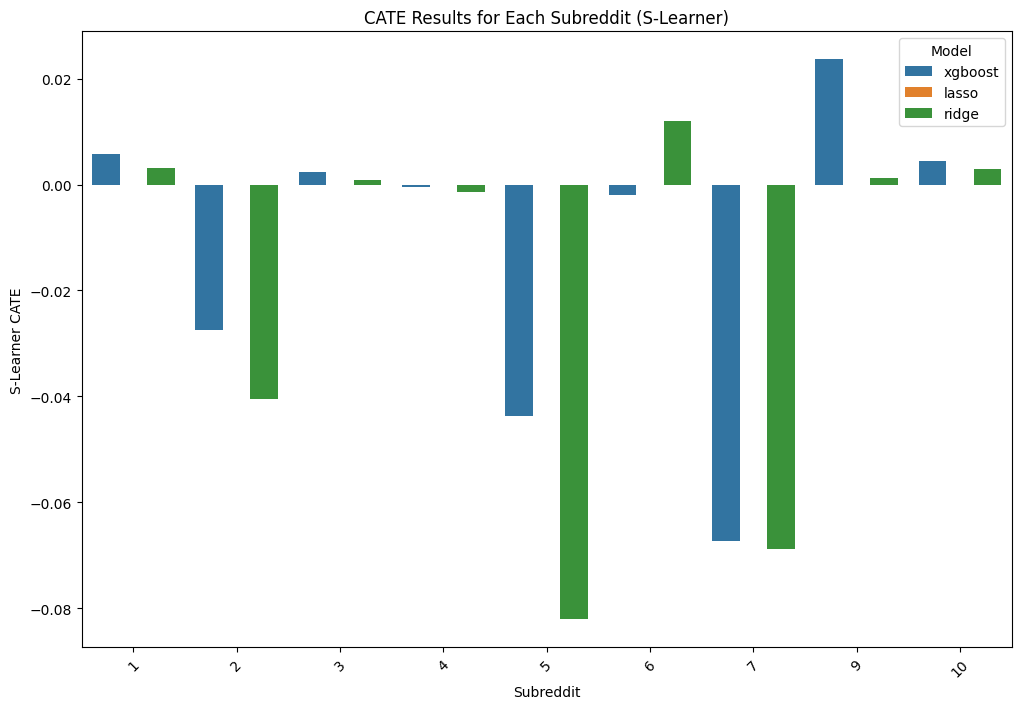

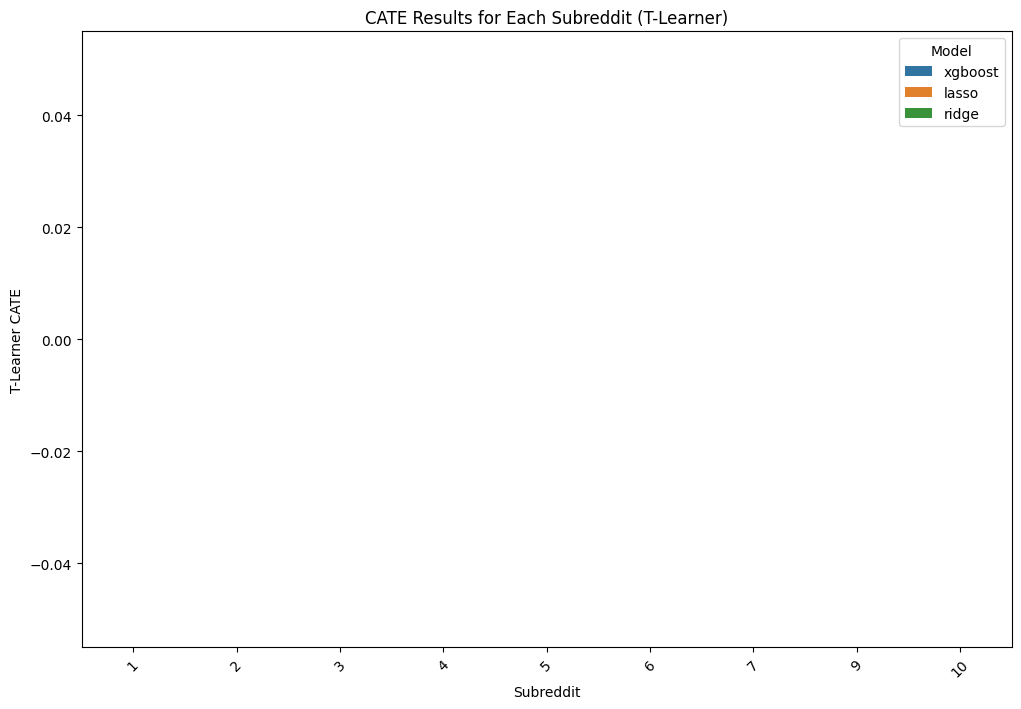

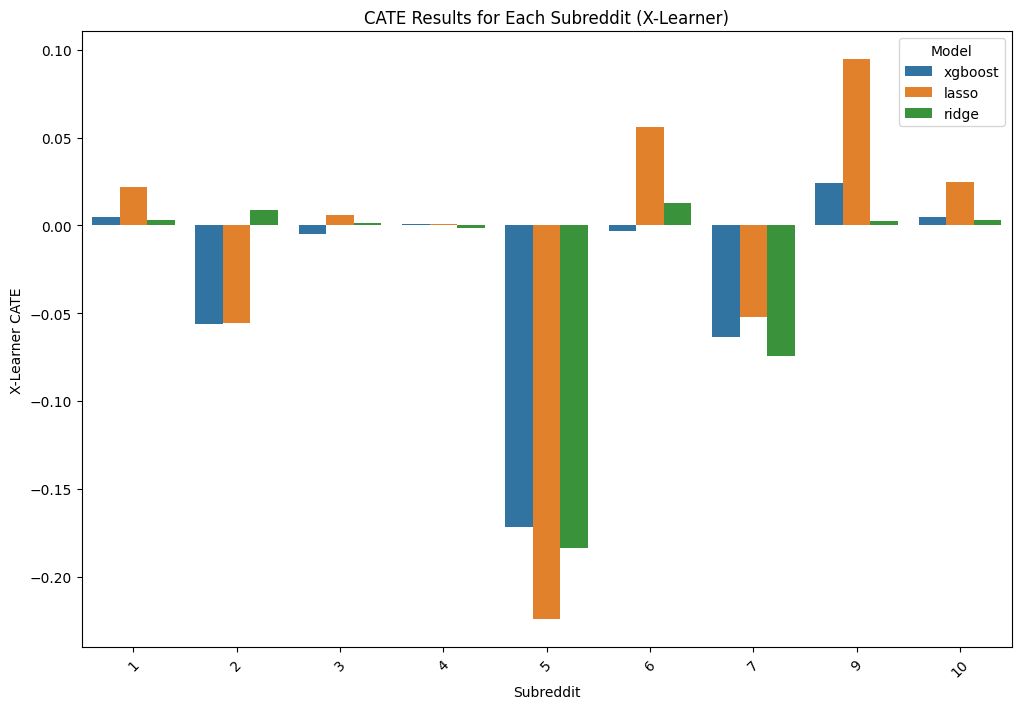

In [ ]:
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (preprocessed, not aggregated)
file_path = output_directory / '11.1preprocessed_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Define the covariates (X), outcome (y), and treatment
covariates = ['subreddit', 'post_score', 'fatalities', 'num_letters_post_and_title']
X = pd.get_dummies(data[covariates], drop_first=True)
y = data['polarity_score']
treatment = data['post_political_stance']

# Train-test split for evaluation
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.3, random_state=42)

### S-Learner
def s_learner(model, X, y, treatment):
    # Add the treatment as a feature
    X['treatment'] = treatment
    model.fit(X, y)
    X_treatment = X.copy()
    X_treatment['treatment'] = 1
    X_control = X.copy()
    X_control['treatment'] = 0
    return model.predict(X_treatment) - model.predict(X_control)

### T-Learner
def t_learner(model, X, y, treatment):
    model_treated = model
    model_treated.fit(X[treatment == 1], y[treatment == 1])

    model_control = model
    model_control.fit(X[treatment == 0], y[treatment == 0])

    return model_treated.predict(X) - model_control.predict(X)

### X-Learner
def x_learner(model, X, y, treatment, propensity_scores):
    tau_control = y[treatment == 1] - model.fit(X[treatment == 0], y[treatment == 0]).predict(X[treatment == 1])
    tau_treated = model.fit(X[treatment == 1], y[treatment == 1]).predict(X[treatment == 0]) - y[treatment == 0]

    propensity_treated = propensity_scores[treatment == 1]
    propensity_control = propensity_scores[treatment == 0]

    tau_control = tau_control * propensity_treated / (1 - propensity_treated)
    tau_treated = tau_treated * (1 - propensity_control) / propensity_control

    return (tau_treated.mean() + tau_control.mean()) / 2

# Step 1: Train propensity score model on the training set
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(X_train, treatment_train)

# Step 2: Calculate propensity scores for the test set
propensity_scores_test = logistic_reg.predict_proba(X_test)[:, 1]

# Step 3: Initialize learners and models
models = {
    "xgboost": XGBRegressor(),
    "lasso": Lasso(),
    "ridge": Ridge()
}

ate_results = []  # To store ATE results
cate_results = []  # To store CATE results

# Step 4: Loop over models and calculate ATE for S, T, and X-learners
for model_name, model in models.items():
    print(f"\nUsing {model_name}:")

    # S-Learner ATE
    s_learner_ate = s_learner(model, X_test.copy(), y_test, treatment_test).mean()

    # T-Learner ATE
    t_learner_ate = t_learner(model, X_test.copy(), y_test, treatment_test).mean()

    # X-Learner ATE (using propensity scores from the test set)
    x_learner_ate = x_learner(model, X_test.copy(), y_test, treatment_test, propensity_scores_test)

    # Store ATE results
    ate_results.append([model_name, s_learner_ate, t_learner_ate, x_learner_ate])

    # Step 5: Calculate CATE relative to the subreddit
    subreddit_list = data['subreddit'].unique()

    for subreddit in subreddit_list:
        # Filter by subreddit directly using the integer value
        X_subreddit = X_test[X_test['subreddit'] == subreddit]
        y_subreddit = y_test[X_test['subreddit'] == subreddit]
        treatment_subreddit = treatment_test[X_test['subreddit'] == subreddit]
        propensity_subreddit = propensity_scores_test[X_test['subreddit'] == subreddit]  # Filter propensity scores as well

        if len(X_subreddit) == 0:
            continue

        # S-Learner CATE
        s_learner_cate = s_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit).mean()

        # T-Learner CATE
        t_learner_cate = t_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit).mean()

        # X-Learner CATE
        x_learner_cate = x_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit, propensity_subreddit)

        # Store CATE results for each subreddit
        cate_results.append([model_name, subreddit, s_learner_cate, t_learner_cate, x_learner_cate])

# Step 6: Convert ATE results into a DataFrame for visualization
ate_df = pd.DataFrame(ate_results, columns=['Model', 'S-Learner ATE', 'T-Learner ATE', 'X-Learner ATE'])
print("\nATE Results:")
print(ate_df)

# Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Model', 'Subreddit', 'S-Learner CATE', 'T-Learner CATE', 'X-Learner CATE'])
print("\nCATE Results (relative to subreddit):")
print(cate_df)

# Step 7: Plot ATE Results
ate_df_melted = pd.melt(ate_df, id_vars=['Model'], value_vars=['S-Learner ATE', 'T-Learner ATE', 'X-Learner ATE'],
                        var_name='Learner', value_name='ATE')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ATE', hue='Learner', data=ate_df_melted, palette={'S-Learner ATE': 'blue', 'T-Learner ATE': 'green', 'X-Learner ATE': 'red'})
plt.title('ATE Results Across Different Models and Learners')
plt.ylabel('Average Treatment Effect (ATE)')
plt.xlabel('Model')
plt.legend(title='Learner')
plt.show()

# Step 8: Plot CATE Results
plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='S-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (S-Learner)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='T-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (T-Learner)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='X-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (X-Learner)')
plt.xticks(rotation=45)
plt.show()


## *Matching*

Average Treatment Effect (ATE) using Covariate Matching: -0.0031759963026099652

Conditional Average Treatment Effect (CATE) by Subreddit:
   Subreddit      CATE
0          6 -0.007022
1          1  0.002965
2          9 -0.021094
3          2 -0.031768
4         10 -0.001622
5          7 -0.045683
6          3 -0.000629
7          4  0.006129
8          5 -0.107133


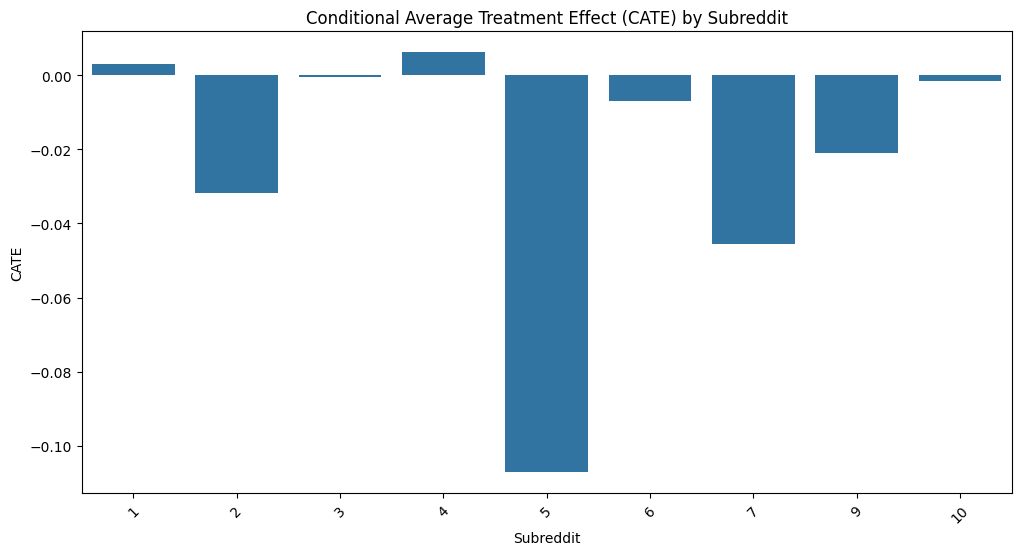

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = output_directory / '11.preprocessed_data_with_labels.csv'
data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']  # Covariates used for matching

# Separate treated and control groups
treated = data[data['post_political_stance'] == 1]  # Treated group
control = data[data['post_political_stance'] == 0]  # Control group

# Step 2: Use nearest neighbor matching based on covariates
treated_covariates = treated[covariates].values  # Covariates for treated units
control_covariates = control[covariates].values  # Covariates for control units

# Initialize NearestNeighbors for matching (1 neighbor for 1-to-1 matching)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_covariates)

# Find the nearest neighbors for each treated unit
distances, indices = nn.kneighbors(treated_covariates)

# Get the matched control outcomes (polarity_score) based on the nearest neighbors
matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values

# Step 3: Calculate ATE using covariate matching
# ATE is the average difference in outcomes between treated and matched control units
treated_outcomes = treated['polarity_score'].values
ate_covariate_matching = np.mean(treated_outcomes - matched_control_outcomes)

# Output the ATE result
print(f"Average Treatment Effect (ATE) using Covariate Matching: {ate_covariate_matching}")

# Step 4: CATE Calculation Relative to Subreddit
subreddit_list = data['subreddit'].unique()
cate_results = []

for subreddit in subreddit_list:
    # Filter data for the specific subreddit
    treated_subreddit = treated[treated['subreddit'] == subreddit]
    control_subreddit = control[control['subreddit'] == subreddit]

    if treated_subreddit.empty or control_subreddit.empty:
        # Skip subreddit if either treated or control group is empty
        continue

    # Perform covariate matching within the subreddit
    treated_covariates_subreddit = treated_subreddit[covariates].values
    control_covariates_subreddit = control_subreddit[covariates].values

    nn.fit(control_covariates_subreddit)
    distances_subreddit, indices_subreddit = nn.kneighbors(treated_covariates_subreddit)

    matched_control_outcomes_subreddit = control_subreddit.iloc[indices_subreddit.flatten()]['polarity_score'].values
    treated_outcomes_subreddit = treated_subreddit['polarity_score'].values

    # Calculate CATE for this subreddit
    cate_subreddit = np.mean(treated_outcomes_subreddit - matched_control_outcomes_subreddit)
    cate_results.append([subreddit, cate_subreddit])

# Step 5: Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Subreddit', 'CATE'])

# Output the CATE results
print("\nConditional Average Treatment Effect (CATE) by Subreddit:")
print(cate_df)

# Step 6: Plot CATE results
plt.figure(figsize=(12, 6))
sns.barplot(x='Subreddit', y='CATE', data=cate_df)
plt.title('Conditional Average Treatment Effect (CATE) by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('CATE')
plt.xticks(rotation=45)
plt.show()


### *Sensitivity Analysis*

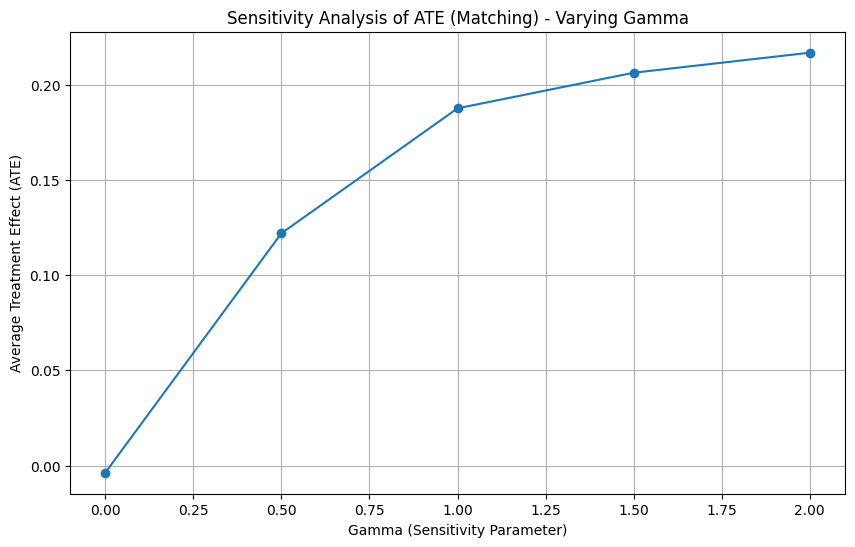

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the dataset with propensity scores
file_path = output_directory / '11.1preprocessed_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']  # Covariates used for matching

# Separate treated and control groups
treated = data[data['post_political_stance'] == 1]  # Treated group
control = data[data['post_political_stance'] == 0]  # Control group

# Use nearest neighbor matching based on covariates
treated_covariates = treated[covariates].values
control_covariates = control[covariates].values

# Step 2: Sensitivity Analysis - Testing Different Matching Algorithms with Bias
# Adjusting the matching process to introduce potential bias
sensitivity_parameters = np.linspace(0, 2, 5)  # Introducing sensitivity (bias) parameters

sensitivity_results = []

for gamma in sensitivity_parameters:
    # Step 3: Use nearest neighbor matching based on covariates with added bias (gamma)
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    control_covariates_with_bias = control_covariates * (1 + gamma)  # Simulating bias
    nn.fit(control_covariates_with_bias)

    # Find the nearest neighbors for each treated unit
    distances, indices = nn.kneighbors(treated_covariates)

    # Get the matched control outcomes (polarity_score) based on the nearest neighbors
    matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values

    # Step 4: Calculate ATE under bias
    treated_outcomes = treated['polarity_score'].values
    ate_with_bias = np.mean(treated_outcomes - matched_control_outcomes)

    # Store results for the current sensitivity parameter (gamma)
    sensitivity_results.append([gamma, ate_with_bias])

# Step 5: Convert sensitivity results to a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results, columns=['Gamma (Sensitivity Parameter)', 'ATE'])

# Step 6: Plot the sensitivity analysis results
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_df['Gamma (Sensitivity Parameter)'], sensitivity_df['ATE'], marker='o', linestyle='-')
plt.title('Sensitivity Analysis of ATE (Matching) - Varying Gamma')
plt.xlabel('Gamma (Sensitivity Parameter)')
plt.ylabel('Average Treatment Effect (ATE)')
plt.grid(True)
plt.show()


### *Bootstraping*

ATE: -0.0020063833631534774
95% Confidence Interval for ATE: (-0.009170340741791967, 0.006300531343163213)


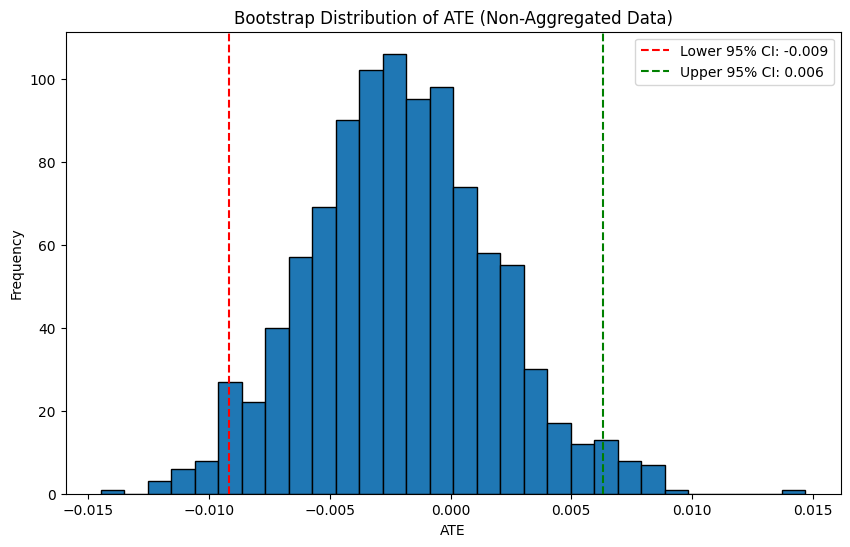

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the non-aggregated dataset with propensity scores
file_path = output_directory / '11.1preprocessed_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']

# Separate treated and control groups
treated = data[data['post_political_stance'] == 1]
control = data[data['post_political_stance'] == 0]

treated_covariates = treated[covariates].values
control_covariates = control[covariates].values

# Initialize nearest neighbors
nn = NearestNeighbors(n_neighbors=1)

def calculate_ate(treated, control, treated_covariates, control_covariates):
    """Calculate ATE for the dataset using covariate matching."""
    nn.fit(control_covariates)
    distances, indices = nn.kneighbors(treated_covariates)
    matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values
    treated_outcomes = treated['polarity_score'].values
    ate = np.mean(treated_outcomes - matched_control_outcomes)
    return ate

# Step 2: Perform bootstrap
n_bootstrap_samples = 1000  # Number of bootstrap resamples
bootstrap_ates = []

for _ in range(n_bootstrap_samples):
    # Step 3: Resample data with replacement
    bootstrap_sample = data.sample(frac=1, replace=True)

    # Step 4: Separate treated and control groups in the resampled data
    treated_bootstrap = bootstrap_sample[bootstrap_sample['post_political_stance'] == 1]
    control_bootstrap = bootstrap_sample[bootstrap_sample['post_political_stance'] == 0]

    treated_covariates_bootstrap = treated_bootstrap[covariates].values
    control_covariates_bootstrap = control_bootstrap[covariates].values

    # Step 5: Calculate ATE for the resampled data
    ate_bootstrap = calculate_ate(treated_bootstrap, control_bootstrap, treated_covariates_bootstrap, control_covariates_bootstrap)
    bootstrap_ates.append(ate_bootstrap)

# Step 6: Calculate confidence intervals from the bootstrap distribution
bootstrap_ates = np.array(bootstrap_ates)
lower_bound = np.percentile(bootstrap_ates, 2.5)
upper_bound = np.percentile(bootstrap_ates, 97.5)

# Step 7: Output results
print(f"ATE: {np.mean(bootstrap_ates)}")
print(f"95% Confidence Interval for ATE: ({lower_bound}, {upper_bound})")

# Step 8: Plot the bootstrap distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_ates, bins=30, edgecolor='k')
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower 95% CI: {lower_bound:.3f}')
plt.axvline(upper_bound, color='g', linestyle='--', label=f'Upper 95% CI: {upper_bound:.3f}')
plt.title("Bootstrap Distribution of ATE (Non-Aggregated Data)")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# **Causal Analysis - After Aggregation**

## *Propensity Score*


In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load the dataset (aggregated)
file_path = output_directory / '12.aggregated.csv'
data = pd.read_csv(file_path)

# Step 1: Ensure the treatment is already binary in 'post_political_stance'
# No need to binarize again as 'post_political_stance' is already 0 or 1

# Step 2: Define the covariates (X)
covariates = ['subreddit', 'post_score', 'fatalities', 'num_letters_post_and_title']
X = pd.get_dummies(data[covariates], drop_first=True)

# Step 3: Define the treatment (y) as binary ('post_political_stance')
y = data['post_political_stance']

# Step 4: Fit a logistic regression model (binary logistic regression)
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(X, y)

# Step 5: Calculate the propensity scores (predicted probabilities)
data['propensity_score'] = logistic_reg.predict_proba(X)[:, 1]  # Propensity score for being in treatment 1

# Step 6: Trimming - Remove observations with extreme propensity scores
lower_trim = 0.2  # Set lower bound for trimming
upper_trim = 0.8  # Set upper bound for trimming

# Keep only data within the trimming thresholds
trimmed_data = data[(data['propensity_score'] >= lower_trim) & (data['propensity_score'] <= upper_trim)]

# Step 7: Remove subreddits that don't contain both treatment and control samples
valid_subreddits = []

# Check each subreddit
for subreddit in trimmed_data['subreddit'].unique():
    subreddit_data = trimmed_data[trimmed_data['subreddit'] == subreddit]
    if len(subreddit_data[subreddit_data['post_political_stance'] == 1]) > 0 and len(subreddit_data[subreddit_data['post_political_stance'] == 0]) > 0:
        valid_subreddits.append(subreddit)

# Filter the trimmed data to only include valid subreddits
trimmed_data = trimmed_data[trimmed_data['subreddit'].isin(valid_subreddits)]

# Step 8: Save the trimmed dataset with propensity scores
output_path_trimmed = output_directory / '12.1aggregated_data_with_propensity.csv'
trimmed_data.to_csv(output_path_trimmed, index=False)

# Display the first few rows of the trimmed data to verify
print(trimmed_data[['post_political_stance', 'propensity_score']].head())


   post_political_stance  propensity_score
0                      1          0.404605
1                      1          0.336282
2                      0          0.687415
3                      0          0.476469
4                      0          0.728208


### Visualization

<ipython-input-88-b0bde1b58161>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(aggregated_data.loc[aggregated_data['post_political_stance'] == i, 'propensity_score'],
<ipython-input-88-b0bde1b58161>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(aggregated_data.loc[aggregated_data['post_political_stance'] == i, 'propensity_score'],


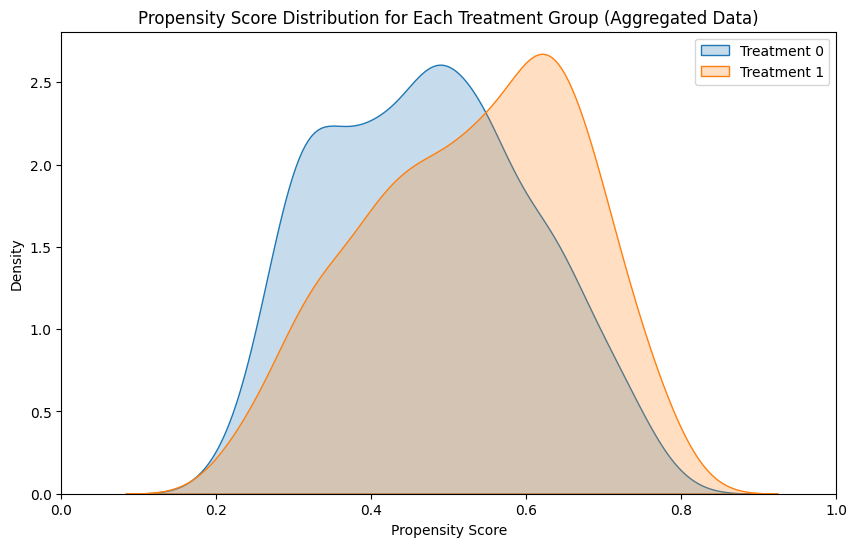

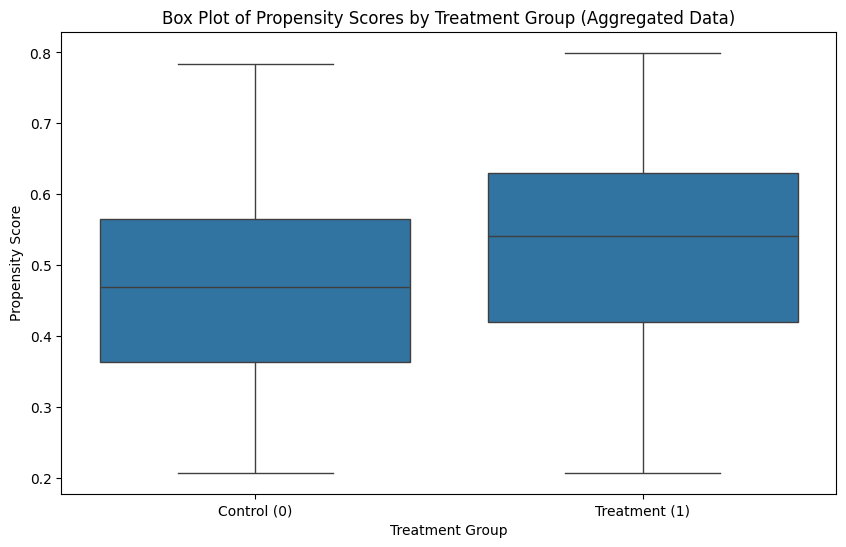

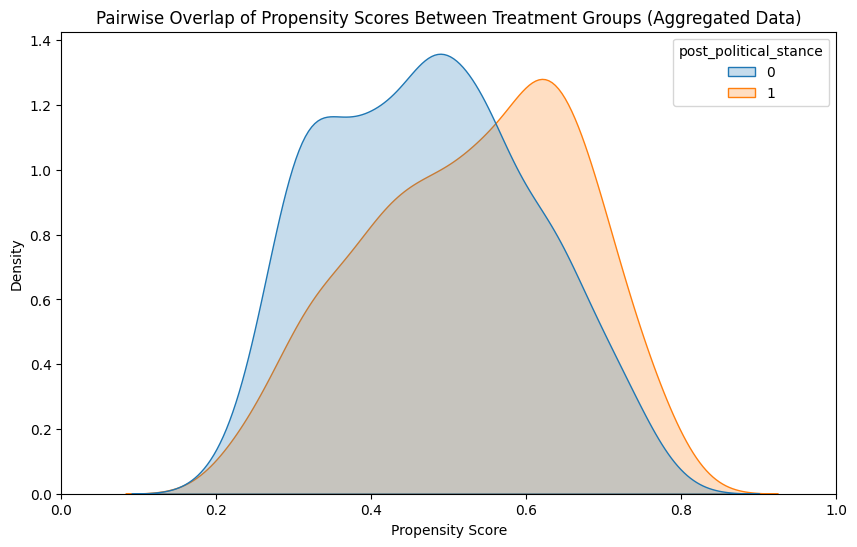

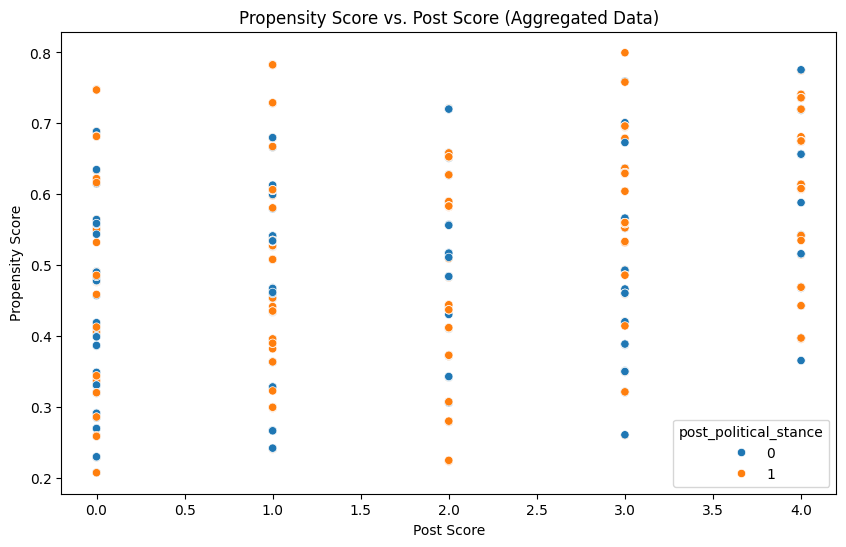

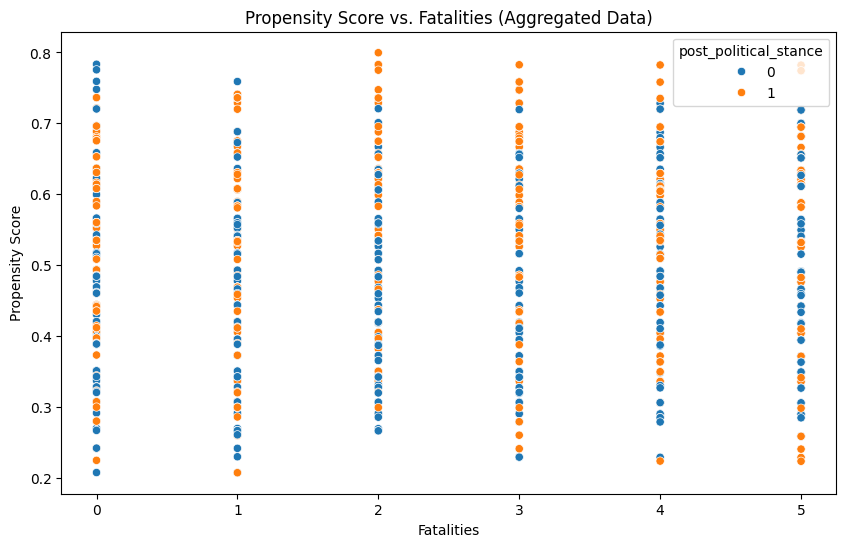

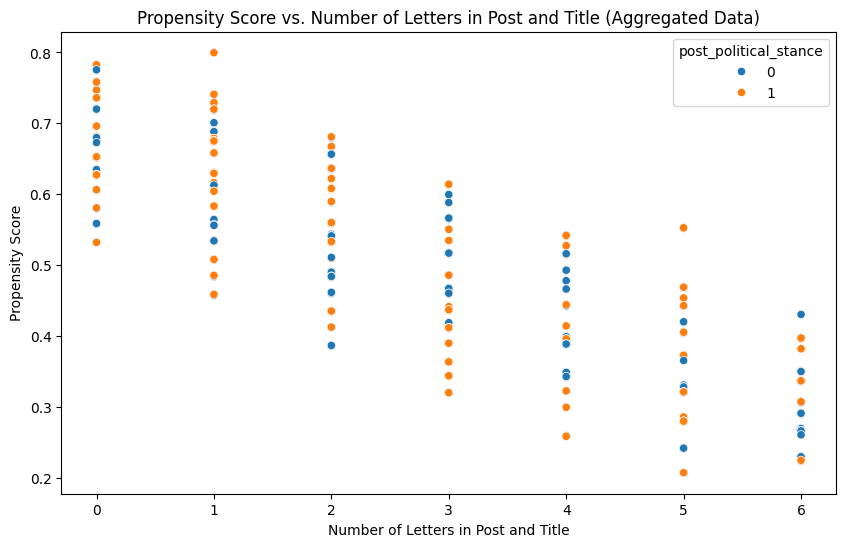

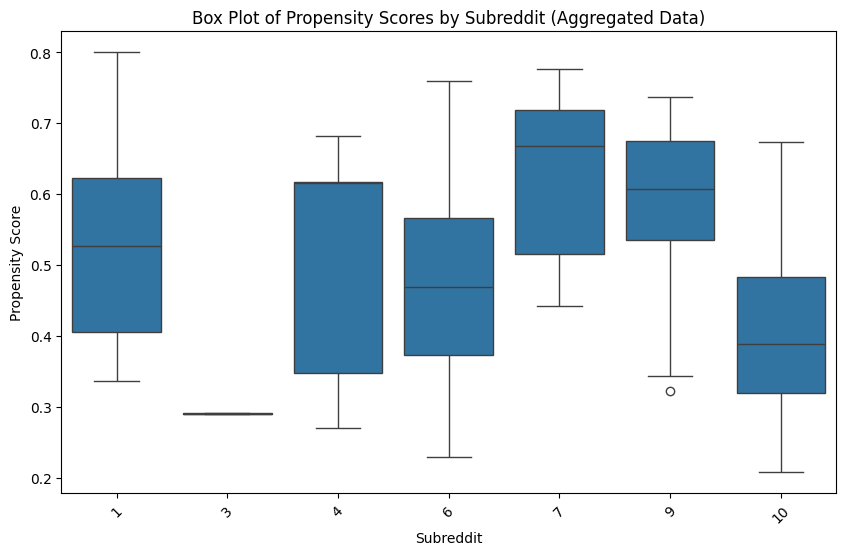

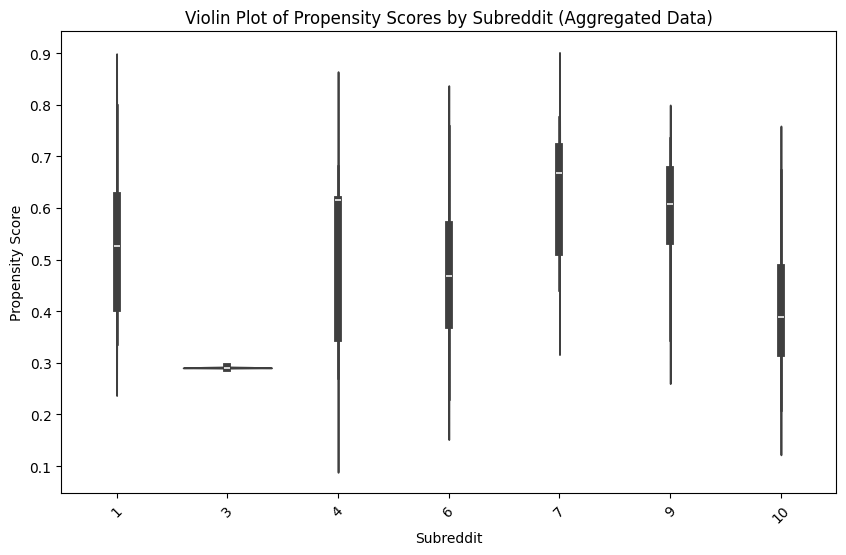

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the aggregated dataset with propensity scores
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
aggregated_data = pd.read_csv(file_path)

# Step 1: Kernel Density Plot for each treatment group (binary treatment: 0 and 1)
plt.figure(figsize=(10, 6))

# Loop through each treatment category (0, 1) to plot the propensity score distribution
for i in [0, 1]:  # Binary treatment: 0 for control, 1 for treated
    sns.kdeplot(aggregated_data.loc[aggregated_data['post_political_stance'] == i, 'propensity_score'],
                shade=True, label=f'Treatment {i}')

plt.title('Propensity Score Distribution for Each Treatment Group (Aggregated Data)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.xlim(0, 1)  # Set the x-axis limits to match the valid range of propensity scores (0 to 1)
plt.legend()
plt.show()

# Step 2: Box Plot to visualize propensity score distribution across treatment groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='post_political_stance', y='propensity_score', data=aggregated_data)
plt.title('Box Plot of Propensity Scores by Treatment Group (Aggregated Data)')
plt.xlabel('Treatment Group')
plt.ylabel('Propensity Score')
plt.xticks([0, 1], ['Control (0)', 'Treatment (1)'])  # Rename treatment groups for clarity
plt.show()

# Step 3: Pairwise KDE Plot for propensity scores between treatment groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=aggregated_data, x='propensity_score', hue='post_political_stance', fill=True)
plt.title('Pairwise Overlap of Propensity Scores Between Treatment Groups (Aggregated Data)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.xlim(0, 1)  # Keep x-axis within valid propensity score range
plt.show()

# Step 4: Scatter Plot of Propensity Score vs. Covariates (Post Score)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='post_score', y='propensity_score', hue='post_political_stance', data=aggregated_data)
plt.title('Propensity Score vs. Post Score (Aggregated Data)')
plt.xlabel('Post Score')
plt.ylabel('Propensity Score')
plt.show()

# Step 5: Scatter Plot of Propensity Score vs. Covariates (Fatalities)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fatalities', y='propensity_score', hue='post_political_stance', data=aggregated_data)
plt.title('Propensity Score vs. Fatalities (Aggregated Data)')
plt.xlabel('Fatalities')
plt.ylabel('Propensity Score')
plt.show()

# Step 6: Scatter Plot of Propensity Score vs. Covariates (Number of Letters in Post and Title)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_letters_post_and_title', y='propensity_score', hue='post_political_stance', data=aggregated_data)
plt.title('Propensity Score vs. Number of Letters in Post and Title (Aggregated Data)')
plt.xlabel('Number of Letters in Post and Title')
plt.ylabel('Propensity Score')
plt.show()

# Step 7: Box Plot of Propensity Score by Subreddit
plt.figure(figsize=(10, 6))
sns.boxplot(x='subreddit', y='propensity_score', data=aggregated_data)
plt.title('Box Plot of Propensity Scores by Subreddit (Aggregated Data)')
plt.xlabel('Subreddit')
plt.ylabel('Propensity Score')
plt.xticks(rotation=45)
plt.show()

# Step 8: Violin Plot of Propensity Score by Subreddit
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='propensity_score', data=aggregated_data)
plt.title('Violin Plot of Propensity Scores by Subreddit (Aggregated Data)')
plt.xlabel('Subreddit')
plt.ylabel('Propensity Score')
plt.xticks(rotation=45)
plt.show()


## *IPW Calculation*

Average Treatment Effect (ATE) using IPW on Aggregated Data: -0.009717567013340783

Conditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data:
   Subreddit      CATE
0          1 -0.008848
1          3  0.023613
2          4  0.015128
3          6  0.030302
4          7 -0.070653
5          9  0.012813
6         10 -0.013479


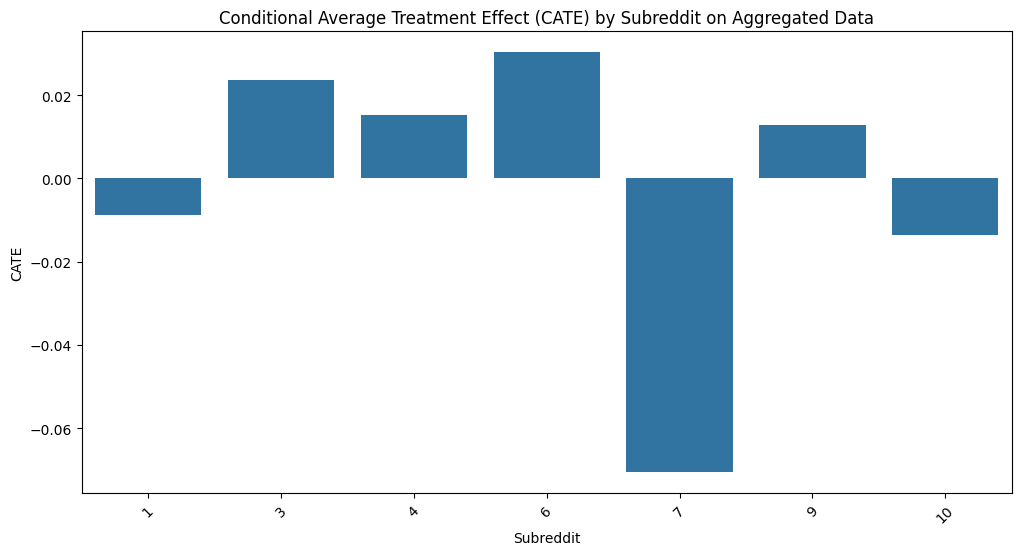

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the aggregated dataset with propensity scores
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
aggregated_data = pd.read_csv(file_path)

# Step 1: Calculate inverse probability weights based on the propensity score
aggregated_data['weight'] = aggregated_data.apply(
    lambda row: 1 / row['propensity_score'] if row['post_political_stance'] == 1 else 1 / (1 - row['propensity_score']),
    axis=1
)

# Step 2: Calculate the weighted average outcome (polarity_score) for treated and control groups
# Treated group: post_political_stance == 1
treated = aggregated_data[aggregated_data['post_political_stance'] == 1]
control = aggregated_data[aggregated_data['post_political_stance'] == 0]

# Weighted average polarity score for treated group (political stance = 1)
weighted_outcome_treated = (treated['polarity_score'] * treated['weight']).sum() / treated['weight'].sum()

# Weighted average polarity score for control group (political stance = 0)
weighted_outcome_control = (control['polarity_score'] * control['weight']).sum() / control['weight'].sum()

# Step 3: Calculate the ATE (difference in weighted outcomes)
ate = weighted_outcome_treated - weighted_outcome_control

# Output the ATE result
print(f"Average Treatment Effect (ATE) using IPW on Aggregated Data: {ate}")

# Step 4: CATE Calculation Relative to Subreddit
subreddit_list = aggregated_data['subreddit'].unique()
cate_results = []

for subreddit in subreddit_list:
    # Filter aggregated data for the specific subreddit
    data_subreddit = aggregated_data[aggregated_data['subreddit'] == subreddit]

    # Calculate the weighted average outcome for treated and control groups within this subreddit
    treated_subreddit = data_subreddit[data_subreddit['post_political_stance'] == 1]
    control_subreddit = data_subreddit[data_subreddit['post_political_stance'] == 0]

    if treated_subreddit.empty or control_subreddit.empty:
        # Skip subreddit if either treated or control group is empty
        continue

    weighted_outcome_treated_subreddit = (treated_subreddit['polarity_score'] * treated_subreddit['weight']).sum() / treated_subreddit['weight'].sum()
    weighted_outcome_control_subreddit = (control_subreddit['polarity_score'] * control_subreddit['weight']).sum() / control_subreddit['weight'].sum()

    # Calculate CATE for this subreddit
    cate = weighted_outcome_treated_subreddit - weighted_outcome_control_subreddit
    cate_results.append([subreddit, cate])

# Step 5: Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Subreddit', 'CATE'])

# Output the CATE results
print("\nConditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data:")
print(cate_df)

# Step 6: Plot CATE results
plt.figure(figsize=(12, 6))
sns.barplot(x='Subreddit', y='CATE', data=cate_df)
plt.title('Conditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data')
plt.xlabel('Subreddit')
plt.ylabel('CATE')
plt.xticks(rotation=45)
plt.show()


## *Learners*


Using xgboost:

Using lasso:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



Using ridge:

ATE Results (Aggregated Data):
     Model  S-Learner ATE  T-Learner ATE  X-Learner ATE
0  xgboost       0.002238            0.0       0.012146
1    lasso       0.000000            0.0       0.040417
2    ridge       0.004339            0.0       0.005890

CATE Results (relative to subreddit on Aggregated Data):
      Model  Subreddit  S-Learner CATE  T-Learner CATE  X-Learner CATE
0   xgboost          1       -0.001104             0.0        0.006215
1   xgboost          3        0.000511             0.0        0.006883
2   xgboost          4        0.000000             0.0        0.031675
3   xgboost          6        0.009701             0.0        0.029793
4   xgboost          7       -0.015494             0.0       -0.172691
5   xgboost          9       -0.009437             0.0        0.001405
6   xgboost         10        0.002260             0.0       -0.010202
7     lasso          1        0.000000             0.0        0.010027
8     lasso          3        0.0

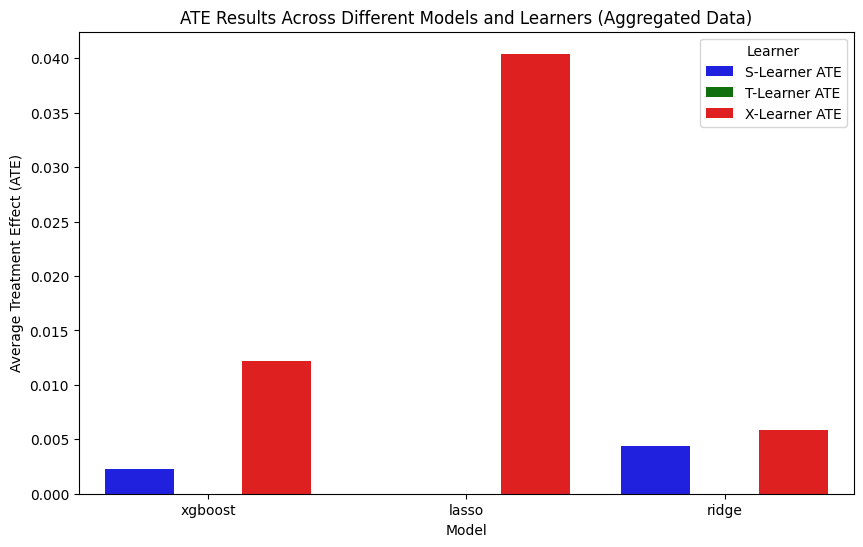

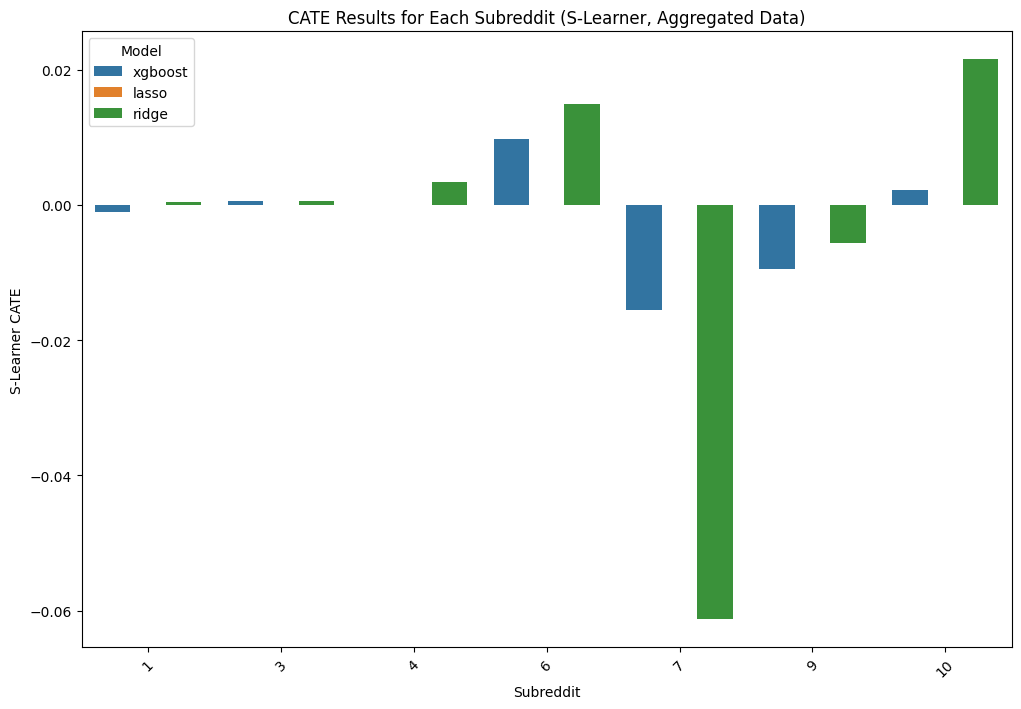

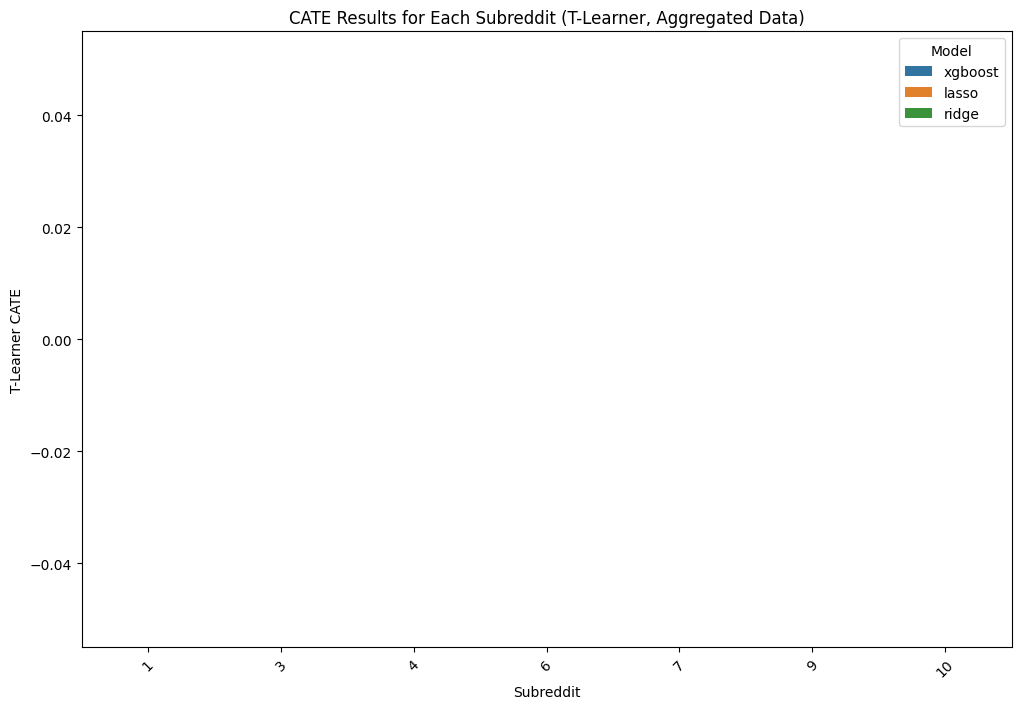

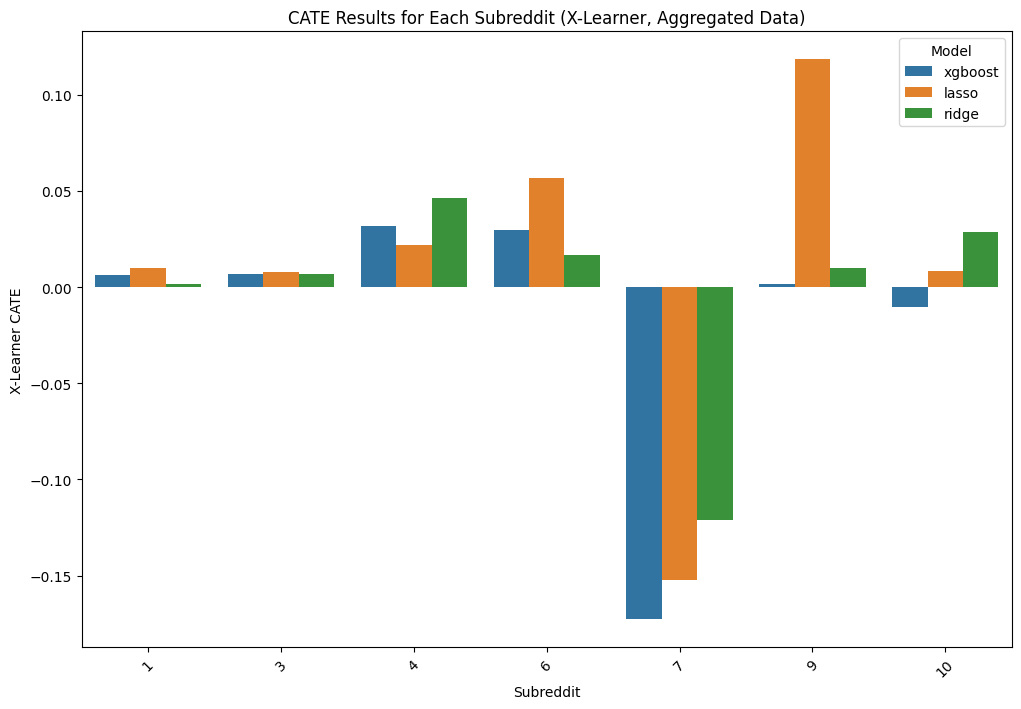

In [ ]:
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the aggregated dataset
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
aggregated_data = pd.read_csv(file_path)

# Define the covariates (X), outcome (y), and treatment
covariates = ['subreddit', 'post_score', 'fatalities', 'num_letters_post_and_title']
X = pd.get_dummies(aggregated_data[covariates], drop_first=True)
y = aggregated_data['polarity_score']
treatment = aggregated_data['post_political_stance']

# Train-test split for evaluation
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, y, treatment, test_size=0.3, random_state=42)

### S-Learner
def s_learner(model, X, y, treatment):
    # Add the treatment as a feature
    X['treatment'] = treatment
    model.fit(X, y)
    X_treatment = X.copy()
    X_treatment['treatment'] = 1
    X_control = X.copy()
    X_control['treatment'] = 0
    return model.predict(X_treatment) - model.predict(X_control)

### T-Learner
def t_learner(model, X, y, treatment):
    model_treated = model
    model_treated.fit(X[treatment == 1], y[treatment == 1])

    model_control = model
    model_control.fit(X[treatment == 0], y[treatment == 0])

    return model_treated.predict(X) - model_control.predict(X)

### X-Learner
def x_learner(model, X, y, treatment, propensity_scores):
    tau_control = y[treatment == 1] - model.fit(X[treatment == 0], y[treatment == 0]).predict(X[treatment == 1])
    tau_treated = model.fit(X[treatment == 1], y[treatment == 1]).predict(X[treatment == 0]) - y[treatment == 0]

    propensity_treated = propensity_scores[treatment == 1]
    propensity_control = propensity_scores[treatment == 0]

    tau_control = tau_control * propensity_treated / (1 - propensity_treated)
    tau_treated = tau_treated * (1 - propensity_control) / propensity_control

    return (tau_treated.mean() + tau_control.mean()) / 2

# Step 1: Train propensity score model on the training set
logistic_reg = LogisticRegression(max_iter=2000)
logistic_reg.fit(X_train, treatment_train)

# Step 2: Calculate propensity scores for the test set
propensity_scores_test = logistic_reg.predict_proba(X_test)[:, 1]

# Step 3: Initialize learners and models
models = {
    "xgboost": XGBRegressor(),
    "lasso": Lasso(),
    "ridge": Ridge()
}

ate_results = []  # To store ATE results
cate_results = []  # To store CATE results

# Step 4: Loop over models and calculate ATE for S, T, and X-learners
for model_name, model in models.items():
    print(f"\nUsing {model_name}:")

    # S-Learner ATE
    s_learner_ate = s_learner(model, X_test.copy(), y_test, treatment_test).mean()

    # T-Learner ATE
    t_learner_ate = t_learner(model, X_test.copy(), y_test, treatment_test).mean()

    # X-Learner ATE (using propensity scores from the test set)
    x_learner_ate = x_learner(model, X_test.copy(), y_test, treatment_test, propensity_scores_test)

    # Store ATE results
    ate_results.append([model_name, s_learner_ate, t_learner_ate, x_learner_ate])

    # Step 5: Calculate CATE relative to the subreddit
    subreddit_list = aggregated_data['subreddit'].unique()

    for subreddit in subreddit_list:
        # Filter by subreddit directly using the integer value
        X_subreddit = X_test[X_test['subreddit'] == subreddit]
        y_subreddit = y_test[X_test['subreddit'] == subreddit]
        treatment_subreddit = treatment_test[X_test['subreddit'] == subreddit]
        propensity_subreddit = propensity_scores_test[X_test['subreddit'] == subreddit]  # Filter propensity scores as well

        if len(X_subreddit) == 0:
            continue

        # S-Learner CATE
        s_learner_cate = s_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit).mean()

        # T-Learner CATE
        t_learner_cate = t_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit).mean()

        # X-Learner CATE
        x_learner_cate = x_learner(model, X_subreddit.copy(), y_subreddit, treatment_subreddit, propensity_subreddit)

        # Store CATE results for each subreddit
        cate_results.append([model_name, subreddit, s_learner_cate, t_learner_cate, x_learner_cate])

# Step 6: Convert ATE results into a DataFrame for visualization
ate_df = pd.DataFrame(ate_results, columns=['Model', 'S-Learner ATE', 'T-Learner ATE', 'X-Learner ATE'])
print("\nATE Results (Aggregated Data):")
print(ate_df)

# Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Model', 'Subreddit', 'S-Learner CATE', 'T-Learner CATE', 'X-Learner CATE'])
print("\nCATE Results (relative to subreddit on Aggregated Data):")
print(cate_df)

# Step 7: Plot ATE Results
ate_df_melted = pd.melt(ate_df, id_vars=['Model'], value_vars=['S-Learner ATE', 'T-Learner ATE', 'X-Learner ATE'],
                        var_name='Learner', value_name='ATE')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ATE', hue='Learner', data=ate_df_melted, palette={'S-Learner ATE': 'blue', 'T-Learner ATE': 'green', 'X-Learner ATE': 'red'})
plt.title('ATE Results Across Different Models and Learners (Aggregated Data)')
plt.ylabel('Average Treatment Effect (ATE)')
plt.xlabel('Model')
plt.legend(title='Learner')
plt.show()

# Step 8: Plot CATE Results
plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='S-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (S-Learner, Aggregated Data)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='T-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (T-Learner, Aggregated Data)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Subreddit', y='X-Learner CATE', hue='Model', data=cate_df)
plt.title('CATE Results for Each Subreddit (X-Learner, Aggregated Data)')
plt.xticks(rotation=45)
plt.show()


## *Matching*

Average Treatment Effect (ATE) using Covariate Matching on Aggregated Data: 0.010471502722081454

Conditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data:
   Subreddit      CATE
0          1 -0.005908
1          3  0.024532
2          4  0.014671
3          6  0.011249
4          7 -0.024603
5          9  0.003567
6         10  0.011407


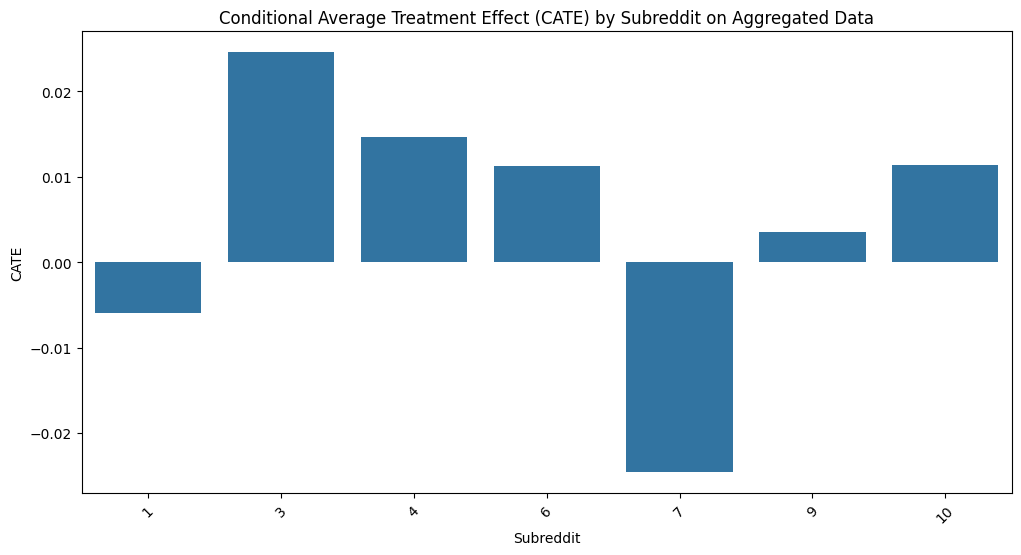

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Load the aggregated dataset
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
aggregated_data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']  # Covariates used for matching

# Separate treated and control groups
treated = aggregated_data[aggregated_data['post_political_stance'] == 1]  # Treated group
control = aggregated_data[aggregated_data['post_political_stance'] == 0]  # Control group

# Step 2: Use nearest neighbor matching based on covariates
treated_covariates = treated[covariates].values  # Covariates for treated units
control_covariates = control[covariates].values  # Covariates for control units

# Initialize NearestNeighbors for matching (1 neighbor for 1-to-1 matching)
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_covariates)

# Find the nearest neighbors for each treated unit
distances, indices = nn.kneighbors(treated_covariates)

# Get the matched control outcomes (polarity_score) based on the nearest neighbors
matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values

# Step 3: Calculate ATE using covariate matching
# ATE is the average difference in outcomes between treated and matched control units
treated_outcomes = treated['polarity_score'].values
ate_covariate_matching = np.mean(treated_outcomes - matched_control_outcomes)

# Output the ATE result
print(f"Average Treatment Effect (ATE) using Covariate Matching on Aggregated Data: {ate_covariate_matching}")

# Step 4: CATE Calculation Relative to Subreddit
subreddit_list = aggregated_data['subreddit'].unique()
cate_results = []

for subreddit in subreddit_list:
    # Filter data for the specific subreddit
    treated_subreddit = treated[treated['subreddit'] == subreddit]
    control_subreddit = control[control['subreddit'] == subreddit]

    if treated_subreddit.empty or control_subreddit.empty:
        # Skip subreddit if either treated or control group is empty
        continue

    # Perform covariate matching within the subreddit
    treated_covariates_subreddit = treated_subreddit[covariates].values
    control_covariates_subreddit = control_subreddit[covariates].values

    nn.fit(control_covariates_subreddit)
    distances_subreddit, indices_subreddit = nn.kneighbors(treated_covariates_subreddit)

    matched_control_outcomes_subreddit = control_subreddit.iloc[indices_subreddit.flatten()]['polarity_score'].values
    treated_outcomes_subreddit = treated_subreddit['polarity_score'].values

    # Calculate CATE for this subreddit
    cate_subreddit = np.mean(treated_outcomes_subreddit - matched_control_outcomes_subreddit)
    cate_results.append([subreddit, cate_subreddit])

# Step 5: Convert CATE results into a DataFrame for visualization
cate_df = pd.DataFrame(cate_results, columns=['Subreddit', 'CATE'])

# Output the CATE results
print("\nConditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data:")
print(cate_df)

# Step 6: Plot CATE results
plt.figure(figsize=(12, 6))
sns.barplot(x='Subreddit', y='CATE', data=cate_df)
plt.title('Conditional Average Treatment Effect (CATE) by Subreddit on Aggregated Data')
plt.xlabel('Subreddit')
plt.ylabel('CATE')
plt.xticks(rotation=45)
plt.show()


### *Sensitivity Analysis*

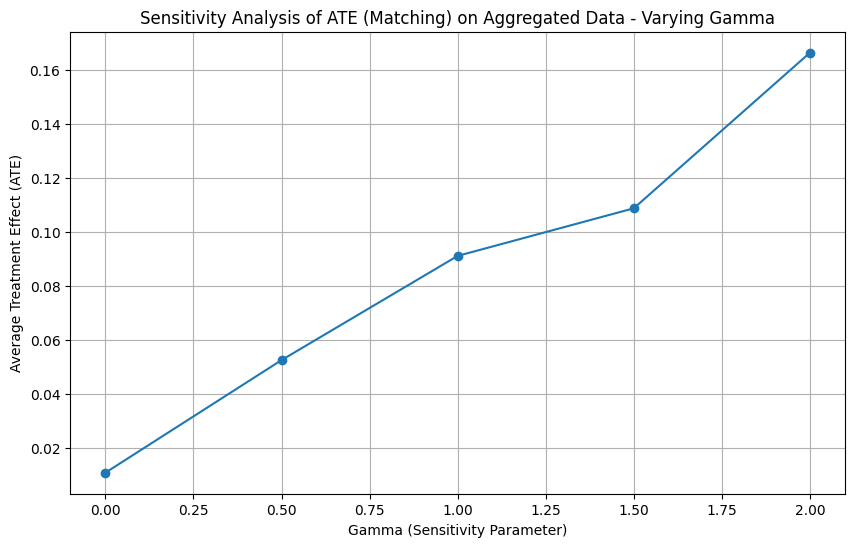

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the dataset with propensity scores (aggregated)
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
aggregated_data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']  # Covariates used for matching

# Separate treated and control groups
treated = aggregated_data[aggregated_data['post_political_stance'] == 1]  # Treated group
control = aggregated_data[aggregated_data['post_political_stance'] == 0]  # Control group

# Use nearest neighbor matching based on covariates
treated_covariates = treated[covariates].values
control_covariates = control[covariates].values

# Step 2: Sensitivity Analysis - Testing Different Matching Algorithms with Bias
# Adjusting the matching process to introduce potential bias
sensitivity_parameters = np.linspace(0, 2, 5)  # Introducing sensitivity (bias) parameters

sensitivity_results = []

for gamma in sensitivity_parameters:
    # Step 3: Use nearest neighbor matching based on covariates with added bias (gamma)
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    control_covariates_with_bias = control_covariates * (1 + gamma)  # Simulating bias
    nn.fit(control_covariates_with_bias)

    # Find the nearest neighbors for each treated unit
    distances, indices = nn.kneighbors(treated_covariates)

    # Get the matched control outcomes (polarity_score) based on the nearest neighbors
    matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values

    # Step 4: Calculate ATE under bias
    treated_outcomes = treated['polarity_score'].values
    ate_with_bias = np.mean(treated_outcomes - matched_control_outcomes)

    # Store results for the current sensitivity parameter (gamma)
    sensitivity_results.append([gamma, ate_with_bias])

# Step 5: Convert sensitivity results to a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results, columns=['Gamma (Sensitivity Parameter)', 'ATE'])

# Step 6: Plot the sensitivity analysis results
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_df['Gamma (Sensitivity Parameter)'], sensitivity_df['ATE'], marker='o', linestyle='-')
plt.title('Sensitivity Analysis of ATE (Matching) on Aggregated Data - Varying Gamma')
plt.xlabel('Gamma (Sensitivity Parameter)')
plt.ylabel('Average Treatment Effect (ATE)')
plt.grid(True)
plt.show()


### *Bootstrap*

ATE: 0.009735798269649739
95% Confidence Interval for ATE: (-0.004154995665339583, 0.024004574765412172)


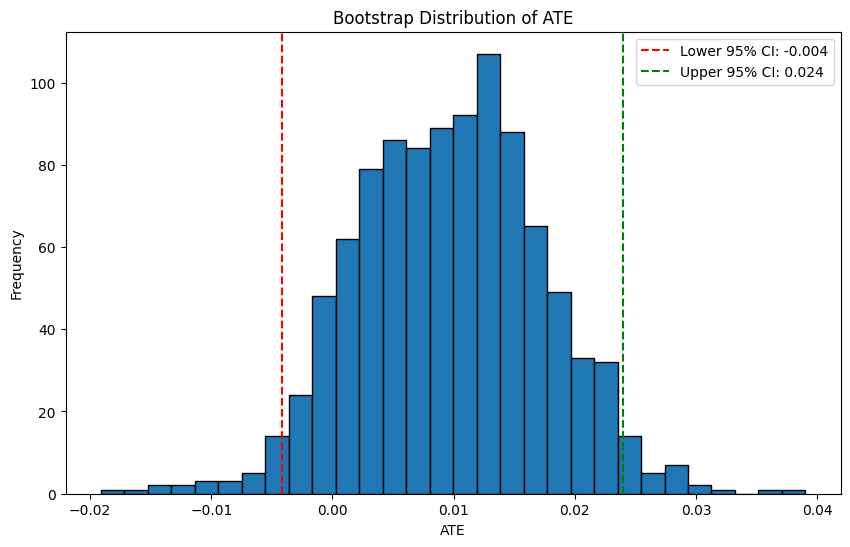

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Load your dataset
file_path = output_directory / '12.1aggregated_data_with_propensity.csv'
data = pd.read_csv(file_path)

# Step 1: Define the covariates for matching
covariates = ['post_score', 'fatalities', 'num_letters_post_and_title', 'subreddit']

# Separate treated and control groups
treated = data[data['post_political_stance'] == 1]
control = data[data['post_political_stance'] == 0]

treated_covariates = treated[covariates].values
control_covariates = control[covariates].values

# Initialize nearest neighbors
nn = NearestNeighbors(n_neighbors=1)

def calculate_ate(treated, control, treated_covariates, control_covariates):
    """Calculate ATE for the dataset using covariate matching."""
    nn.fit(control_covariates)
    distances, indices = nn.kneighbors(treated_covariates)
    matched_control_outcomes = control.iloc[indices.flatten()]['polarity_score'].values
    treated_outcomes = treated['polarity_score'].values
    ate = np.mean(treated_outcomes - matched_control_outcomes)
    return ate

# Step 2: Perform bootstrap
n_bootstrap_samples = 1000  # Number of bootstrap resamples
bootstrap_ates = []

for _ in range(n_bootstrap_samples):
    # Step 3: Resample data with replacement
    bootstrap_sample = data.sample(frac=1, replace=True)

    # Step 4: Separate treated and control groups in the resampled data
    treated_bootstrap = bootstrap_sample[bootstrap_sample['post_political_stance'] == 1]
    control_bootstrap = bootstrap_sample[bootstrap_sample['post_political_stance'] == 0]

    treated_covariates_bootstrap = treated_bootstrap[covariates].values
    control_covariates_bootstrap = control_bootstrap[covariates].values

    # Step 5: Calculate ATE for the resampled data
    ate_bootstrap = calculate_ate(treated_bootstrap, control_bootstrap, treated_covariates_bootstrap, control_covariates_bootstrap)
    bootstrap_ates.append(ate_bootstrap)

# Step 6: Calculate confidence intervals from the bootstrap distribution
bootstrap_ates = np.array(bootstrap_ates)
lower_bound = np.percentile(bootstrap_ates, 2.5)
upper_bound = np.percentile(bootstrap_ates, 97.5)

# Step 7: Output results
print(f"ATE: {np.mean(bootstrap_ates)}")
print(f"95% Confidence Interval for ATE: ({lower_bound}, {upper_bound})")

# Plot the bootstrap distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_ates, bins=30, edgecolor='k')
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower 95% CI: {lower_bound:.3f}')
plt.axvline(upper_bound, color='g', linestyle='--', label=f'Upper 95% CI: {upper_bound:.3f}')
plt.title("Bootstrap Distribution of ATE")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()
